In [1]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas
import math

# mhttp://localhost:8889/notebooks/sentimentAnalysis.ipynb#ake this point to the file with the clean tweets
DATAFILE = "data_clean_notStemmed_withoutRT.csv"
# make this point to the file with the text tweets
TWEETSFILE = "data_original_notStemmed_withoutRT.csv"
# this points to the csv with the sentiments
SENTIMENTCSV = "Data/sentiment_lexicons.csv"

In [2]:
# import the tweets
text_tweets = pandas.read_csv(TWEETSFILE, index_col=0)
# read the csv
data = pandas.read_csv(DATAFILE, index_col=0)
# get all the tweets
# as of now, they are still strings, the string representation of the list
tweets = []
for tweet in data["text"]:
    tweets.append(eval(tweet))
    
# find all unique words and count them
uniqueWords = {}
total_words = 0
for tweet in tweets:
    for word in tweet:
        total_words += 1
        if word in uniqueWords.keys():
            uniqueWords[word] += 1
        else:
            uniqueWords[word] = 1
print(f"We have {total_words} words, of which {len(uniqueWords.keys())} are unique")
words_tuples = [(word, uniqueWords[word]) for word in uniqueWords.keys()]
words_tuples.sort(reverse=True, key=lambda t: t[1])
print(words_tuples[0:10])

We have 53305 words, of which 6661 are unique
[('great', 826), ('people', 432), ('country', 324), ('u', 292), ('trump', 287), ('president', 283), ('democrats', 272), ('many', 269), ('big', 257), ('border', 253)]


In [3]:
def explore_clusters(cluster_list, callback=None):
    """Explores the list of clusters provided"""
    # callback is some additional function that gives information about each cluster
    # for example, printing the center of each cluster
    for k, cluster in enumerate(cluster_list):
        tweets_in_cluster = []
        for tweet in data["text"][cluster]:
            tweets_in_cluster.append(eval(tweet))
        # get the unique set of existing words and count those words
        # check the most common ones
        words = {}
        total_words = 0
        for tweet in tweets_in_cluster:
            for word in tweet:
                total_words += 1
                if word in words.keys():
                    words[word] += 1
                else:
                    words[word] = 1
        print(f"We have {total_words} words, of which {len(words.keys())} are unique")
        words_tuples = [(word, words[word]) for word in words.keys()]
        words_tuples.sort(reverse=True, key=lambda t: t[1])

        # plot a histogram of the N most common words
        fig, ax = plt.subplots(figsize=(9,7))
        N = 15
        heights = [tup[1] for tup in words_tuples[:N]]
        words = [tup[0] for tup in words_tuples[:N]]
        indices = list(range(1, 3*N+1, 3))
        bar_width = 2

        ax.barh(indices, heights, bar_width)
        ax.set_yticks(indices)
        ax.set_yticklabels(words)
        ax.set_title(f"Most common tweet words in cluster {k}")
        
        if callback:
            callback(k)

        some_tweet_idx = random.sample(cluster, 5)
        for idx in some_tweet_idx:
            print(str(idx) + " - " + (text_tweets["text"][idx]))
        print("-"*40)

In [4]:
# import the sentiments and set up their categories
# based on https://github.com/beefoo/text-analysis
sentiment_lexicons = pandas.read_csv(SENTIMENTCSV)
# keep only the words that we will eventually need
sentiment_lexicons = sentiment_lexicons[sentiment_lexicons.word.map(lambda x: x in uniqueWords.keys())]
sentiment_lexicons = sentiment_lexicons.drop(columns=["source"])

categories = {
  "emotion": ["anger", "fear", "anticipation", "trust", "surprise", "sadness", "joy", "disgust"],
  "subjectivity": ["weak", "strong"],
  "sentiment": ["positive", "negative"],
  "orientation": ["active", "passive"],
  "color": ["white", "black", "red", "green", "yellow", "blue", "brown", "pink", "purple", "orange", "grey"]
}

print(sentiment_lexicons[:10])

          word       emotion  color orientation sentiment subjectivity
5      abandon          fear    NaN         NaN  negative         weak
6    abandoned         anger  black         NaN  negative         weak
28     ability           NaN    NaN         NaN  positive         weak
33        able           NaN    NaN         NaN  positive         weak
37     abolish         anger    NaN      active  negative         weak
60    abruptly           NaN    red         NaN  negative          NaN
69    absolute           NaN    NaN         NaN  positive       strong
70  absolutely           NaN    NaN         NaN       NaN       strong
80   abundance  anticipation  green         NaN  negative         weak
82       abuse         anger  black      active  negative         weak


In [63]:
def emotion_pie_chart(emotions, label_all=True):
    labels = "anger", "fear", "anticipation", "trust", "surprise", "sadness", "joy", "disgust"
    explode = [0 for i in range(len(emotions))]
    explode[np.argmax(emotions)] = 0.05
    
    fig1, ax1 = plt.subplots()
    if label_all:
        ax1.pie(emotions, explode=explode, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
    else:
        ax1.pie(emotions, explode=explode, shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

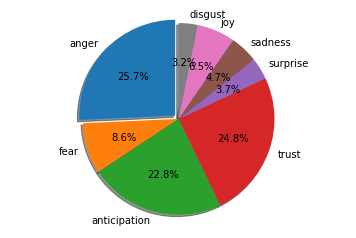

In [31]:
global_emotion = [2640, 881, 2343, 2547, 382, 481, 663, 327]
emotion_pie_chart(global_emotion)

In [17]:
# we will cluster by emotion now
# if <categories> has E emotions, each tweet will be a vector v of length E
# for i < E, v[i] = {# of words associated with emotion categories["emotion"][i]}
mat = []
# at the cost of some temporary memory, make this processing faster
# cache[word] = i, if the word correspondes to the coordinate i of the vector,
# as per the comment above; cache[word] = -1 if the word has been processed BUT
# corresponds to no emotion
cache = {}
emotions = categories["emotion"]
E = len(emotions)
global_emotion = [0 for i in range(E)]
for tweet in tweets:
    vec = [0 for i in range(E)]
    for word in tweet:
        idx = cache.get(word, None)
        if idx is not None and idx > -1:
            vec[idx] += 1
            global_emotion[idx] += 1
        else:
            # is this word in our lexicon data base?
            p = sentiment_lexicons.loc[word == sentiment_lexicons.word]
            if len(p) == 0:
                cache[word] = -1
            else:
                emot = p.loc[p.index[0], "emotion"]
                idx = -1 if emot not in emotions else emotions.index(emot)
                cache[word] = idx
                if idx > -1:
                    vec[idx] += 1
                    global_emotion[idx] += 1
    mat.append(vec)
emotion_pie_chart(global_emotion)

[2640, 881, 2343, 2547, 382, 481, 663, 327]


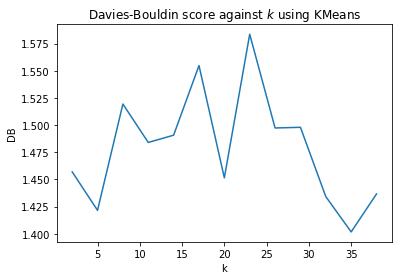

In [41]:
# apply the KMeans algorithm to the reduced data for different values of K
K = range(2,40,3)
DB = np.zeros_like(K).astype(float)
for i, k in enumerate(K):
    kmeans = KMeans(n_clusters = k, random_state=13032019).fit(mat)
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, kmeans.labels_)
k_opt = K[np.argmin(DB)]
plt.plot(K,DB)
plt.xlabel('k')
plt.ylabel('DB')
plt.title(f'Davies-Bouldin score against $k$ using KMeans')
plt.show()

### KMeans with 5 clusters

[1132, 494, 306, 437, 666]
We have 12967 words, of which 3244 are unique
[('anticipation', 0.30035335689045406), ('trust', 0.3003533568904472), ('joy', 0.16696113074204844), ('fear', 0.1660777385158994), ('sadness', 0.1148409893992926), ('anger', 0.08038869257948478), ('surprise', 0.07155477031802197), ('disgust', 0.05035335689045801)]


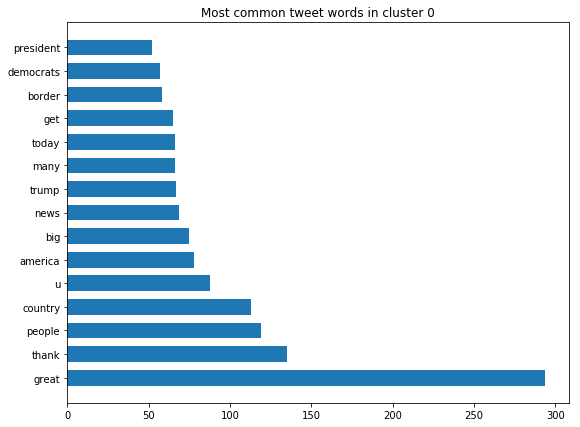

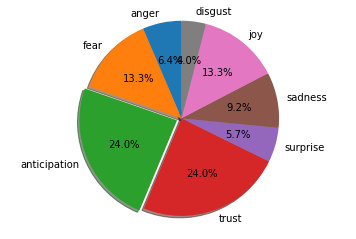

502 - Landing in Montana now - at least everybody admits that my lines and crowds are far bigger than Barack Obama’s... https://t.co/PCibGjS209
1255 - https://t.co/3PAVDdfJJr
804 - https://t.co/k2bOxapRtR
1672 - Joint Press Conference from Helsinki, Finland: https://t.co/fadLMDuGiY
771 - PROMISES MADE, PROMISES KEPT! https://t.co/2lk8Fjspe4
----------------------------------------
We have 10366 words, of which 2948 are unique
[('trust', 2.578947368421037), ('anticipation', 0.7732793522267205), ('anger', 0.548582995951419), ('fear', 0.34412955465587086), ('joy', 0.28340080971659953), ('surprise', 0.20040485829959565), ('sadness', 0.14574898785425103), ('disgust', 0.10728744939271258)]


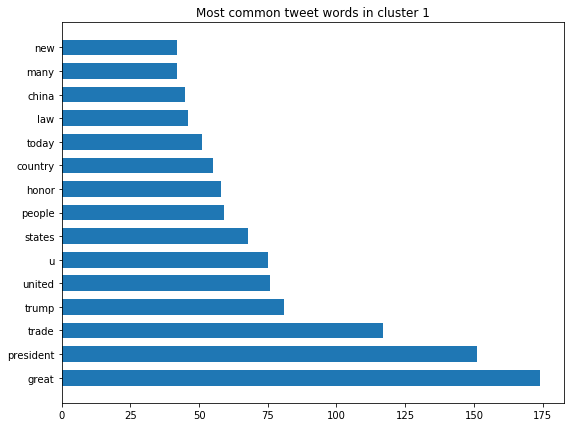

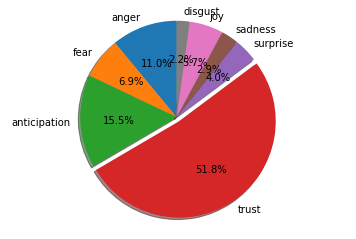

2703 - From Bush 1 to present, our Country has lost more than 55,000 factories, 6,000,000 manufacturing jobs and accumulated Trade Deficits of more than 12 Trillion Dollars. Last year we had a Trade Deficit of almost 800 Billion Dollars. Bad Policies &amp; Leadership. Must WIN again!  #MAGA
240 - I am glad that my friend @EmmanuelMacron and the protestors in Paris have agreed with the conclusion I reached two years ago. The Paris Agreement is fatally flawed because it raises the price of energy for responsible countries while whitewashing some of the worst polluters....
789 - Walker Stapleton is running as the highly respected Republican Candidate for Governor of the Great State of Colorado. His credentials and talents are impeccable. He has my complete and total Endorsement!
2341 - A Rigged System - They don’t want to turn over Documents to Congress. What are they afraid of? Why so much redacting? Why such unequal “justice?” At some point I will have no choice but to use the powers gr

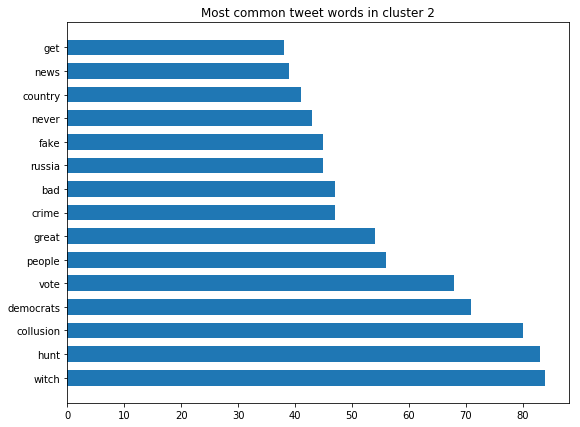

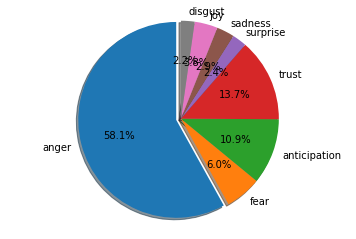

335 - ....and Safety at the Border, or anywhere else. They know nothing about it and are making our Country unsafe. Our great Law Enforcement professionals MUST BE ALLOWED TO DO THEIR JOB! If not there will be only bedlam, chaos, injury and death. We want the Constitution as written!
2190 - Crippling loopholes in our laws have enabled MS-13 gang members and other criminals to infiltrate our communities - and Democrats in Congress REFUSE to close these loopholes, including the disgraceful practice known as Catch-and-Release. Democrats must abandon their resistance... https://t.co/VkMCIzwt8v
2201 - Look how things have turned around on the Criminal Deep State. They go after Phony Collusion with Russia, a made up Scam, and end up getting caught in a major SPY scandal the likes of which this country may never have seen before! What goes around, comes around!
1965 - The sleazy New York Democrats, and their now disgraced (and run out of town) A.G. Eric Schneiderman, are doing everything they

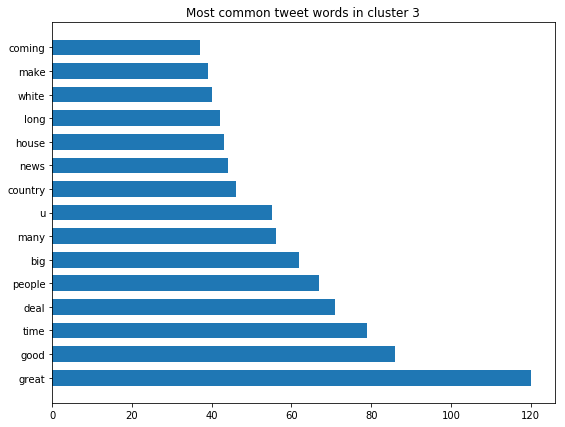

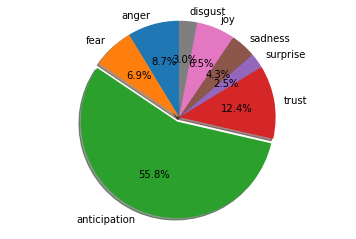

1185 - White House Counsel Don McGahn will be leaving his position in the fall, shortly after the confirmation (hopefully) of Judge Brett Kavanaugh to the United States Supreme Court. I have worked with Don for a long time and truly appreciate his service!
2368 - Just had a long and very good talk with President Moon of South Korea. Things are going very well, time and location of meeting with North Korea is being set. Also spoke to Prime Minister Abe of Japan to inform him of the ongoing negotiations.
1746 - ...on Monday assume duties as the acting Administrator of the EPA. I have no doubt that Andy will continue on with our great and lasting EPA agenda. We have made tremendous progress and the future of the EPA is very bright!
2381 - After a furious year of missile launches and Nuclear testing, a historic meeting between North and South Korea is now taking place. Good things are happening, but only time will tell!
963 - Happy 71st Birthday to our GREAT United States Air Force! https:

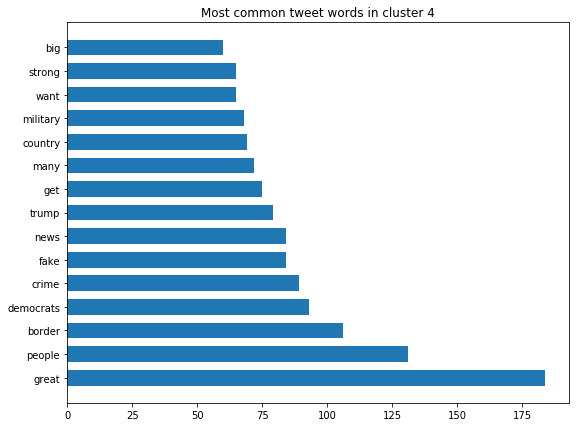

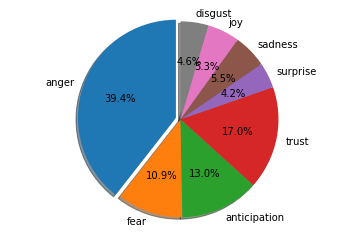

107 - The Trump Foundation has done great work and given away lots of money, both mine and others, to great charities over the years - with me taking NO fees, rent, salaries etc. Now, as usual, I am getting slammed by Cuomo and the Dems in a long running civil lawsuit started by.....
2477 - Attorney Client privilege is now a thing of the past. I have many (too many!) lawyers and they are probably wondering when their offices, and even homes, are going to be raided with everything, including their phones and computers, taken. All lawyers are deflated and concerned!
167 - ....stated that I did nothing wrong with respect to campaign finance laws, if they even apply, because this was not campaign finance. Cohen was guilty on many charges unrelated to me, but he plead to two campaign charges which were not criminal and of which he probably was not...
2800 - ....cameras running. Another False Accusation. Why doesn’t @washingtonpost report the story of the women taking money to make up storie

In [65]:
# apply the KMeans algorithm to the data,
# even though 35 gave the smallest DB, stick with 5 because that is
# 7x smaller
kmeans = KMeans(5, random_state=10032019).fit(mat)
sk_clusters = [[] for i in range(max(kmeans.labels_+1))]
for idx, lbl in enumerate(kmeans.labels_):
    sk_clusters[lbl].append(idx)
    
print(list(map(len, sk_clusters)))

def callback(k):
    center = kmeans.cluster_centers_[k]
    # order the emotions by most present to least present
    orders = [(emotions[i], center[i]) for i in range(len(emotions))]
    orders.sort(key=lambda t: t[1], reverse=True)
    print(orders)
    emotion_pie_chart(center)

random.seed(112233)
# take some random tweets from every cluster
explore_clusters(sk_clusters, callback)

### KMeans with 20 clusters

[136, 188, 362, 223, 60, 106, 157, 67, 127, 92, 402, 139, 183, 83, 145, 139, 85, 159, 137, 45]
[('trust', 1.4338235294117647), ('joy', 1.3088235294117665), ('anticipation', 0.5220588235294117), ('anger', 0.35294117647058754), ('fear', 0.17647058823529393), ('disgust', 0.11764705882352942), ('sadness', 0.11029411764705875), ('surprise', 0.08823529411764712)]


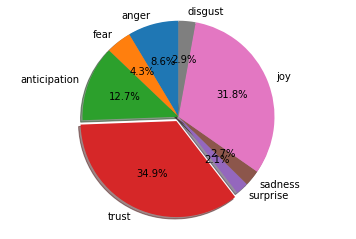

2526 - The Washington Post is far more fiction than fact. Story after story is made up garbage - more like a poorly written novel than good reporting. Always quoting sources (not names), many of which don’t exist. Story on John Kelly isn’t true, just another hit job!
2674 - Rasmussen and others have my approval ratings at around 50%, which is higher than Obama, and yet the political pundits love saying my approval ratings are “somewhat low.” They know they are lying when they say it. Turn off the show - FAKE NEWS!
1745 - It was my great honor to join proud, hardworking American Patriots in Montana tonight. I love you - thank you! #MAGA https://t.co/475ct7hW3D
1369 - Lou Dobbs: “This cannot go forward...this Special Counsel with all of his conflicts, with his 17 Angry Democrats, without any evidence of collusion by the Trump Campaign and Russia. The Dems are the ones who should be investigated.” Thank you Lou, so true!
1073 - So true! “Mr. Trump remains the single most popular figure in

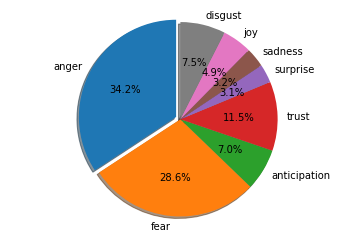

2719 - We are on the losing side of almost all trade deals. Our friends and enemies have taken advantage of the U.S. for many years. Our Steel and Aluminum industries are dead. Sorry, it’s time for a change! MAKE AMERICA GREAT AGAIN!
2955 - Just signed 702 Bill to reauthorize foreign intelligence collection. This is NOT the same FISA law that was so wrongly abused during the election. I will always do the right thing for our country and put the safety of the American people first!
1928 - Children are being used by some of the worst criminals on earth as a means to enter our country. Has anyone been looking at the Crime taking place south of the border. It is historic, with some countries the most dangerous places in the world. Not going to happen in the U.S.
2414 - James Comey’s Memos are Classified, I did not Declassify them. They belong to our Government! Therefore, he broke the law! Additionally, he totally made up many of the things he said I said, and he is already a proven liar a

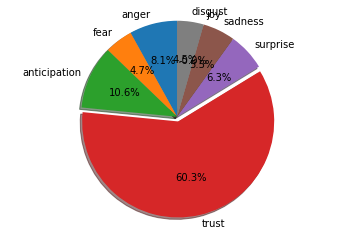

3009 - The Democrats seem intent on having people and drugs pour into our country from the Southern Border, risking thousands of lives in the process. It is my duty to protect the lives and safety of all Americans. We must build a Great Wall, think Merit and end Lottery &amp; Chain. USA!
2195 - Big legislation will be signed by me shortly. After many years, RIGHT TO TRY and big changes to DODD FRANK.
6 - For those that naively ask why didn’t the Republicans get approval to build the Wall over the last year, it is because IN THE SENATE WE NEED 10 DEMOCRAT VOTES, and they will gives us “NONE” for Border Security! Now we have to do it the hard way, with a Shutdown. Too bad! @FoxNews
1688 - The stories you heard about the 12 Russians yesterday took place during the Obama Administration, not the Trump Administrations. Why didn’t they do something about it, especially when it was reported that President Obama was informed by the FBI in September, before the Election?
561 - Congresswoman @cat

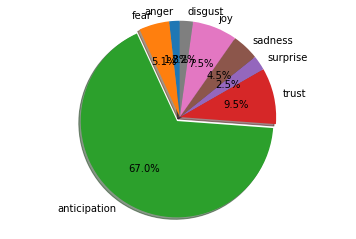

127 - Anytime you hear a Democrat saying that you can have good Border Security without a Wall, write them off as just another politician following the party line. Time for us to save billions of dollars a year and have, at the same time, far greater safety and control!
1685 - So funny! I just checked out Fake News CNN, for the first time in a long time (they are dying in the ratings), to see if they covered my takedown yesterday of Jim Acosta (actually a nice guy). They didn’t! But they did say I already lost in my meeting with Putin. Fake News......
620 - The New York Times has a new Fake Story that now the Russians and Chinese (glad they finally added China) are listening to all of my calls on cellphones. Except that I rarely use a cellphone, &amp; when I do it’s government authorized. I like Hard Lines. Just more made up Fake News!
1742 - Thanks to REPUBLICAN LEADERSHIP, America is WINNING AGAIN - and America is being RESPECTED again all over the world. Because we are finally putti

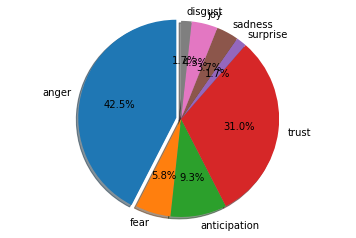

477 - So funny to see the CNN Fake Suppression Polls and false rhetoric. Watch for real results Tuesday. We are lucky CNN’s ratings are so low. Don’t fall for the Suppression Game. Go out &amp; VOTE. Remember, we now have perhaps the greatest Economy (JOBS) in the history of our Country!
1219 - Over 90% approval rating for your all time favorite (I hope) President within the Republican Party and 52% overall. This despite all of the made up stories by the Fake News Media trying endlessly to make me look as bad and evil as possible. Look at the real villains please!
329 - Really good Criminal Justice Reform has a true shot at major bipartisan support. @senatemajldr Mitch McConnell and @senchuckschumer have a real chance to do something so badly needed in our country. Already past, with big vote, in House. Would be a major victory for ALL!
1475 - Marsha Blackburn had a BIG win last night in the Tennessee primary for U.S. Senate. She is an outstanding person &amp; great supporter of mine. 

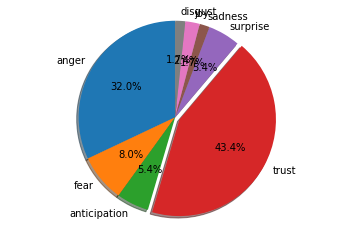

1723 - Tonight, it was my honor and privilege to nominate Judge Brett Kavanaugh to the United States Supreme Court. #SCOTUS https://t.co/97clc9zifm
1743 - Every day, the brave men and women of ICE are liberating communities from savage gangs like MS-13. We will NOT stand for these vile Democrat smears in law enforcement. We will always stand proudly with the BRAVE HEROES of ICE and BORDER PATROL!
1720 - Thank you to all of my great supporters, really big progress being made. Other countries wanting to fix crazy trade deals. Economy is ROARING. Supreme Court pick getting GREAT REVIEWS. New Poll says Trump, at over 90%, is the most popular Republican in history of the Party. Wow!
839 - Mexico, Canada and the United States are a great partnership and will be a very formidable trading force. We will now, because of the USMCA, work very well together. Great Spirit!
2761 - “Congressman Schiff omitted and distorted key facts” @FoxNews  So, what else is new. He is a total phony!
--------------

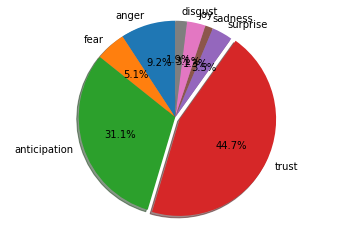

2208 - .@AsaHutchinson, the great Governor of Arkansas, is in a primary tomorrow. He has done an incredible job with a focus on lower taxes, border security, and crime prevention. Asa loves our military and our veterans. I fully endorse Asa for Governor!
1060 - ...its commitment to denuclearize.” @FoxNews  This is a big and very positive statement from North Korea. Thank you To Chairman Kim. We will both prove everyone wrong! There is nothing like good dialogue from two people that like each other! Much better than before I took office.
155 - China just announced that their economy is growing much slower than anticipated because of our Trade War with them. They have just suspended U.S. Tariff Hikes. U.S. is doing very well. China wants to make a big and very comprehensive deal. It could happen, and rather soon!
1587 - Every time I see a weak politician asking to stop Trade talks or the use of Tariffs to counter unfair Tariffs, I wonder, what can they be thinking? Are we just going to c

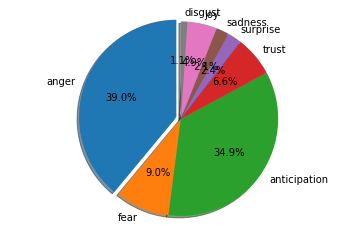

1500 - Paul Manafort worked for Ronald Reagan, Bob Dole and many other highly prominent and respected political leaders. He worked for me for a very short time. Why didn’t government tell me that he was under investigation. These old charges have nothing to do with Collusion - a Hoax!
2159 - The Failing @nytimes quotes “a senior White House official,” who doesn’t exist, as saying “even if the meeting were reinstated, holding it on June 12 would be impossible, given the lack of time and the amount of planning needed.” WRONG AGAIN! Use real people, not phony sources.
1893 - What is the purpose of the House doing good immigration bills when you need 9 votes by Democrats in the Senate, and the Dems are only looking to Obstruct (which they feel is good for them in the Mid-Terms). Republicans must get rid of the stupid Filibuster Rule-it is killing you!
1160 - Kevin Stitt ran a great winning campaign against a very tough opponent in Oklahoma. Kevin is a very successful businessman who will b

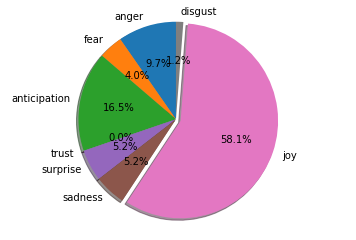

712 - Hard to believe that with thousands of people from South of the Border, walking unimpeded toward our country in the form of large Caravans, that the Democrats won’t approve legislation that will allow laws for the protection of our country. Great Midterm issue for Republicans!
674 - Beautiful evening in Mesa, Arizona with GREAT PATRIOTS - thank you! https://t.co/0pWiwCq4MH #MAGARally????replay: https://t.co/6vHEaB37VH https://t.co/pHmU6pMKh7
539 - Paul Ryan should be focusing on holding the Majority rather than giving his opinions on Birthright Citizenship, something he knows nothing about! Our new Republican Majority will work on this, Closing the Immigration Loopholes and Securing our Border!
1902 - So sorry, people wanting to get into the already packed arena - I LOVE YOU ALL! https://t.co/PFvXrsvgkA
1116 - “Pledge to America’s Workers” https://t.co/wbGZU6oi9G
----------------------------------------
[('anticipation', 3.6086956521739086), ('trust', 1.1630434782608685), ('anger

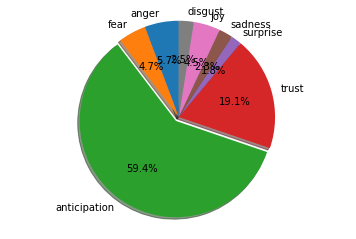

430 - In the 2016 Election I was winning by so much in Florida that Broward County, which was very late with vote tabulation and probably getting ready to do a “number,” couldn’t do it because not enough people live in Broward for them to falsify a victory!
2409 - ....We are a long way from conclusion on North Korea, maybe things will work out, and maybe they won’t - only time will tell....But the work I am doing now should have been done a long time ago!
1652 - 3.4 million jobs created since our great Election Victory - far greater than ever anticipated, and only getting better as new and greatly improved Trade Deals start coming to fruition!
1758 - Thank you, @WVGovernor Jim Justice, for that warm introduction. Tonight, it was my great honor to attend the “Greenbrier Classic – Salute to Service Dinner” in West Virginia! God Bless our Veterans. God Bless America - and HAPPY INDEPENDENCE DAY TO ALL! https://t.co/V35qvCN8m6
2417 - Heading to the Southern White House to watch the Funeral

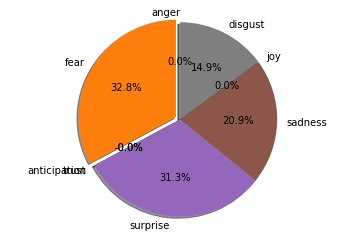

1568 - Thank you @U_S_Steel and Granite City, Illinois! https://t.co/6RsUvGF6rg
1692 - ???????? https://t.co/CwnBfe3smd
2653 - Thank you for hosting! #MAGA https://t.co/9pHH60DVlX
1399 - .@GovMikeHuckabee “Your paycheck is bigger, your pension is stronger.” @foxandfriends  Unemployment numbers are better than they have been in 50 years, &amp; perhaps ever. Our country is booming like never before - and it will get even better! Many companies moving back to the U.S.A.
2944 - Eric Trump on @JudgeJeanine on @FoxNews now!
----------------------------------------
[('anger', 2.2014388489208656), ('trust', 0.7769784172661871), ('anticipation', 0.5539568345323738), ('disgust', 0.17985611510791327), ('sadness', 0.1151079136690647), ('joy', 0.10791366906474836), ('surprise', 0.10071942446043175), ('fear', 0.043165467625899706)]


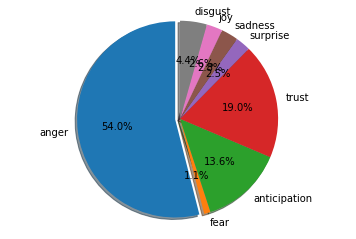

2454 - Slippery James Comey, the worst FBI Director in history, was not fired because of the phony Russia investigation where, by the way, there was NO COLLUSION (except by the Dems)!
1914 - Homeland Security @SecNielsen did a fabulous job yesterday at the press conference explaining security at the border and for our country, while at the same time recommending changes to obsolete &amp; nasty laws, which force family separation. We want “heart” and security in America!
1378 - ....guy was corrupt and had anti-Trump animus. Strzok and others at the FBI should be criminally investigated for the way the conducted this investigation. Instead, Mueller is pretending nothing went wrong. He used Strzok, he used the Clinton DNC Dossier...the whole thing....
3008 - Reason I canceled my trip to London is that I am not a big fan of the Obama Administration having sold perhaps the best located and finest embassy in London for “peanuts,” only to build a new one in an off location for 1.2 billion dol

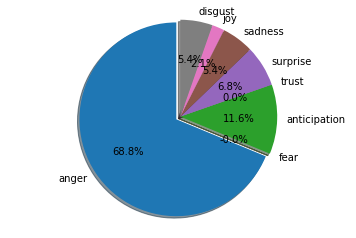

590 - Martha McSally is a great warrior, her opponent a Nancy Pelosi Wacko! https://t.co/QEUdPWDDud
2496 - On Yom HaShoah we remember the six million Jews slaughtered in the Holocaust. With each passing year, our duty to remember this atrocity increases as we pledge #NeverAgain. #HolocaustRemembranceDay https://t.co/tyga4VtjLT
2631 - A total WITCH HUNT with massive conflicts of interest!
1549 - Democrats, who want Open Borders and care little about Crime, are incompetent, but they have the Fake News Media almost totally on their side!
2219 - The Witch Hunt finds no Collusion with Russia - so now they’re looking at the rest of the World. Oh’ great!
----------------------------------------
[('sadness', 1.7469879518072315), ('anger', 0.8313253012048192), ('trust', 0.6506024096385543), ('anticipation', 0.6506024096385542), ('fear', 0.25301204819277107), ('surprise', 0.1566265060240964), ('joy', 0.13253012048192753), ('disgust', 0.06024096385542171)]


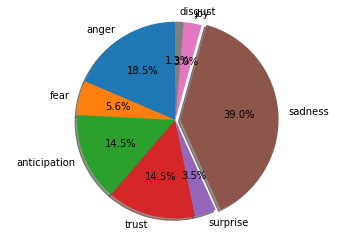

1142 - There is no political necessity to keep Canada in the new NAFTA deal. If we don’t make a fair deal for the U.S. after decades of abuse, Canada will be out. Congress should not interfere w/ these negotiations or I will simply terminate NAFTA entirely &amp; we will be far better off...
2377 - Kanye West has performed a great service to the Black Community - Big things are happening and eyes are being opened for the first time in Decades - Legacy Stuff! Thank you also to Chance and Dr. Darrell Scott, they really get it (lowest Black &amp; Hispanic unemployment in history).
2181 - I have decided to terminate the planned Summit in Singapore on June 12th. While many things can happen and a great opportunity lies ahead potentially, I believe that this is a tremendous setback for North Korea and indeed a setback for the world... https://t.co/jT0GfxT0Lc
2157 - This whole Russia Probe is Rigged. Just an excuse as to why the Dems and Crooked Hillary lost the Election and States that haven’

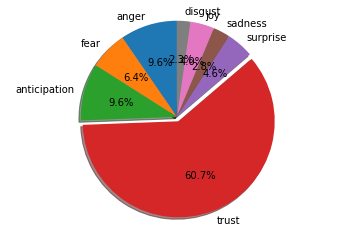

2765 - BIG CPAC STRAW POLL RESULTS: 93% APPROVE OF THE JOB PRESIDENT TRUMP IS DOING (Thank you!). 50% say President Trump should Tweet MORE or SAME (funny!). 79% say Republicans in Congress should do a better job of working with President Trump (starting to happen).
1859 - Heading to Nevada to talk trade and immigration with supporters. Country’s economy is stronger than ever before with numbers that are getting better by the week. Tremendous potential, and trade deals are coming along well.
2343 - “The questions are an intrusion into the President’s Article 2  powers under the Constitution to fire any Executive Branch Employee...what the President was thinking is an outrageous.....as to the President’s unfettered power to fire anyone...” Joe Digenova, former US Attorney
3025 - Today, it was my great honor to welcome Prime Minister Erna Solberg of Norway to the @WhiteHouse - a great friend and ally of the United States! Joint press conference: https://t.co/qWR1BhfQZI https://t.co/PJvwz

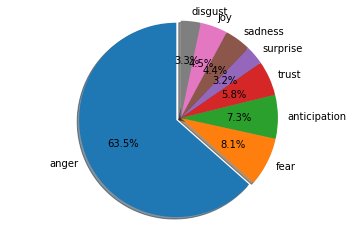

1588 - “The Russia Hoax, The Illicit Scheme To Clear Hillary Clinton &amp; Frame Donald Trump” is a Hot Seller, already Number One! More importantly, it is a great book that everyone is talking about. It covers the Rigged Witch Hunt brilliantly. Congratulations to Gregg Jarrett!
1660 - The Democrats want to abolish ICE, which will mean more crime in our country. I want to give ICE a big cheer! Vote Republican in November.
1848 - .@ClayHiggins18 has been a great help to me on Cutting Taxes, creating great new healthcare programs at low cost, fighting for Border Security, our Military and are Vets. He is tough on Crime and has my full Endorsement. The Great State of Louisiana, we want Clay!
478 - I need @claudiatenney of #NY22 to be re-elected in order to get our big plans moving. Her opponent would be a disaster. Nobody works harder than Claudia, and she is a producer. I look forward to working together with her - she has my Strongest Endorsement! Vote Claudia!
2051 - The Fake News Medi

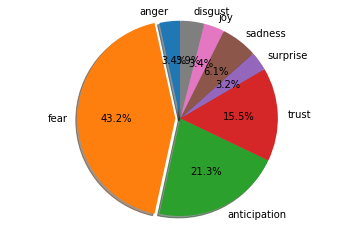

1525 - Congratulations to Judge Jeanine on the tremendous success of her new #1 best-selling book, “Liars, Leakers, and Liberals – The Case Against the Anti-Trump Conspiracy!”
220 - Arizona, together with our Military and Border Patrol, is bracing for a massive surge at a NON-WALLED area. WE WILL NOT LET THEM THROUGH. Big danger. Nancy and Chuck must approve Boarder Security and the Wall!
399 - By the way, when the helicopter couldn’t fly to the first cemetery in France because of almost zero visibility, I suggested driving. Secret Service said NO, too far from airport &amp; big Paris shutdown. Speech next day at American Cemetary in pouring rain! Little reported-Fake News!
2628 - AUSTIN BOMBING SUSPECT IS DEAD. Great job by law enforcement and all concerned!
959 - Today, I took action to strengthen our Nation’s defenses against biological threats. For the first time in history, the Federal Government has a National Biodefense Strategy to address the FULL RANGE of biological threats! h

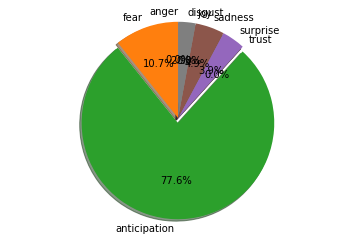

951 - “North Korea recommits to denuclearization - we’ve come a long way.” @FoxNews
1987 - Here is the video, “A Story of Opportunity” that I shared with Kim Jong-un at the #SingaporeSummit
??https://t.co/43oOci4jvo https://t.co/xBKFkDLtj7
2115 - Very good meetings with North Korea.
1986 - It's time for another #MAGA rally. Join me in Duluth, Minnesota on Wednesday, June 20th at 6:30pm!
Tickets?https://t.co/mhhJB9erdd https://t.co/T6eXenoSxT
713 - “Network News gave Zero coverage to the Big Day the Stock Market had yesterday.” @foxandfriends
----------------------------------------
[('anticipation', 1.744525547445257), ('anger', 1.204379562043795), ('trust', 0.7299270072992702), ('disgust', 0.18978102189781015), ('surprise', 0.1751824817518249), ('fear', 0.15328467153284678), ('joy', 0.13868613138686148), ('sadness', 0.08759124087591257)]


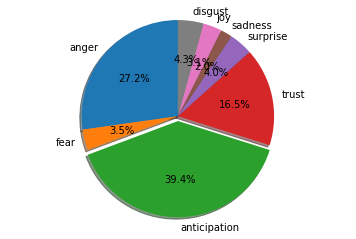

52 - We signed two pieces of major legislation this week, Criminal Justice Reform and the Farm Bill. These are two Big Deals, but all the Fake News Media wants to talk about is “the mistake” of bringing our young people back home from the Never Ending Wars. It all began 19 years ago!
2126 - With the #RightToTry Law I signed today, patients with life threatening illnesses will finally have access to experimental treatments that could improve or even cure their conditions. These are experimental treatments and products that have shown great promise... https://t.co/FIUwhpUpoL
2194 - There will be big news coming soon for our great American Autoworkers. After many decades of losing your jobs to other countries, you have waited long enough!
1396 - Wacky Omarosa, who got fired 3 times on the Apprentice, now got fired for the last time. She never made it, never will. She begged me for a job, tears in her eyes, I said Ok. People in the White House hated her. She was vicious, but not smart. I w

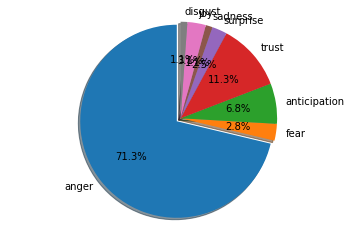

876 - Judge Kavanaugh showed America exactly why I nominated him. His testimony was powerful, honest, and riveting. Democrats’ search and destroy strategy is disgraceful and this process has been a total sham and effort to delay, obstruct, and resist. The Senate must vote!
1293 - Where’s the Collusion? They made up a phony crime called Collusion, and when there was no Collusion they say there was Obstruction (of a phony crime that never existed). If you FIGHT BACK or say anything bad about the Rigged Witch Hunt, they scream Obstruction!
463 - A vote for Claire McCaskill is a vote for Schumer, Pelosi, Waters, and their socialist agenda. Claire voted IN FAVOR of deadly Sanctuary Cities - she would rather protect criminal aliens than American citizens, which is why she needs to be voted out of office. Vote @HawleyMO! https://t.co/tn2zsEWQJ5
305 - The Phony Witch Hunt continues, but Mueller and his gang of Angry Dems are only looking at one side, not the other. Wait until it comes out how 

In [68]:
# apply the KMeans algorithm to the data,
# even though 35 gave the smallest DB, stick with 5 because that is
# 7x smaller
kmeans = KMeans(20, random_state=10032019).fit(mat)
sk_clusters = [[] for i in range(max(kmeans.labels_+1))]
for idx, lbl in enumerate(kmeans.labels_):
    sk_clusters[lbl].append(idx)
    
print(list(map(len, sk_clusters)))

random.seed(1133)
# take some random tweets from every cluster
for k, cluster in enumerate(sk_clusters):
    center = kmeans.cluster_centers_[k]
    # order the emotions by most present to least present
    orders = [(emotions[i], center[i]) for i in range(len(emotions))]
    orders.sort(key=lambda t: t[1], reverse=True)
    print(orders)
    emotion_pie_chart(center/0.1)
    some_tweet_idx = random.sample(cluster, 5)
    for idx in some_tweet_idx:
        print(str(idx) + " - " + (text_tweets["text"][idx]))
    print("-"*40)

### KMeans with 35 clusters

[239, 78, 60, 128, 462, 67, 50, 15, 27, 42, 166, 65, 96, 61, 82, 159, 115, 149, 68, 73, 41, 83, 50, 60, 29, 35, 75, 55, 137, 38, 23, 47, 31, 88, 41]
[('trust', 1.2008368200836825), ('sadness', 0.1087866108786614), ('fear', 0.09623430962343044), ('surprise', 0.0920502092050209), ('joy', 0.08368200836820125), ('disgust', 0.08368200836820086), ('anger', 2.55351295663786e-15), ('anticipation', -1.887379141862766e-15)]


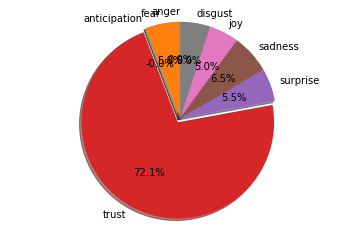

1862 - .@VP Pence is heading to Pittsburgh, Pennsylvania where we have both strongly endorsed one of the finest men around, Congressman Keith @RothfusForPA. He is running against #LambTheSham, who is telling...
2655 - Five of our incredible @Cabinet Secretaries are testifying on the Hill this morning on the need to rebuild our Nation’s crumbling infrastructure. We need to build FAST &amp; we need to build for our FUTURE. Thank you @SenateCommerce for hosting this hearing! #InfrastructureInAmerica
1530 - It is my great honor to welcome Prime Minister @GiuseppeConteIT of Italy to the @WhiteHouse! Join us at 2:00pmE for our joint press conference: https://t.co/XAchZ3zUSe https://t.co/5t4QVsKKqH
1367 - Great Republican election results last night. So far we have the team we want. 8 for 9 in Special Elections. Red Wave!
154 - ....Kim Jong Un sees it better than anyone and will fully take advantage of it for his people. We are doing just fine!
----------------------------------------
[('anti

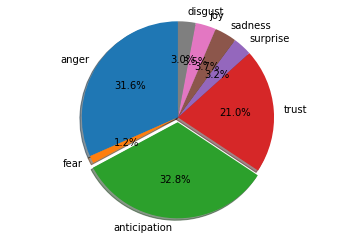

2126 - With the #RightToTry Law I signed today, patients with life threatening illnesses will finally have access to experimental treatments that could improve or even cure their conditions. These are experimental treatments and products that have shown great promise... https://t.co/FIUwhpUpoL
788 - Despite so many positive events and victories, Media Reseach Center reports that 92% of stories on Donald Trump are negative on ABC, CBS and ABC. It is FAKE NEWS! Don’t worry, the Failing New York Times didn’t even put the Brett Kavanaugh victory on the Front Page yesterday-A17!
2769 - Armed Educators (and trusted people who work within a school) love our students and will protect them. Very smart people. Must be firearms adept &amp; have annual training. Should get yearly bonus. Shootings will not happen again - a big &amp; very inexpensive deterrent. Up to States.
1511 - The Fake News Media is going CRAZY! They are totally unhinged and in many ways, after witnessing first hand the damage 

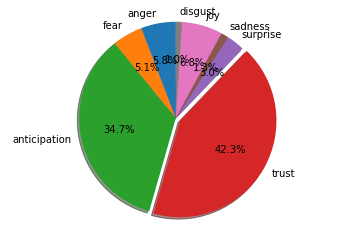

1124 - I see that John Kerry, the father of the now terminated Iran deal, is thinking of running for President. I should only be so lucky - although the field that is currently assembling looks really good - FOR ME!
1932 - “The highest level of bias I’ve ever witnessed in any law enforcement officer.” Trey Gowdy on the FBI’s own, Peter Strzok. Also remember that they all worked for Slippery James Comey and that Comey is best friends with Robert Mueller. A really sick deal, isn’t it?
866 - Late last night, our deadline, we reached a wonderful new Trade Deal with Canada, to be added into the deal already reached with Mexico. The new name will be The United States Mexico Canada Agreement, or USMCA. It is a great deal for all three countries, solves the many......
1539 - I would be willing to “shut down” government if the Democrats do not give us the votes for Border Security, which includes the Wall! Must get rid of Lottery, Catch &amp; Release etc. and finally go to system of Immigration

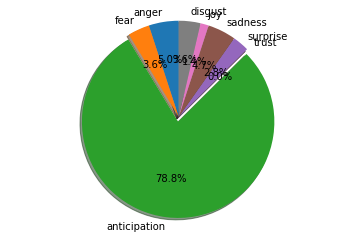

582 - Watching the Dodgers/Red Sox final innings. It is amazing how a manager takes out a pitcher who is loose &amp; dominating through almost 7 innings, Rich Hill of Dodgers, and brings in nervous reliever(s) who get shellacked. 4 run lead gone. Managers do it all the time, big mistake!
2416 - So funny, the Democrats have sued the Republicans for Winning. Now he R’s counter and force them to turn over a treasure trove of material, including Servers and Emails!
447 - I will be doing a news conference at The White House - 11:30 A.M. Will be discussing our success in the Midterms!
2994 - The Wall Street Journal stated falsely that I said to them “I have a good relationship with Kim Jong Un” (of N. Korea). Obviously I didn’t say that. I said “I’d have a good relationship with Kim Jong Un,” a big difference. Fortunately we now record conversations with reporters...
2919 - Heading back from a very exciting two days in Davos, Switzerland. Speech on America’s economic revival was well receive

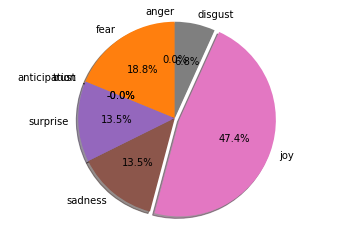

1248 - ...And according to Polls, would do even better today! https://t.co/NAzQOIFW6o
2386 - MAGA! https://t.co/jFf5ONASlv
1324 - The U.S. has more than double the growth rate than it had 18 months ago.
830 - Working hard, thank you! https://t.co/6HQVaEXH0I
707 - https://t.co/MadlgNheSe
----------------------------------------
[('anger', 1.4925373134328357), ('anticipation', 1.4626865671641796), ('fear', 1.26865671641791), ('disgust', 0.2238805970149254), ('joy', 0.19402985074626866), ('surprise', 0.08955223880597024), ('sadness', 0.08955223880597007), ('trust', 0.02985074626865558)]


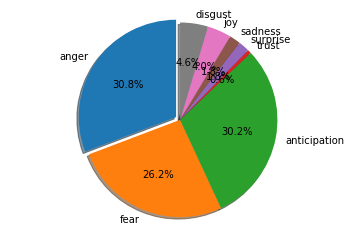

1735 - The Rigged Witch Hunt, originally headed by FBI lover boy Peter S (for one year) &amp; now, 13 Angry Democrats, should look into the missing DNC Server, Crooked Hillary’s illegally deleted Emails, the Pakistani Fraudster, Uranium One, Podesta &amp; so much more. It’s a Democrat Con Job!
98 - ....Russia, Iran, Syria &amp; many others are not happy about the U.S. leaving, despite what the Fake News says, because now they will have to fight ISIS and others, who they hate, without us. I am building by far the most powerful military in the world. ISIS hits us they are doomed!
1027 - We got A Pluses for our recent hurricane work in Texas and Florida (and did an unappreciated great job in Puerto Rico, even though an inaccessible island with very poor electricity and a totally incompetent Mayor of San Juan). We are ready for the big one that is coming!
268 - To the Great people of Alaska. You have been hit hard by a “big one.” Please follow the directions of the highly trained professio

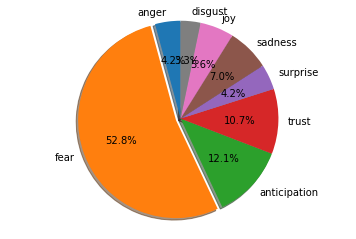

317 - Europe has to pay their fair share for Military Protection. The European Union, for many years, has taken advantage of us on Trade, and then they don’t live up to their Military commitment through NATO. Things must change fast!
2328 - Our Southern Border is under siege. Congress must act now to change our weak and ineffective immigration laws. Must build a Wall. Mexico, which has a massive crime problem, is doing little to help!
622 - Brandon Judd of the National Border Patrol Council is right when he says on @foxandfriends that the Democrat inspired laws make it tough for us to stop people at the Border. MUST BE CHANDED, but I am bringing out the military for this National Emergency. They will be stopped!
402 - On Trade, France makes excellent wine, but so does the U.S. The problem is that France makes it very hard for the U.S. to sell its wines into France, and charges big Tariffs, whereas the U.S. makes it easy for French wines, and charges very small Tariffs. Not fair, must c

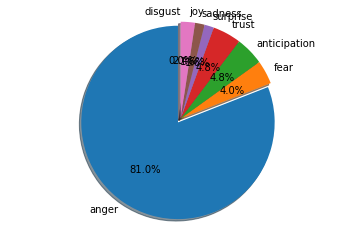

303 - ....terrible Gang of Angry Democrats. Look at their past, and look where they come from. The now $30,000,000 Witch Hunt continues and they’ve got nothing but ruined lives. Where is the Server? Let these terrible people go back to the Clinton Foundation and “Justice” Department!
1423 - This is an illegally brought Rigged Witch Hunt run by people who are totally corrupt and/or conflicted. It was started and paid for by Crooked Hillary and the Democrats. Phony Dossier, FISA disgrace and so many lying and dishonest people already fired. 17 Angry Dems? Stay tuned!
1293 - Where’s the Collusion? They made up a phony crime called Collusion, and when there was no Collusion they say there was Obstruction (of a phony crime that never existed). If you FIGHT BACK or say anything bad about the Rigged Witch Hunt, they scream Obstruction!
1936 - WITCH HUNT! There was no Russian Collusion. Oh, I see, there was no Russian Collusion, so now they look for obstruction on the no Russian Collusion. The

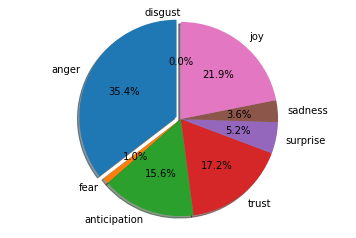

884 - The Democrats are playing a high level CON GAME in their vicious effort to destroy a fine person. It is called the politics of destruction. Behind the scene the Dems are laughing. Pray for Brett Kavanaugh and his family!
1380 - ....such wonderful and powerful things about me - a true Champion of Civil Rights - until she got fired. Omarosa had Zero credibility with the Media (they didn’t want interviews) when she worked in the White House. Now that she says bad about me, they will talk to her. Fake News!
477 - So funny to see the CNN Fake Suppression Polls and false rhetoric. Watch for real results Tuesday. We are lucky CNN’s ratings are so low. Don’t fall for the Suppression Game. Go out &amp; VOTE. Remember, we now have perhaps the greatest Economy (JOBS) in the history of our Country!
2666 - The Economy is raging, at an all time high, and is set to get even better. Jobs and wages up. Vote for Rick Saccone and keep it going!
2595 - I am very pleased to welcome the opioid memoria

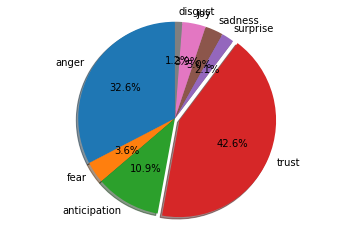

1461 - ....Tariffs will make our country much richer than it is today. Only fools would disagree. We are using them to negotiate fair trade deals and, if countries are still unwilling to negotiate, they will pay us vast sums of money in the form of Tariffs. We win either way......
315 - .@60Minutes did a phony story about child separation when they know we had the exact same policy as the Obama Administration. In fact a picture of children in jails was used by other Fake Media to show how bad (cruel) we are, but it was in 2014 during O years. Obama separated....
2371 - Allegations made by Senator Jon Tester against Admiral/Doctor Ron Jackson are proving false. The Secret Service is unable to confirm (in fact they deny) any of the phony Democrat charges which have absolutely devastated the wonderful Jackson family. Tester should resign. The.....
3028 - The fact that Sneaky Dianne Feinstein, who has on numerous occasions stated that collusion between Trump/Russia has not been found, woul

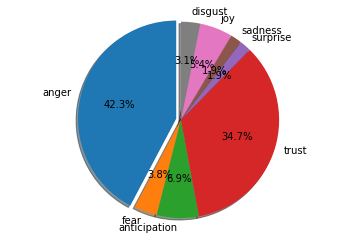

2492 - America’s greatest treasure is our people – and my Administration HEARS YOUR VOICE and HAS YOUR BACK. We are fighting to give every American a future of dignity, purpose and pride. AMERICAN SPIRIT is back! #TaxCuts https://t.co/oSGZe0irBf
1362 - Jeff Johnson of Minnesota had a big night in winning the Republican nomination for Governor against a very strong and well known opponent! Thanks for all of the support you showed me. You have my complete and total Endorsement. You will win in November!
1843 - I have tried to stay uninvolved with the Department of Justice and FBI (although I do not legally have to), because of the now totally discredited and very expensive Witch Hunt currently going on. But you do have to ask why the DOJ &amp; FBI aren’t giving over requested documents?
547 - Melania and I were treated very nicely yesterday in Pittsburgh. The Office of the President was shown great respect on a very sad and solemn day. We were treaty so warmly. Small protest was not seen

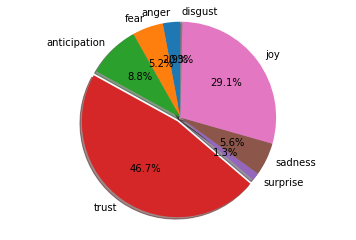

2493 - Thank you to all of the American workers who travelled here today! This event is dedicated to YOU: the hardworking Americans who make this nation run. You love your country, you provide for your family, you have PRIDE in your work and you cherish our GREAT AMERICAN FLAG! #TaxCuts https://t.co/RwaLpCRPh5
2977 - ....we need to keep America safe, including moving away from a random chain migration and lottery system, to one that is merit-based. https://t.co/7PtoSFK1n2
2345 - Today, it was my great honor to thank and welcome heroic crew members and passengers of Southwest Airlines Flight 1380 at the @WhiteHouse! https://t.co/fYYgWToddi
2378 - Please do not forget the great help that my good friend, President Xi of China, has given to the United States, particularly at the Border of North Korea. Without him it would have been a much longer, tougher, process!
601 - I would like to begin today’s remarks by providing an update on the packages and devices that have been mailed to high-pr

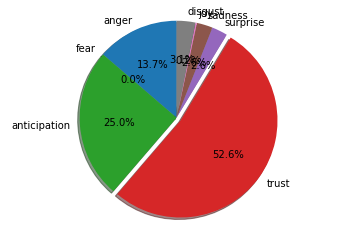

982 - Watch @MariaBartiromo at 6:00 P.M. on @FoxBusiness. Russian Hoax the big topic! Mainstream Media, often referred to as the Fake News Media, hates to discuss the real facts!
864 - ....deficiencies and mistakes in NAFTA, greatly opens markets to our Farmers and Manufacturers, reduces Trade Barriers to the U.S. and will bring all three Great Nations together in competition with the rest of the world. The USMCA is a historic transaction!
615 - ...I agree with their stance 100%, and the United States is likewise taking a very hard line on illegal immigration. The Prime Minister is working very hard on the economy of Italy - he will be successful!
1600 - Tariffs are the greatest! Either a country which has treated the United States unfairly on Trade negotiates a fair deal, or it gets hit with Tariffs. It’s as simple as that - and everybody’s talking! Remember, we are the “piggy bank” that’s being robbed. All will be Great!
2474 - Comey drafted the Crooked Hillary exoneration long befor

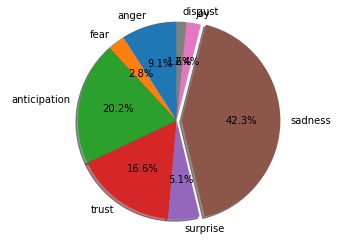

1820 - Tremendous win for Congressman Dan Donovan. You showed great courage in a tough race! New York, and my many friends on Staten Island, have elected someone they have always been very proud of. Congratulations!
1349 - “WE’RE NOT GONG TO MAKE AMERICA GREAT AGAIN, IT WAS NEVER THAT GREAT.”  Can you believe this is the Governor of the Highest Taxed State in the U.S., Andrew Cuomo, having a total meltdown!
1173 - Watch: Kanye West Says Trump Wants to Be the ‘Greatest President’ for Black Americans https://t.co/ECxTzVNZeG via @BreitbartNews
2981 - Unemployment for Black Americans is the lowest ever recorded. Trump approval ratings with Black Americans has doubled. Thank you, and it will get even (much) better! @FoxNews
2054 - Mitch McConnell announced he will cancel the Senate’s August Recess. Great, maybe the Democrats will finally get something done other than their acceptance of High Crime and High Taxes. We need Border Security!
----------------------------------------
[('anger', 1

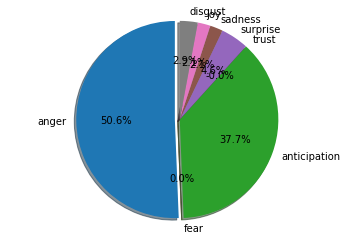

468 - There is only one way to stop this Democrat-Led assault on our sovereignty – you have to VOTE Republican TOMORROW! Polling locations: https://t.co/0pWiwCHGbh https://t.co/ggs0zcXaQu
527 - Illegal immigration affects the lives of all Americans. Illegal Immigration hurts American workers, burdens American taxpayers, undermines public safety, and places enormous strain on local schools, hospitals and communities...
https://t.co/eN1IqPNBJY
1914 - Homeland Security @SecNielsen did a fabulous job yesterday at the press conference explaining security at the border and for our country, while at the same time recommending changes to obsolete &amp; nasty laws, which force family separation. We want “heart” and security in America!
2556 - Thank you to Rasmussen for the honest polling. Just hit 50%, which is higher than Cheatin’ Obama at the same time in his Administration.
1665 - I had a great meeting with NATO. They have paid $33 Billion more and will pay hundreds of Billions of Dollars mo

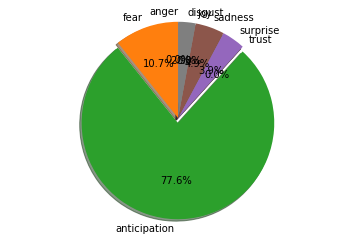

1327 - The local politicians who run Washington, D.C. (poorly) know a windfall when they see it. When asked to give us a price for holding a great celebratory military parade, they wanted a number so ridiculously high that I cancelled it. Never let someone hold you up! I will instead...
1873 - Hope OPEC will increase output substantially. Need to keep prices down!
1641 - I told you so! The European Union just slapped a Five Billion Dollar fine on one of our great companies, Google. They truly have taken advantage of the U.S., but not for long!
2640 - Andrew McCabe FIRED, a great day for the hard working men and women of the FBI - A great day for Democracy. Sanctimonious James Comey was his boss and made McCabe look like a choirboy. He knew all about the lies and corruption going on at the highest levels of the FBI!
735 - “Op-Ed praises Trump Administrations efforts at the Border.” @FoxNews  The  Washington Examiner States, “Finally, the government has taken steps to stop releasing unac

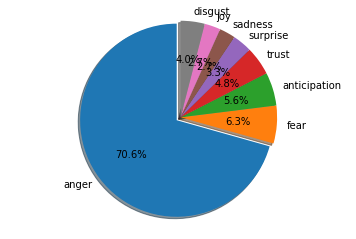

2803 - Hope Republicans in the Great State of Pennsylvania challenge the new “pushed” Congressional Map, all the way to the Supreme Court, if necessary. Your Original was correct! Don’t let the Dems take elections away from you so that they can raise taxes &amp; waste money!
922 - Senator Feinstein and the Democrats held the letter for months, only to release it with a bang after the hearings were OVER - done very purposefully to Obstruct &amp; Resist &amp; Delay. Let her testify, or not, and TAKE THE VOTE!
2136 - The 13 Angry Democrats (plus people who worked 8 years for Obama) working on the rigged Russia Witch Hunt, will be MEDDLING with the mid-term elections, especially now that Republicans (stay tough!) are taking the lead in Polls. There was no Collusion, except by the Democrats!
1268 - Michael Cohen plead guilty to two counts of campaign finance violations that are not a crime. President Obama had a big campaign finance violation and it was easily settled!
1514 - Collusion is n

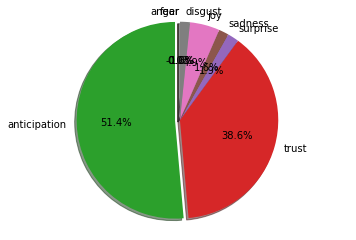

1884 - We have to maintain strong borders or we will no longer have a country that we can be proud of – and if we show any weakness, millions of people will journey into our country.
1289 - “Bruce Ohr is at the center of FALSE ALLEGATIONS which led to a multi-million dollar investigation into what apparently didn’t happen.” Darrell Issa, House Oversight. We can take out the word “apparently.”  @FoxNews
870 - NBC News incorrectly reported (as usual) that I was limiting the FBI investigation of Judge Kavanaugh, and witnesses, only to certain people. Actually, I want them to interview whoever they deem appropriate, at their discretion. Please correct your reporting!
857 - Great reviews on the new USMCA. Thank you! Mexico and Canada will be wonderful partners in Trade (and more) long into the future.
2829 - Funny how the Fake News Media doesn’t want to say that the Russian group was formed in 2014, long before my run for President. Maybe they knew I was going to run even though I didn’t kn

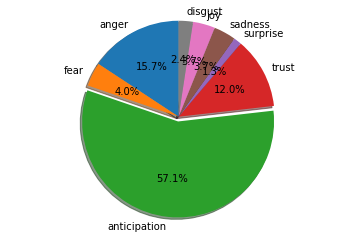

10 - I am in the White House waiting for the Democrats to come on over and make a deal on Border Security. From what I hear, they are spending so much time on Presidential Harassment that they have little time left for things like stopping crime and our military!
99 - Does the USA want to be the Policeman of the Middle East, getting NOTHING but spending precious lives and trillions of dollars protecting others who, in almost all cases, do not appreciate what we are doing? Do we want to be there forever? Time for others to finally fight.....
2009 - …Create peace and great prosperity for his land. I look forward to meeting him and have a feeling that this one-time opportunity will not be wasted!
90 - ....equipment. General Mattis was a great help to me in getting allies and other countries to pay their share of military obligations. A new Secretary of Defense will be named shortly. I greatly thank Jim for his service!
1407 - .....Will the FBI ever recover it’s once stellar reputation, so

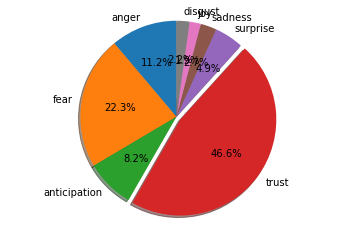

2657 - Hundreds of good people, including very important Ambassadors and Judges, are being blocked and/or slow walked by the Democrats in the Senate. Many important positions in Government are unfilled because of this obstruction. Worst in U.S. history!
2108 - Today, it was my great honor to be with the brave men and women of the United States Coast Guard! https://t.co/RAyPbOGXuZ
2874 - The Budget Agreement today is so important for our great Military. It ends the dangerous sequester and gives Secretary Mattis what he needs to keep America Great. Republicans and Democrats must support our troops and support this Bill!
1489 - Thank you to Chairman Kim Jong Un for keeping your word &amp; starting the process of sending home the remains of our great and beloved missing fallen! I am not at all surprised that you took this kind action. Also, thank you for your nice letter - l look forward to seeing you soon!
2820 - Now that Adam Schiff is starting to blame President Obama for Russian meddli

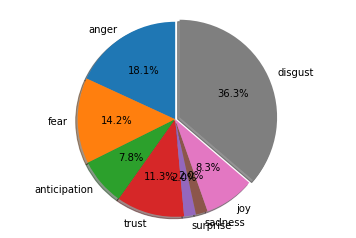

558 - .@Erik_Paulsen, @Jason2CD, 
@JimHagedornMN and @PeteStauber love our Country and the Great State of Minnesota. They are winners and always get the job done. We need them all in Congress for #MAGA. Border, Military, Vets, 2nd A. Go Vote Minnesota. They have my Strong Endorsement!
940 - .@JayWebberNJ is running for Congress in the 11th District of New Jersey. He is outstanding in every way. Strong on Borders, loves our Military and our Vets. Big Crime fighter. Jay has my Full and Total Endorsement!
974 - Americans deserve to know the lowest drug price at their pharmacy, but “gag clauses” prevent your pharmacist from telling you! I support legislation that will remove gag clauses and urge the Senate to act. #AmericanPatientsFirst
94 - Congress just passed the Criminal Justice Reform Bill known as the #FirstStepAct. Congratulations! This is a great bi-partisan achievement for everybody. When both parties work together we can keep our Country safer. A wonderful thing for the U.S.A.!!


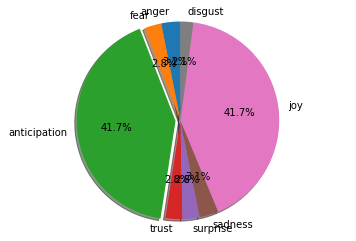

2907 - Heading to beautiful West Virginia to be with great members of the Republican Party. Will be planning Infrastructure and discussing Immigration and DACA, not easy when we have no support from the Democrats. NOT ONE DEM VOTED FOR OUR TAX CUT BILL! Need more Republicans in ‘18.
429 - Thank you @marcorubio for helping to expose the potential corruption going on with respect to Election Theft in Broward and Palm Beach Counties. The WORLD is now watching closely!
1484 - Looking forward to being in the Great State of Pennsylvania where we had a tremendous victory in the Election. Will be campaigning hard for an original supporter, Lou Barletta, to replace a weak an ineffective Senator, Bob Casey. Lou is tough and smart, loves PA and our Country!
1364 - Congratulations to Bryan Steil on a wonderful win last night. Your will be replacing a great guy in Paul Ryan, and your win in November will make the entire State of Wisconsin very proud. You have my complete and total Endorsement!
2602

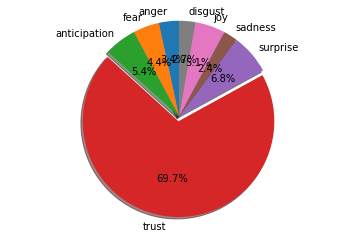

1412 - Thank you to Kanye West and the fact that he is willing to tell the TRUTH. One new and great FACT - African American unemployment is the lowest ever recorded in the history of our Country. So honored by this. Thank you Kanye for your support. It is making a big difference!
600 - I want to applaud the FBI, Secret Service, Department of Justice, the U.S. Attorneys’ Office for the Southern District of New York, the NYPD, and all Law Enforcement partners across the Country for their incredible work, skill and determination!
2495 - I have agreed with the historically cooperative, disciplined approach that we have engaged in with Robert Mueller (Unlike the Clintons!). I have full confidence in Ty Cobb, my Special Counsel, and have been fully advised throughout each phase of this process.
2335 - Our great financial team is in China trying to negotiate a level playing field on trade! I look forward to being with President Xi in the not too distant future. We will always have a good (gre

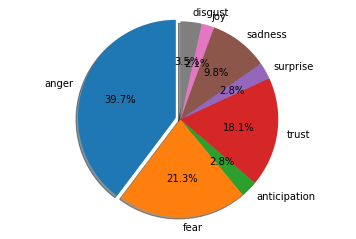

109 - Mexico is paying (indirectly) for the Wall through the new USMCA, the replacement for NAFTA! Far more money coming to the U.S. Because of the tremendous dangers at the Border, including large scale criminal and drug inflow, the United States Military will build the Wall!
557 - Congressman Andy Barr of Kentucky, who just had a great debate with his Nancy Pelosi run opponent, has been a winner for his State. Strong on Crime, the Border, Tax Cuts, Military, Vets and 2nd Amendment, we need Andy in D.C. He has my Strong Endorsement!
1782 - Either we need to elect more Republicans in November or Republicans must end the ridiculous 60 vote, or Filibuster, rule - or better yet, do both. Cryin’ Chuck would do it on day one, but we’ll never give him the chance. Some great legislation awaits - be smart!
2158 - With Spies, or “Informants” as the Democrats like to call them because it sounds less sinister (but it’s not), all over my campaign, even from a very early date, why didn’t the crooke

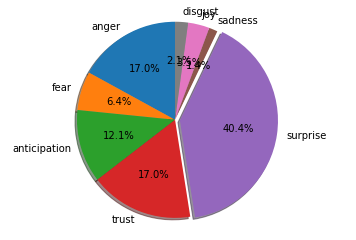

406 - American Cable Association has big problems with Comcast. They say that Comcast routinely violates Antitrust Laws. “These guys are acting much worse, and have much more potential for damage to consumers, than anything AT&amp;T-Time Warner would do.” Charlie Gasparino
2834 - Russia started their anti-US campaign in 2014, long before I announced that I would run for President. The results of the election were not impacted. The Trump campaign did nothing wrong - no collusion!
2218 - I hereby demand, and will do so officially tomorrow, that the Department of Justice look into whether or not the FBI/DOJ infiltrated or surveilled the Trump Campaign for Political Purposes - and if any such demands or requests were made by people within the Obama Administration!
452 - ....unbelievably lucky to have him and I’m just awed at how well they’ve done. It’s all the Trump magic - Trump is the magic man. Incredible, he’s got the entire media against him, attacking him every day, and he pulls out 

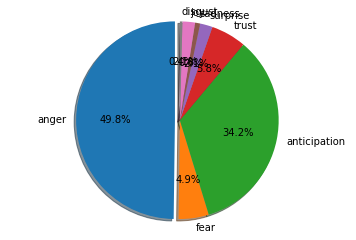

26 - The reason the DACA for Wall deal didn’t get done was that a ridiculous court decision from the 9th Circuit allowed DACA to remain, thereby setting up a Supteme Court case. After ruling, Dems dropped deal - and that’s where we are today, Democrat obstruction of the needed Wall.
1460 - ....China, which is for the first time doing poorly against us, is spending a fortune on ads and P.R. trying to convince and scare our politicians to fight me on Tariffs- because they are really hurting their economy. Likewise other countries. We are Winning, but must be strong!
1499 - Russian Collusion with the Trump Campaign, one of the most successful in history, is a TOTAL HOAX. The Democrats paid for the phony and discredited Dossier which was, along with Comey, McCabe, Strzok and his lover, the lovely Lisa Page, used to begin the Witch Hunt. Disgraceful!
2457 - There is a Revolution going on in California. Soooo many Sanctuary areas want OUT of this ridiculous, crime infested &amp; breeding con

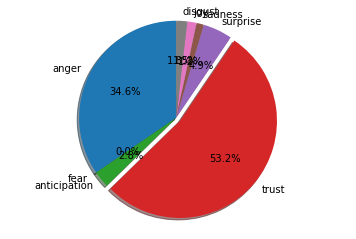

2899 - Today, it was my honor to join the great men and women of @DHSgov, @CustomsBorder, @ICEgov and @USCIS at the U.S. Customs and Border Protection National Targeting Center in Sterling, Virginia. Fact sheet: https://t.co/Q027Wgdzdo https://t.co/NecuA0y1Sk
411 - .....hundreds of billions of dollars, for the great privilege of losing hundreds of billions of dollars with these same countries on trade. I told them that this situation cannot continue - It is, and always has been, ridiculously unfair to the United States. Massive amounts.....
699 - ....The assault on our country at our Southern Border, including the Criminal elements and DRUGS pouring in, is far more important to me, as President, than Trade or the USMCA. Hopefully Mexico will stop this onslaught at their Northern Border. All Democrats fault for weak laws!
728 - Is it really possible that Bruce Ohr, whose wife Nellie was paid by Simpson and GPS Fusion for work done on the Fake Dossier, and who was used as a Pawn in this 

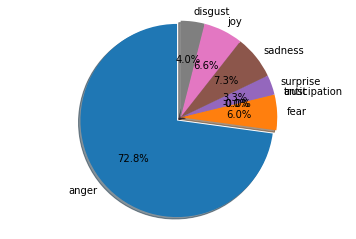

1343 - The Boston Globe, which was sold to the the Failing New York Times for 1.3 BILLION DOLLARS (plus 800 million dollars in losses &amp; investment), or 2.1 BILLION DOLLARS, was then sold by the Times for 1 DOLLAR. Now the Globe is in COLLUSION with other papers on free press. PROVE IT!
1526 - ...your Social Security and Medicare! Cast your early vote, or vote on August 7th, Election Day. He has my full and total Endorsement!
2496 - On Yom HaShoah we remember the six million Jews slaughtered in the Holocaust. With each passing year, our duty to remember this atrocity increases as we pledge #NeverAgain. #HolocaustRemembranceDay https://t.co/tyga4VtjLT
770 - People have no idea how hard Hurricane Michael has hit the great state of Georgia. I will be visiting both Florida and Georgia early next week. We are working very hard on every area and every state that was hit - we are with you!
2320 - We are going to demand Congress secure the border in the upcoming CR. Illegal immigration must

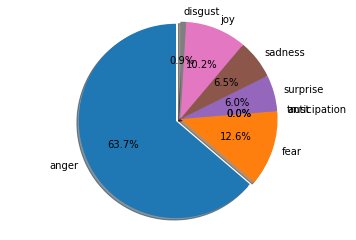

2530 - Fire at Trump Tower is out. Very confined (well built building). Firemen (and women) did a great job. THANK YOU!
2545 - The Caravan is largely broken up thanks to the strong immigration laws of Mexico and their willingness to use them so as not to cause a giant scene at our Border. Because of the Trump Administrations actions, Border crossings are at a still UNACCEPTABLE 46 year low. Stop drugs!
795 - REGISTER TO VOTE! https://t.co/0pWiwCHGbh https://t.co/3vYfDmpqiH
1687 - ....Where is the DNC Server, and why didn’t the FBI take possession of it? Deep State?
534 - THANK YOU FLORIDA! Get out and VOTE Republican! #MAGA????
https://t.co/v3hpKOPBik
----------------------------------------
[('anger', 2.368421052631578), ('fear', 1.842105263157894), ('trust', 1.7631578947368414), ('anticipation', 0.5263157894736842), ('joy', 0.2894736842105262), ('surprise', 0.15789473684210528), ('disgust', 0.07894736842105265), ('sadness', 0.026315789473684154)]


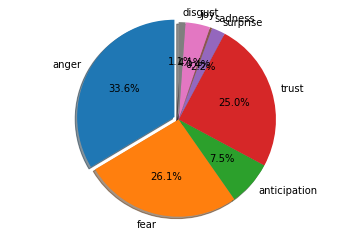

2202 - @foxandfriends  “New Bombshell in the Obama Spying Scandal. Did other Agencies SPY on Trump Campaign?” Even Clapper, worlds dumbest former Intelligence Head, who has the problem of lying a lot, used the word SPY when describing the illegal activities!
2344 - There was no Collusion (it is a Hoax) and there is no Obstruction of Justice (that is a setup &amp; trap). What there is is Negotiations going on with North Korea over Nuclear War, Negotiations going on with China over Trade Deficits, Negotiations on NAFTA, and much more. Witch Hunt!
141 - A REAL scandal is the one sided coverage, hour by hour, of networks like NBC &amp; Democrat spin machines like Saturday Night Live. It is all nothing less than unfair news coverage and Dem commercials. Should be tested in courts, can’t be legal? Only defame &amp; belittle! Collusion?
2056 - ...This is a level of criminality beyond the pale. This is such a grave abuse of power and authority, it’s like nothing else we’ve seen in our history.

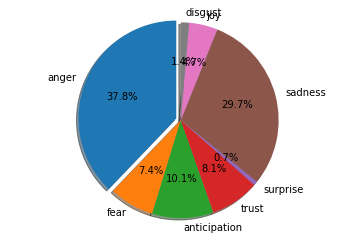

2861 - Peoples lives are being shattered and destroyed by a mere allegation. Some are true and some are false. Some are old and some are new. There is no recovery for someone falsely accused - life and career are gone. Is there no such thing any longer as Due Process?
1993 - I strongly endorse Adam Laxalt for Governor of Nevada. Adam is smart, works hard, and knows how to win. He will be a great Governor. Also, will fight hard to lower your taxes and is tough on crime!
583 - All of America is in mourning over the mass murder of Jewish Americans at the Tree of Life Synagogue in Pittsburgh. We pray for those who perished and their loved ones, and our hearts go out to the brave police officers who sustained serious injuries...
2089 - This is my 500th. Day in Office and we have accomplished a lot - many believe more than any President in his first 500 days. Massive Tax &amp; Regulation Cuts, Military &amp; Vets, Lower Crime &amp; Illegal Immigration, Stronger Borders, Judgeships, Best Econ

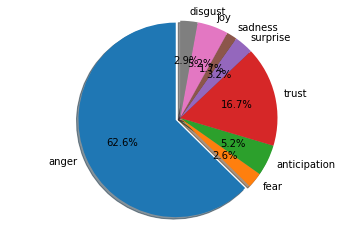

990 - While my (our) poll numbers are good, with the Economy being the best ever, if it weren’t for the Rigged Russian Witch Hunt, they would be 25 points higher! Highly conflicted Bob Mueller &amp; the 17 Angry Democrats are using this Phony issue to hurt us in the Midterms. No Collusion!
1736 - Public opinion has turned strongly against the Rigged Witch Hunt and the “Special” Counsel because the public understands that there was no  Collusion with Russia (so ridiculous), that the two FBI lovers were a fraud against our Nation &amp; that the only Collusion was with the Dems!
577 - There is great anger in our Country caused in part by inaccurate, and even fraudulent, reporting of the news. The Fake News Media, the true Enemy of the People, must stop the open &amp; obvious hostility &amp; report the news accurately &amp; fairly. That will do much to put out the flame...
1051 - The Economy is soooo good, perhaps the best in our country’s history (remember, it’s the economy stupid!), that

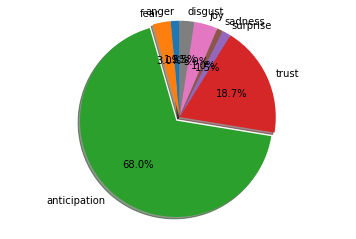

2267 - Heading over to Walter Reed Medical Center to see our great First Lady, Melania. Successful procedure, she is in good spirits. Thank you to all of the well-wishers!
2409 - ....We are a long way from conclusion on North Korea, maybe things will work out, and maybe they won’t - only time will tell....But the work I am doing now should have been done a long time ago!
1940 - Holding back the “war games” during the negotiations was my request because they are VERY EXPENSIVE and set a bad light during a good faith negotiation. Also, quite provocative. Can start up immediately if talks break down, which I hope will not happen!
1629 - The NFL National Anthem Debate is alive and well again - can’t believe it! Isn’t it in contract that players must stand at attention, hand on heart? The $40,000,000 Commissioner must now make a stand. First time kneeling, out for game. Second time kneeling, out for season/no pay!
2368 - Just had a long and very good talk with President Moon of South Korea.

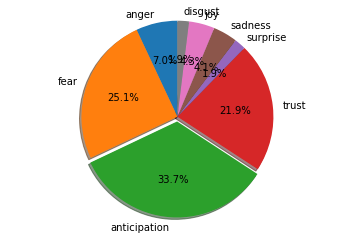

136 - The Democrats policy of Child Seperation on the Border during the Obama Administration was far worse than the way we handle it now. Remember the 2014 picture of children in cages - the Obama years. However, if you don’t separate, FAR more people will come. Smugglers use the kids!
2934 - Nobody knows for sure that the Republicans &amp; Democrats will be able to reach a deal on DACA by February 8, but everyone will be trying....with a big additional focus put on Military Strength and Border Security. The Dems have just learned that a Shutdown is not the answer!
1010 - I was just briefed on Hurricane Florence. FEMA, First Responders and Law Enforcement are supplied and ready. We are with you! https://t.co/mP7icn0Yzl https://t.co/a8KQ0lcoSD
159 - Happy 382nd Birthday @USNationalGuard. Our entire Nation is forever grateful for all you do 24/7/365. We love you! #Guard382 https://t.co/XLoCxOFvMA
2229 - Happy #ArmedForcesDay to our GREAT military men and women for their selfless service 

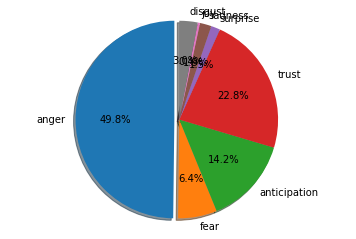

2755 - I want to encourage all of my many Texas friends to vote in the primary for Governor Greg Abbott, Senator Ted Cruz, Lt. Gov. Dan Patrick, and Attorney General Ken Paxton. They are helping me to Make America Great Again! Vote early or on March 6th.
1002 - “They say all these people died in the storm in Puerto Rico, yet 70% of the power was out before the storm. So when did people start dying? At what point do you recognize that what they are doing is a political agenda couched in the nice language of journalism?”  @GeraldoRivera
1645 - The Fake News Media is going Crazy! They make up stories without any backup, sources or proof. Many of the stories written about me, and the good people surrounding me, are total fiction. Problem is, when you complain you just give them more publicity. But I’ll complain anyway!
2670 - If schools are mandated to be gun free zones, violence and danger are given an open invitation to enter. Almost all school shootings are in gun free zones. Cowards wi

In [72]:
kmeans = KMeans(35, random_state=10032019).fit(mat)
sk_clusters = [[] for i in range(max(kmeans.labels_+1))]
for idx, lbl in enumerate(kmeans.labels_):
    sk_clusters[lbl].append(idx)
    
print(list(map(len, sk_clusters)))

lead_emotion_strength = []
random.seed(3511223233)
# take some random tweets from every cluster
for k, cluster in enumerate(sk_clusters):
    center = kmeans.cluster_centers_[k]
    # order the emotions by most present to least present
    orders = [(emotions[i], center[i]) for i in range(len(emotions))]
    orders.sort(key=lambda t: t[1], reverse=True)
    print(orders)
    lead_emotion_strength.append(orders[0][1])
    emotion_pie_chart(center/0.1)
    some_tweet_idx = random.sample(cluster, 5)
    for idx in some_tweet_idx:
        print(str(idx) + " - " + (text_tweets["text"][idx]))
    print("-"*40)

In [75]:
print(sorted(lead_emotion_strength))
print(lead_emotion_strength[len(lead_emotion_strength)//2])

[0.13636363636363624, 1.0, 1.0000000000000002, 1.2008368200836825, 1.2168674698795172, 1.4457831325301216, 1.4756097560975603, 1.4765100671140958, 1.4925373134328357, 1.5909090909090922, 1.7051282051282066, 1.7540983606557392, 1.8048780487804874, 1.8999999999999986, 1.965517241379311, 1.999999999999999, 2.2000000000000006, 2.2031249999999982, 2.2599999999999985, 2.281250000000002, 2.3200000000000016, 2.342465753424659, 2.368421052631578, 2.4347826086956523, 2.518518518518518, 2.783333333333335, 3.1470588235294112, 3.200000000000003, 3.2439024390243905, 3.3571428571428585, 3.4571428571428573, 4.100000000000002, 4.451612903225809, 4.638297872340427, 6.800000000000001]
1.4765100671140958


D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_dista

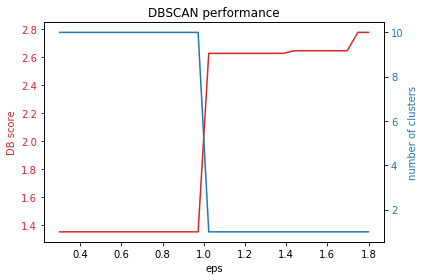

In [14]:
# apply the DBSCAN algorithm to the data for different values of K
# FIX THE ARGUMENT MIN_SAMPLES
Eps = np.linspace(.3,1.8,30)
DB = np.zeros_like(Eps).astype(float)
sizes = []
for i, eps in enumerate(Eps):
    dbscan = DBSCAN(eps = eps, min_samples=30).fit(mat)
    dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
    for idx, lbl in enumerate(dbscan.labels_):
        dbscan_clusters[lbl].append(idx)
    sizes.append(len(dbscan_clusters))
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, dbscan.labels_)
        
## Plot results of DBSCAN for different valus of eps
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('eps')
ax1.set_ylabel('DB score', color=color)
ax1.plot(Eps, DB, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('number of clusters', color=color)  # we already handled the x-label with ax1
ax2.plot(Eps, sizes, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(f'DBSCAN performance')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### DBSCAN with $\epsilon = 0.9$, minimum 30 tweets per cluster

[44, 52, 112, 351, 124, 38, 59, 81, 35, 2139]
We have 713 words, of which 462 are unique
[('anger', 1.0), ('trust', 1.0), ('fear', 0.0), ('anticipation', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('joy', 0.0), ('disgust', 0.0)]


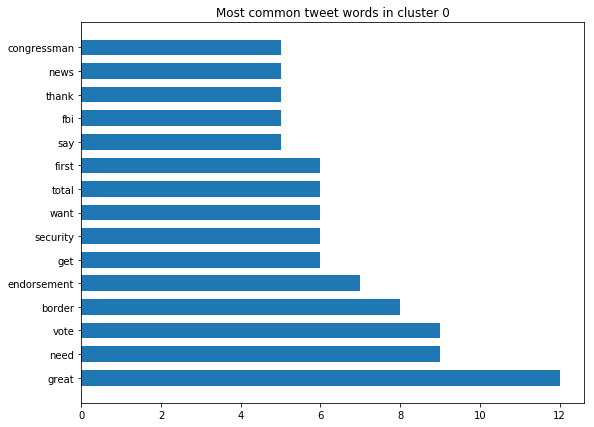

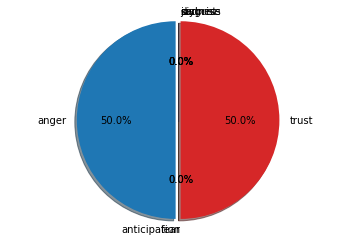

68 - Wishing Supreme Court Justice Ruth Bader Ginsburg a full and speedy recovery!
1843 - I have tried to stay uninvolved with the Department of Justice and FBI (although I do not legally have to), because of the now totally discredited and very expensive Witch Hunt currently going on. But you do have to ask why the DOJ &amp; FBI aren’t giving over requested documents?
174 - “I don’t care what you think of the President...it cannot bleed over to the FBI...Comey is confirming there is bias in the FBI...” 
-Chris Swecker
538 - Harry Reid, when he was sane, agreed with us on Birthright Citizenship! https://t.co/ypiE1QWKag
616 - Just spoke with Prime Minister @GiuseppeConteIT of Italy concerning many subjects, including the fact that Italy is now taking a very hard line on illegal immigration...
----------------------------------------
We have 462 words, of which 315 are unique
[('joy', 1.0), ('anger', 0.0), ('fear', 0.0), ('anticipation', 0.0), ('trust', 0.0), ('surprise', 0.0), ('sadness

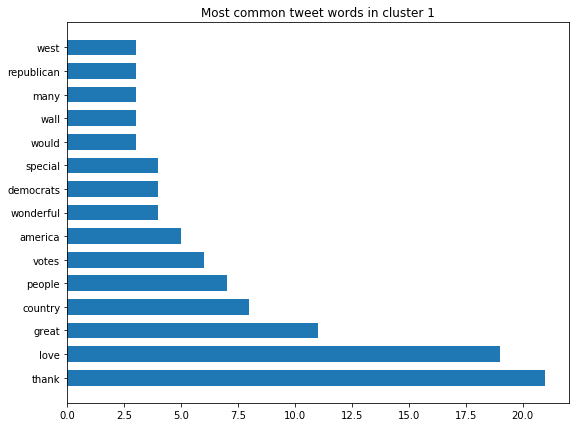

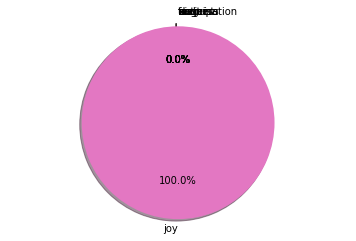

2255 - ...We have not seen China’s demands yet, which should be few in that previous U.S. Administrations have done so poorly in negotiating. China has seen our demands. There has been no folding as the media would love people to believe, the meetings...
1148 - I love Canada, but they’ve taken advantage of our Country for many years!
757 - WELCOME HOME PASTOR ANDREW BRUNSON! https://t.co/HijeAGU1gy
1116 - “Pledge to America’s Workers” https://t.co/wbGZU6oi9G
773 - PASTOR BRUNSON JUST RELEASED. WILL BE HOME SOON!
----------------------------------------
We have 1408 words, of which 759 are unique
[('trust', 1.0), ('anger', 0.0), ('fear', 0.0), ('anticipation', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('joy', 0.0), ('disgust', 0.0)]


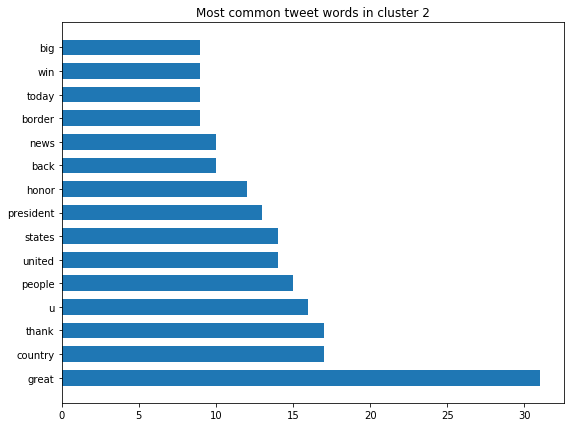

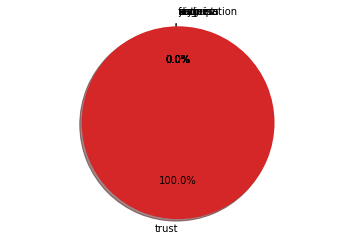

1663 - Thank you @RandPaul. “The President has gone through a year and a half of totally partisan investigations - what’s he supposed to think?”
2573 - Mexico has the absolute power not to let these large “Caravans” of people enter their country. They must stop them at their Northern Border, which they can do because their border laws work, not allow them to pass through into our country, which has no effective border laws.....
1161 - CNN is working frantically to find their “source.” Look hard because it doesn’t exist. Whatever was left of CNN’s credibility is now gone!
61 - Senate adjourns until December 27th.
1211 - .@FLOTUS Melania and I were honored to welcome the President of the Republic of Kenya, @UKenyatta and Mrs. Margaret Kenyatta to the @WhiteHouse today! https://t.co/ZU5MovNKt8
----------------------------------------
We have 2005 words, of which 905 are unique
[('anger', 0.0), ('fear', 0.0), ('anticipation', 0.0), ('trust', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('joy

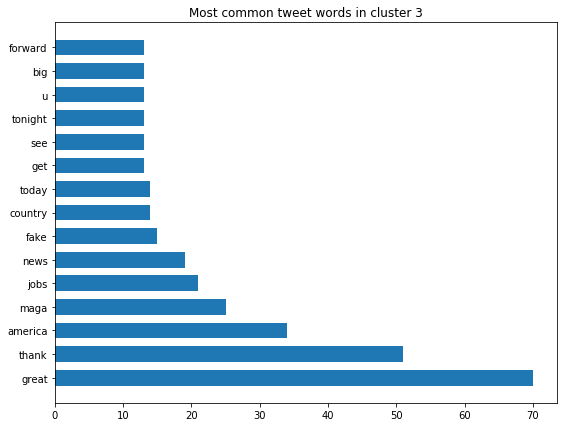

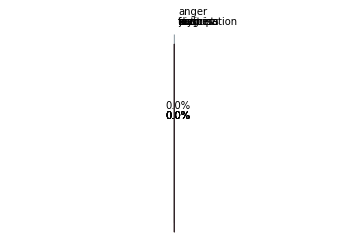

645 - https://t.co/flKQuv9MnX
1894 - Last night in Minnesota was incredible. What a crowd!
2818 - The Fake News of big ratings loser CNN. https://t.co/rYsv90cnvs
861 - https://t.co/5UmYGFLyLK
727 - REGISTER TO https://t.co/0pWiwCHGbh! #MAGA???? https://t.co/ACTMe53TZU
----------------------------------------
We have 1294 words, of which 711 are unique
[('anticipation', 1.0), ('anger', 0.0), ('fear', 0.0), ('trust', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('joy', 0.0), ('disgust', 0.0)]


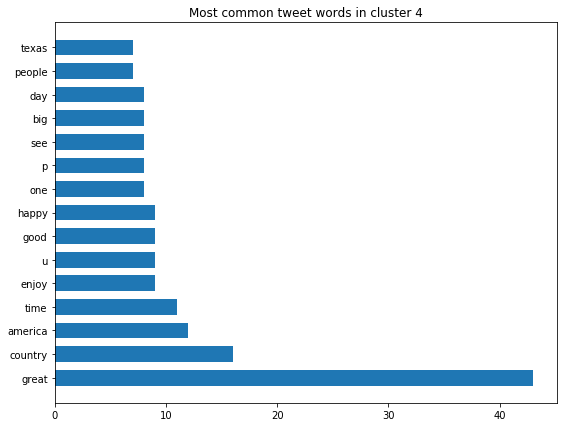

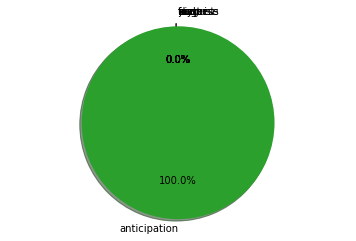

1691 - This is now changing - for the first time! https://t.co/bRgrMbdDPp
2956 - Today, I was honored and proud to address the 45th Annual @March_for_Life! You are living witnesses of this year’s March for Life theme: #LoveSavesLives. https://t.co/DMST4qhDmp
367 - I can get Nancy Pelosi as many votes as she wants in order for her to be Speaker of the House. She deserves this victory, she has earned it - but there are those in her party who are trying to take it away. She will win! @TomReedCongress
1221 - Fantastic numbers on consumer spending released on Friday. Stock Market hits all time high!
2733 - Good (Great) meeting in the Oval Office tonight with the NRA!
----------------------------------------
We have 679 words, of which 478 are unique
[('anticipation', 2.0), ('trust', 1.0), ('anger', 0.0), ('fear', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('joy', 0.0), ('disgust', 0.0)]


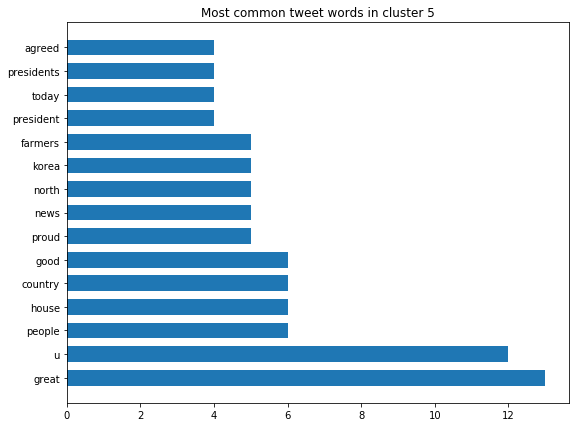

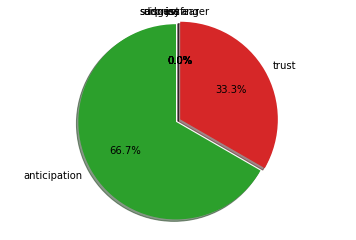

2622 - .....They can help solve problems with North Korea, Syria, Ukraine, ISIS, Iran and even the coming Arms Race. Bush tried to get along, but didn’t have the “smarts.” Obama and Clinton tried, but didn’t have the energy or chemistry (remember RESET). PEACE THROUGH STRENGTH!
1055 - The White House is running beautifully. We are making some of the greatest and most important deals in our countries history - with many more to come. Big progress!
2392 - Our two great republics are linked together by the timeless bonds of history, culture, and destiny. We are people who cherish our values, protect our civilization, and recognize the image of God in every human soul. https://t.co/01c8iSGDB3
235 - .....China had agreed to start “immediately” buying U.S. products.” @business
498 - In all the time I’ve been President, almost two years, never once did Senator Bill Nelson call me to ask for help for the Great State of Florida. I never see him until election time....
--------------------------

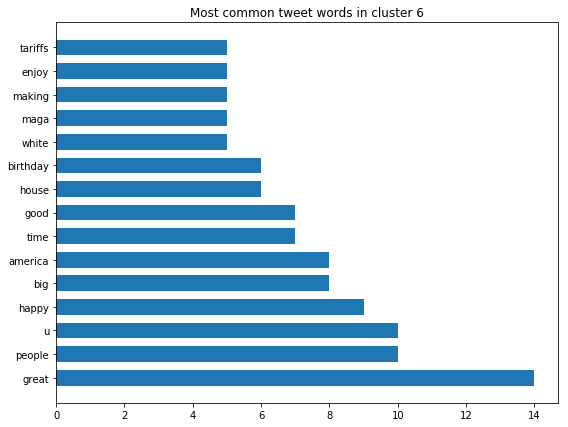

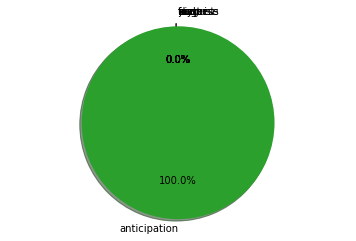

2162 - Looking forward to seeing Joshua Holt this evening in the White House. The great people of Utah are Celebrating!
1616 - Happy Birthday @SenatorDole! https://t.co/MiVoB7qC6A
286 - Billions of Dollars are pouring into the coffers of the U.S.A. because of the Tariffs being charged to China, and there is a long way to go. If companies don’t want to pay Tariffs, build in the U.S.A. Otherwise, lets just make our Country richer than ever before!
1742 - Thanks to REPUBLICAN LEADERSHIP, America is WINNING AGAIN - and America is being RESPECTED again all over the world. Because we are finally putting AMERICA FIRST!
2851 - This will be a big week for Infrastructure. After so stupidly spending $7 trillion in the Middle East, it is now time to start investing in OUR Country!
----------------------------------------
We have 969 words, of which 574 are unique
[('anger', 1.0), ('fear', 0.0), ('anticipation', 0.0), ('trust', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('joy', 0.0), ('disgust', 0.

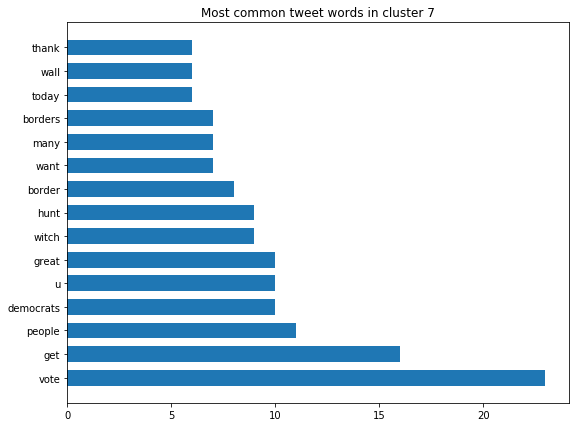

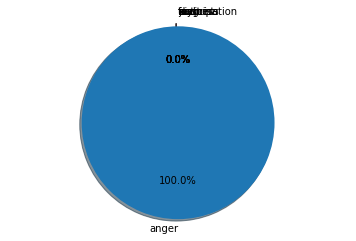

648 - Last day to register to VOTE in Alabama, California, South Dakota and Wyoming! #JobsNotMobs https://t.co/0pWiwCq4MH https://t.co/hmQgqgmbyE
2263 - Nebraska - make sure you get out to the polls and VOTE for Deb Fischer today! https://t.co/bDHVaGv2FS
714 - August job openings hit a record 7.14 million. Congratulations USA!
1422 - Space Force all the way!
772 - REGISTER TO VOTE! https://t.co/0pWiwCHGbh https://t.co/EOCLoJJ24B
----------------------------------------
We have 488 words, of which 332 are unique
[('trust', 2.0), ('anger', 0.0), ('fear', 0.0), ('anticipation', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('joy', 0.0), ('disgust', 0.0)]


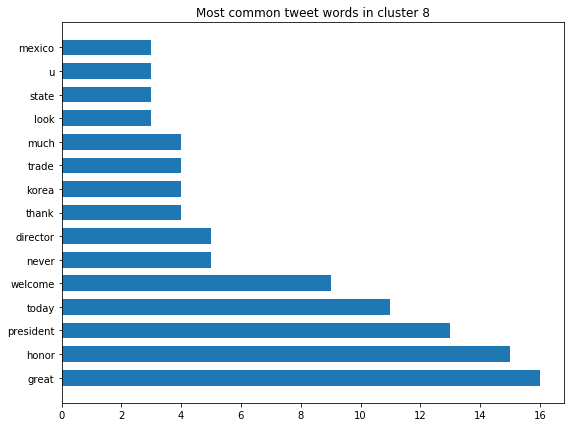

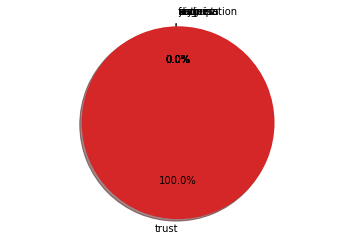

2046 - We must always protect those who protect us. Today, it was my great honor to sign the #VAMissionAct and to make Veterans Choice the permanent law of the land! https://t.co/VV3GdDISbD https://t.co/4OsUDWIzwo
1390 - Wacky Omarosa already has a fully signed Non-Disclosure Agreement!
1662 - The economy of the United States is stronger than ever before!
2393 - Today, @FLOTUS Melania and I were honored to welcome French President @EmmanuelMacron and Mrs. Brigitte Macron to the @WhiteHouse. We look forward to hosting them at tonight's State Dinner, in their honor. https://t.co/wGJcWqSzyP
2979 - Today, it was my honor to welcome President Nursultan Nazarbayev of Kazakhstan to the @WhiteHouse! https://t.co/TerYFZViax
----------------------------------------
We have 44514 words, of which 6142 are unique
[('anger', 1.1757830762038335), ('trust', 1.067321178120617), ('anticipation', 0.9467040673211781), ('fear', 0.4118747078073866), ('joy', 0.28564749883122953), ('sadness', 0.22487143525011

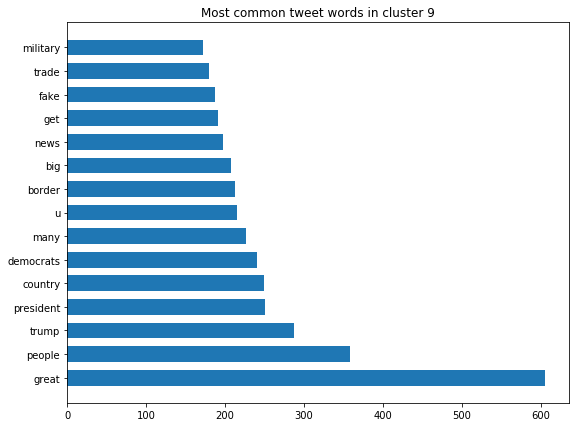

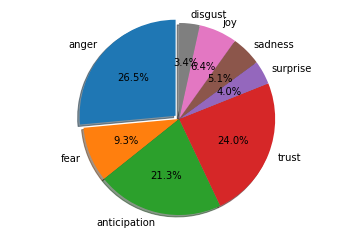

1296 - Study the late Joseph McCarthy, because we are now in period with Mueller and his gang that make Joseph McCarthy look like a baby! Rigged Witch Hunt!
1490 - Congratulations to  @GreggJarrett on The TREMENDOUS success of his just out book, “The Russia Hoax, The Illicit Scheme To Clear Hillary Clinton &amp; Frame Donald Trump.” Already number one on Amazon. Hard work from a brilliant guy. It’s the Real Story of the Rigged Witch Hunt!
1841 - Hiring manythousands of judges, and going through a long and complicated legal process, is not the way to go - will always be disfunctional. People must simply be stopped at the Border and told they cannot come into the U.S. illegally. Children brought back to their country......
2785 - I will be strongly pushing Comprehensive Background Checks with an emphasis on Mental Health. Raise age to 21 and end sale of Bump Stocks! Congress is in a mood to finally do something on this issue - I hope!
1281 - Even James Clapper has admonished John Brennan

In [77]:
# apply the DBSCAN algorithm to the data
dbscan = DBSCAN(eps=0.9, min_samples=30).fit(mat)
dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
for idx, lbl in enumerate(dbscan.labels_):
    dbscan_clusters[lbl].append(idx)

print(list(map(len, dbscan_clusters)))

def callback(k):
    # find the "center" of this cluster
    acc = np.zeros([1, E])
    for idx in dbscan_clusters[k]:
        acc += np.array(mat[idx], float)
    center = acc/len(dbscan_clusters[k])
    # order the emotions by most present to least present
    orders = [(emotions[i], center[0, i]) for i in range(len(emotions))]
    orders.sort(key=lambda t: t[1], reverse=True)
    print(orders)
    emotion_pie_chart(list(center[0]))

random.seed(1653)
explore_clusters(dbscan_clusters, callback)

#### Apart from the last one, each cluster only contains ONE type of vector that appears nowhere else

In [84]:
for k in range(len(dbscan_clusters)-1):
    ctr = mat[dbscan_clusters[k][0]]
    # show that everyone looks like the same
    for idx in dbscan_clusters[k]:
        if mat[idx] != ctr:
            print("oops, should be the same here...")
    for j in range(len(dbscan_clusters)-1):
        if j==k:
            continue
        for idx in dbscan_clusters[j]:
            if mat[idx] == ctr:
                print("collision found!")

### DBSCAN with $\epsilon = 0.9$, no minimum

[9, 14, 44, 7, 52, 7, 112, 12, 27, 28, 351, 10, 124, 38, 5, 21, 17, 5, 8, 12, 8, 6, 26, 59, 5, 13, 81, 35, 13, 12, 7, 9, 7, 10, 12, 11, 14, 6, 15, 17, 6, 13, 21, 5, 56, 15, 6, 24, 6, 6, 5, 6, 11, 5, 23, 7, 10, 8, 5, 9, 16, 14, 16, 12, 14, 8, 20, 5, 8, 10, 10, 9, 6, 10, 5, 5, 13, 7, 15, 17, 10, 8, 5, 5, 9, 5, 5, 5, 6, 6, 8, 8, 5, 5, 8, 10, 5, 1186]
We have 183 words, of which 160 are unique
9
[('trust', 1.0), ('disgust', 1.0), ('anger', 0.0), ('fear', 0.0), ('anticipation', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('joy', 0.0)]


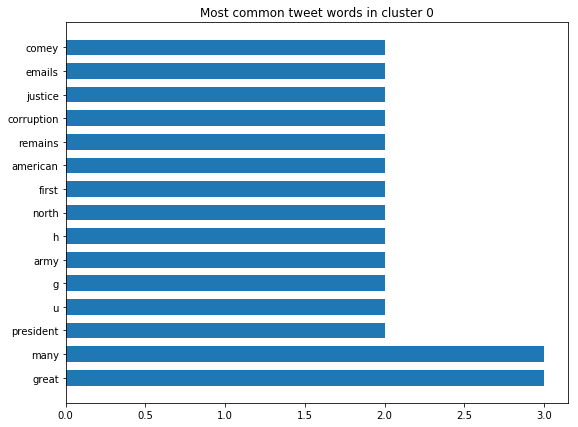

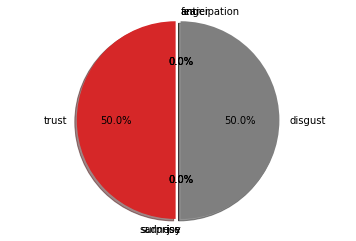

0 - President and Mrs. Obama built/has a ten foot Wall around their D.C. mansion/compound. I agree, totally necessary for their safety and security. The U.S. needs the same thing, slightly larger version!
1563 - The Remains of American Servicemen will soon be leaving North Korea and heading to the United States! After so many years, this will be a great moment for so many families. Thank you to Kim Jong Un.
1194 - Hillary Clinton’s Emails, many of which are Classified Information, got hacked by China. Next move better be by the FBI &amp; DOJ or, after all of their other missteps (Comey, McCabe, Strzok, Page, Ohr, FISA, Dirty Dossier etc.), their credibility will be forever gone!
1528 - Congratulations to General John Kelly. Today we celebrate his first full year as @WhiteHouse Chief of Staff! https://t.co/JWCaJ3GhHV
294 - .....and G.M. would not be closing their plants in Ohio, Michigan &amp; Maryland. Get smart Congress. Also, the countries that send us cars have taken advantage of th

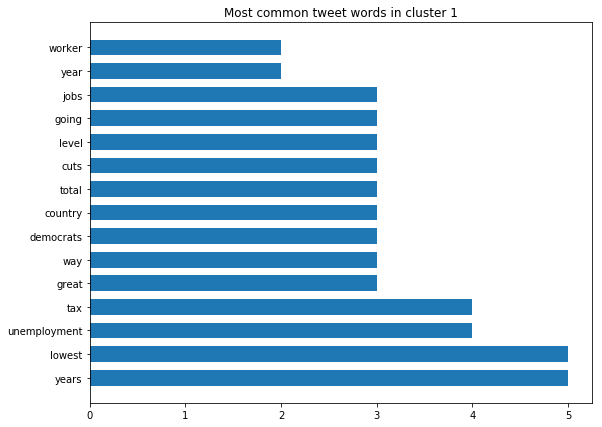

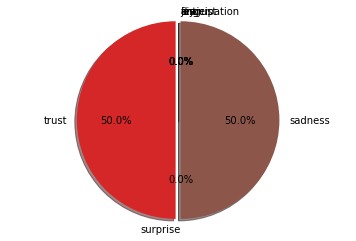

1132 - ....The fact is that African/American unemployment is now the lowest in the history of our country. Same with Asian, Hispanic and almost every other group. The Democrats have been all talk and no action. My Administration has already produced like no other, and everyone sees it!
2401 - Mexico, whose laws on immigration are very tough, must stop people from going through Mexico and into the U.S. We may make this a condition of the new NAFTA Agreement. Our Country cannot accept what is happening! Also, we must get Wall funding fast.
2031 - “$3 billion payoff: 101 utilities cut rates, credit GOP tax cuts” https://t.co/x1a1OJuRgd
879 - Congressman Lee Zeldin is doing a fantastic job in D.C. Tough and smart, he loves our Country and will always be there to do the right thing. He has my Complete and Total Endorsement!
2476 - Slippery James Comey, a man who always ends up badly and out of whack (he is not smart!), will go down as the WORST FBI Director in history, by far!
-------------

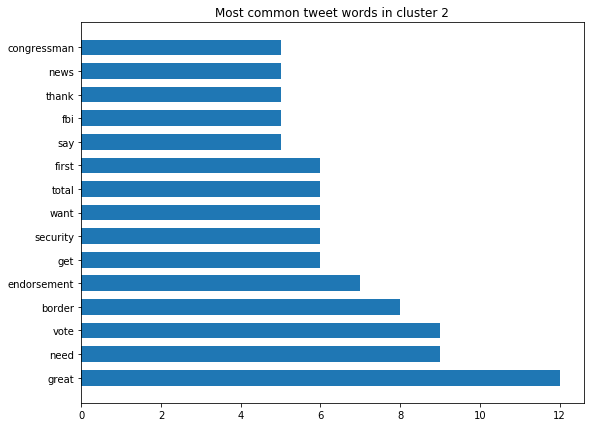

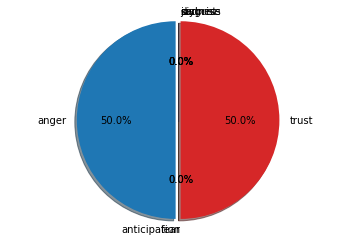

567 - .@troybalderson is doing a great job as Congressman from Ohio. We need him in D.C. Vote for Troy - He has my total Endorsement!
1738 - Big decision will soon be made on our next Justice of the Supreme Court!
1114 - “Judge Brett Kavanaugh is an Exceptionally Qualified and Deserving Nominee for the Supreme Court” https://t.co/nD5XZo9yIm
23 - “Border Patrol Agents want the Wall.” Democrat’s say they don’t want the Wall (even though they know it is really needed), and they don’t want ICE. They don’t have much to campaign on, do they? An Open Southern Border and the large scale crime that comes with such stupidity!
1133 - Tiger Woods showed great class in the way he answered the question about the Office of the Presidency and me. Now they say the so-called “left” is angry at him. So sad, but the “center &amp; right” loves Tiger, Kanye, George Foreman, Jim Brown &amp; so many other greats, even more.......
----------------------------------------
We have 178 words, of which 150 are uni

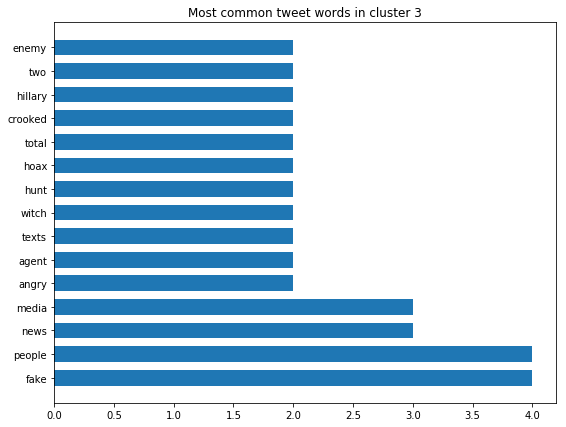

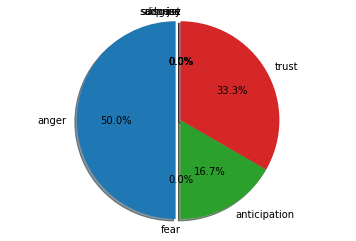

11 - The Mueller Angry Democrats recently deleted approximately 19,000 Text messages between FBI Agent Lisa Page and her lover, Agent Peter S. These Texts were asked for and INVALUABLE to the truth of the Witch Hunt Hoax. This is a total Obstruction of Justice. All Texts Demanded!
604 - Twitter has removed many people from my account and, more importantly, they have seemingly done something that makes it much harder to join - they have stifled growth to a point where it is obvious to all. A few weeks ago it was a Rocket Ship, now it is a Blimp! Total Bias?
119 - ....WILL NEVER BE PROVEN AND ARE LIKELY FALSE.”  Thank you to Michael Isikoff, Yahoo, for honesty. What this means is that the FISA WARRANTS and the whole Russian Witch Hunt is a Fraud and a Hoax which should be ended immediately. Also, it was paid for by Crooked Hillary &amp; DNC!
1298 - The Failing New York Times wrote a story that made it seem like the White House Councel had TURNED on the President, when in fact it is just 

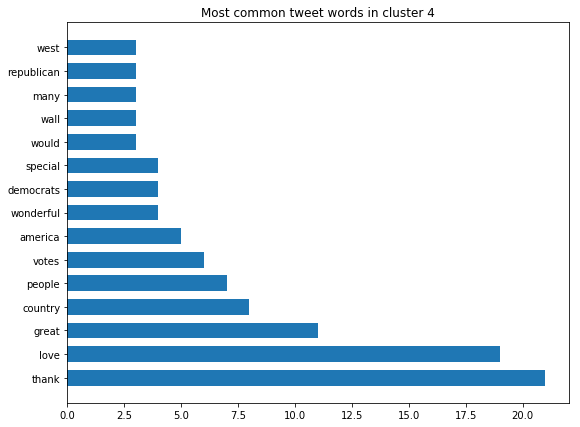

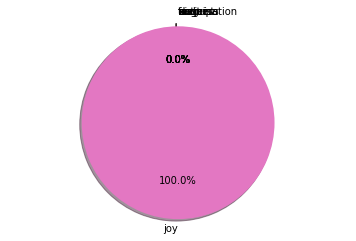

397 - When will Bill Nelson concede in Florida? The characters running Broward and Palm Beach voting will not be able to “find” enough votes, too much spotlight on them now!
1237 - Thank you. I love you Ohio! https://t.co/RQ9Gj0SETz
1479 - Thank you Pennsylvania. I love you! https://t.co/qoswnBZb3f
2116 - Not that it matters but I never fired James Comey because of Russia! The Corrupt Mainstream Media loves to keep pushing that narrative, but they know it is not true!
757 - WELCOME HOME PASTOR ANDREW BRUNSON! https://t.co/HijeAGU1gy
----------------------------------------
We have 158 words, of which 124 are unique
7
[('anger', 2.0), ('trust', 2.0), ('anticipation', 1.0), ('fear', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('joy', 0.0), ('disgust', 0.0)]


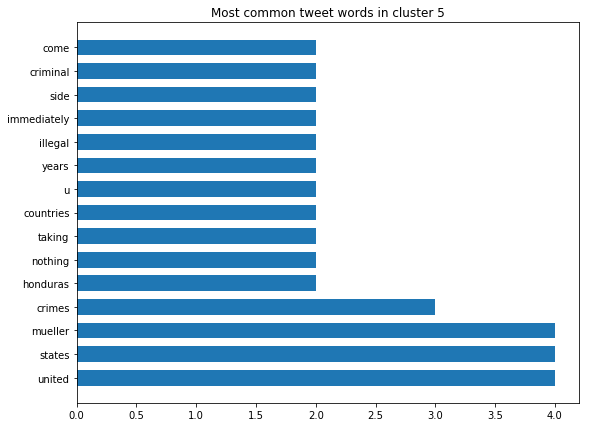

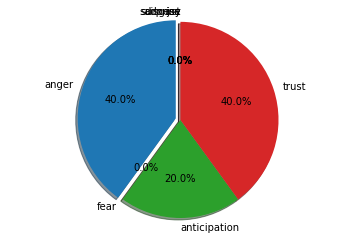

308 - While CNN doesn’t do great in the United States based on ratings, outside of the U.S. they have very little competition. Throughout the world, CNN has a powerful voice portraying the United States in an unfair....
13 - .....Honduras, Guatemala and El Salvador are doing nothing for the United States but taking our money. Word is that a new Caravan is forming in Honduras and they are doing nothing about it. We will be cutting off all aid to these 3 countries - taking advantage of U.S. for years!
475 - Law Enforcement has been strongly notified to watch closely for any ILLEGAL VOTING which may take place in Tuesday’s Election (or Early Voting). Anyone caught will be subject to the Maximum Criminal Penalties allowed by law. Thank you!
1780 - When people come into our Country illegally, we must IMMEDIATELY escort them back out without going through years of legal maneuvering. Our laws are the dumbest anywhere in the world. Republicans want Strong Borders and no Crime. Dems want Open B

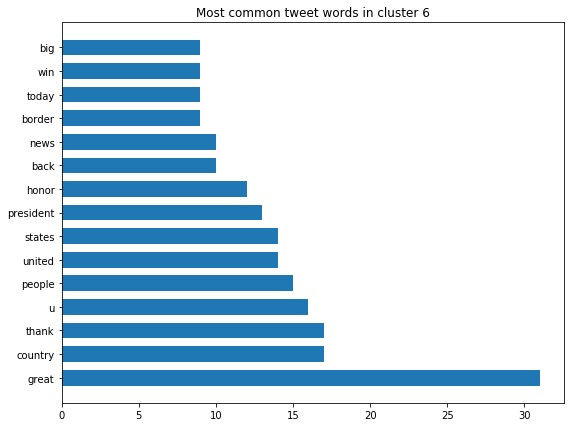

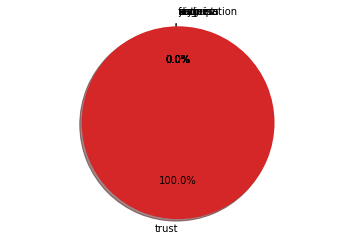

1875 - 80% of Mexico’s Exports come to the United States. They totally rely on us, which is fine with me. They do have, though, very strong Immigration Laws. The U.S. has pathetically weak and ineffective Immigration Laws that the Democrats refuse to help us fix. Will speak to Mexico!
2832 - Melania and I met such incredible people last night in Broward County, Florida. Will never forget them, or the evening!
658 - Congressman Tom Reed of New York’s 23rd District has done a great job. He has my complete and total Endorsement!
2961 - AMERICA will once again be a NATION that thinks big, dreams bigger, and always reaches for the stars. YOU are the ones who will shape America’s destiny. YOU are the ones who will restore our prosperity. And YOU are the ones who are MAKING AMERICA GREAT AGAIN! #MAGA https://t.co/f2abNK47II
2812 - Obama was President up to, and beyond, the 2016 Election. So why didn’t he do something about Russian meddling?
----------------------------------------
We have 184

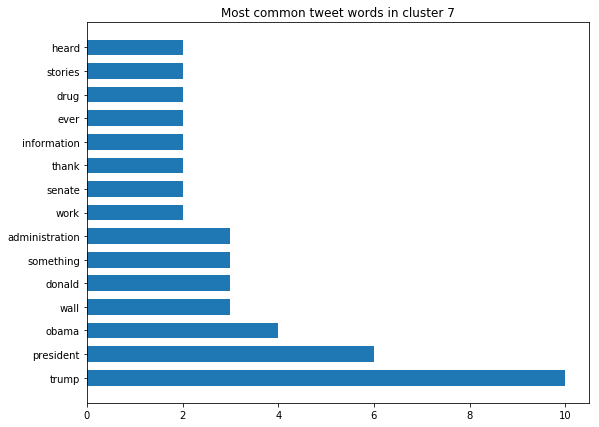

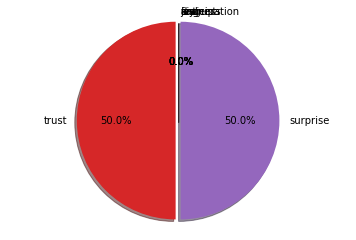

1688 - The stories you heard about the 12 Russians yesterday took place during the Obama Administration, not the Trump Administrations. Why didn’t they do something about it, especially when it was reported that President Obama was informed by the FBI in September, before the Election?
1039 - “ERIC Holder could be running the Justice Department right now and it would be behaving no differently than it is.” @LouDobbs
1234 - Great to see the Senate working on solutions to end the secrecy around ridiculously high drug prices, something I called for in my drug pricing Blueprint. Will now work with the House to help American patients! #AmericanPatientsFirst
2753 - Texas LC George P. Bush backed me when it wasn’t the politically correct thing to do, and I back him now. Also, AC Sid Miller has been with me from the beginning, he is “Trump’s Man in Texas.” Also support Comptroller Glenn Hegar, and Railroad Commissioner Christi Craddick.
1135 - “No information was ever given by the Trump Team t

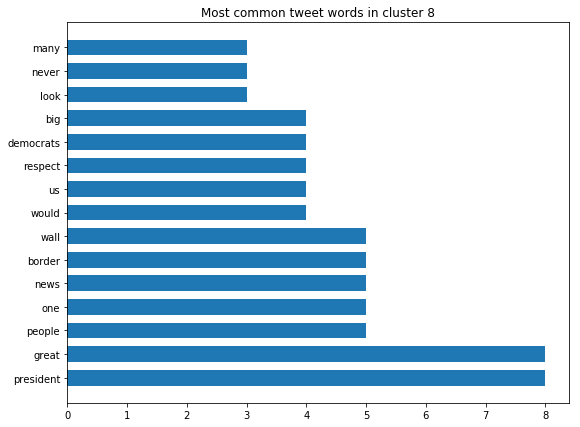

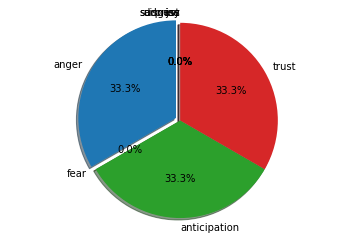

219 - Robert Mueller and Leakin’ Lyin’ James Comey are Best Friends, just one of many Mueller Conflicts of Interest. And bye the way, wasn’t the woman in charge of prosecuting Jerome Corsi (who I do not know) in charge of “legal” at the corrupt Clinton Foundation? A total Witch Hunt...
226 - My thoughts and prayers are with the @USMC crew members who were involved in a mid-air collision off the coast of Japan. Thank you to @USForcesJapan for their immediate response and rescue efforts. Whatever you need, we are here for you. @IIIMEF
880 - China is actually placing propaganda ads in the Des Moines Register and other papers, made to look like news. That’s because we are beating them on Trade, opening markets, and the farmers will make a fortune when this is over! https://t.co/ppdvTX7oz1
1786 - Just spoke to King Salman of Saudi Arabia and explained to him that, because of the turmoil &amp; disfunction in Iran and Venezuela, I am asking that Saudi Arabia increase oil production, maybe up 

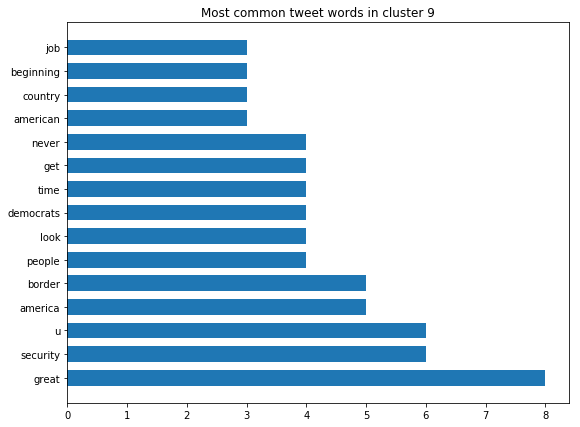

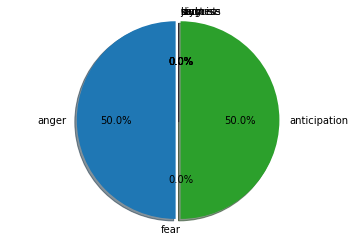

761 - “From a Turkish prison to the White House in 24 hours.”  Kristin Fisher of @FoxNews   Very cool!
1517 - ....them richer. Their network is highly overrated, I have beaten them at every turn. They want to protect their companies outside the U.S. from being taxed, I’m for America First &amp; the American Worker - a puppet for no one. Two nice guys with bad ideas. Make America Great Again!
2634 - Spent very little time with Andrew McCabe, but he never took notes when he was with me. I don’t believe he made memos except to help his own agenda, probably at a later date. Same with lying James Comey. Can we call them Fake Memos?
1826 - A Harley-Davidson should never be built in another country-never! Their employees and customers are already very angry at them. If they move, watch, it will be the beginning of the end - they surrendered, they quit! The Aura will be gone and they will be taxed like never before!
338 - “It’s a mean &amp; nasty world out there, the Middle East in particular.

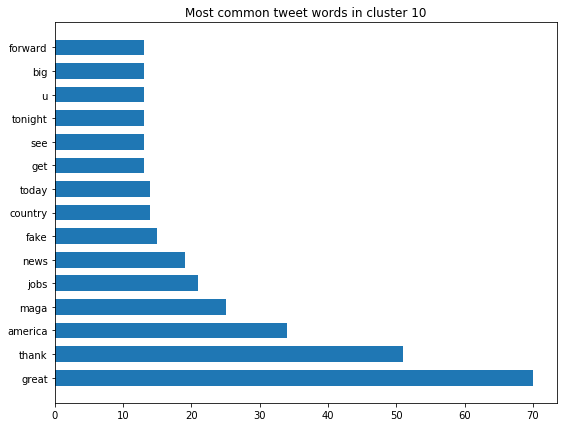

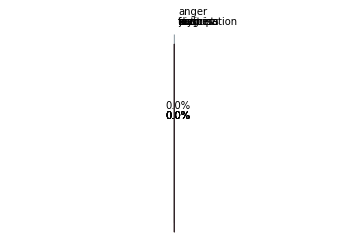

2581 - https://t.co/UM3YJ6lUiD
2538 - AMERICA IS OPEN FOR BUSINESS! https://t.co/5jxdojPZmN
598 - Whether you are African-American, Hispanic-American or ANY AMERICAN at all – you have the right to live in a Country that puts YOUR NEEDS FIRST! https://t.co/hwDICbpOT7
913 - https://t.co/MgkotGmkJ0
1567 - PROMISES KEPT! https://t.co/vR2R5WXPVD
----------------------------------------
We have 206 words, of which 160 are unique
10
[('anticipation', 2.0), ('anger', 1.0), ('fear', 0.0), ('trust', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('joy', 0.0), ('disgust', 0.0)]


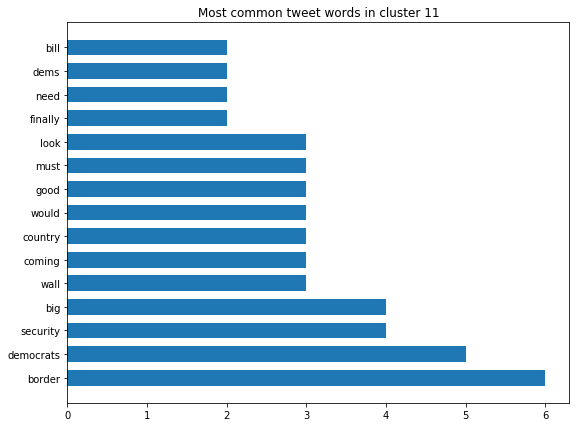

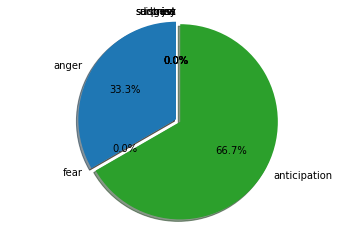

1359 - .@PeteStauber won big last night in Minnesota. A big star in Hockey, he will be an even bigger star in politics. It all begins with a win in November. Pete has my complete and total Endorsement!
1523 - ...that Open Borders, large scale Crime, and abolishing ICE is good for them, we must get smart and finally do what must be done for the Safety and Security of our Country!
2416 - So funny, the Democrats have sued the Republicans for Winning. Now he R’s counter and force them to turn over a treasure trove of material, including Servers and Emails!
27 - Have the Democrats finally realized that we desperately need Border Security and a Wall on the Southern Border. Need to stop Drugs, Human Trafficking,Gang Members &amp; Criminals from coming into our Country. Do the Dems realize that most of the people not getting paid are Democrats?
2194 - There will be big news coming soon for our great American Autoworkers. After many decades of losing your jobs to other countries, you have waite

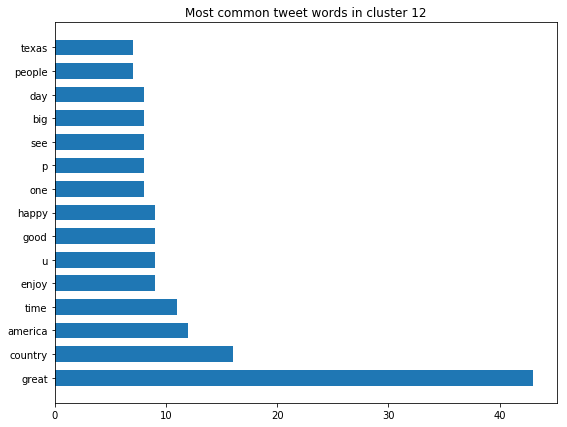

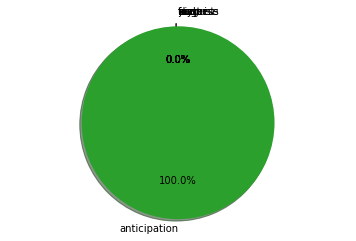

2014 - Just met the new Prime Minister of Italy, @GiuseppeConteIT, a really great guy. He will be honored in Washington, at the @WhiteHouse, shortly. He will do a great job - the people of Italy got it right!
361 - I will be interviewed by Chris Wallace on @FoxNews at 2:00 P.M. and 7:00 P.M. Enjoy!
1197 - Add the 2026 World Cup to our long list of accomplishments!
1642 - Really big jobs meeting today at the White House! 3 P.M.
1605 - ....In my opinion the Washington Post is nothing more than an expensive (the paper loses a fortune) lobbyist for Amazon. Is it used as protection against antitrust claims which many feel should be brought?
----------------------------------------
We have 679 words, of which 478 are unique
38
[('anticipation', 2.0), ('trust', 1.0), ('anger', 0.0), ('fear', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('joy', 0.0), ('disgust', 0.0)]


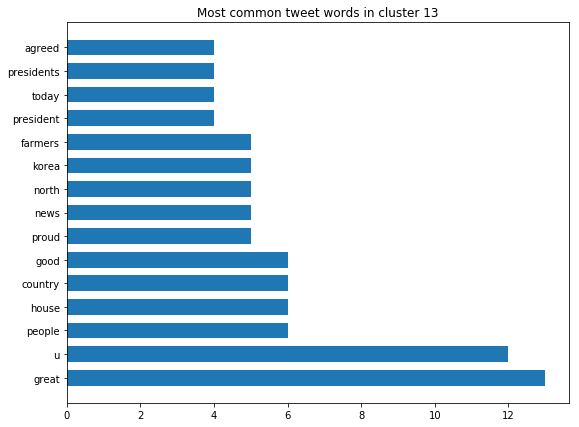

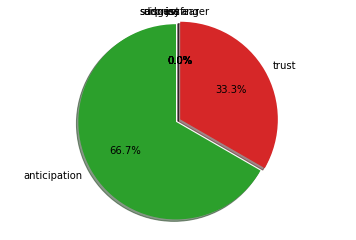

374 - People are not being told that the Republican Party is on track to pick up two seats in the U.S. Senate, and epic victory: 53 to 47. The Fake News Media only wants to speak of the House, where the Midterm results were better than other sitting Presidents.
2629 - Our Nation was founded by farmers. Our independence was won by farmers. And our continent was tamed by farmers. Our farmers always lead the way -- we are PROUD of them, and we are DELIVERING for them! #NationalAgricultureDay
2216 - China has agreed to buy massive amounts of ADDITIONAL Farm/Agricultural Products - would be one of the best things to happen to our farmers in many years!
498 - In all the time I’ve been President, almost two years, never once did Senator Bill Nelson call me to ask for help for the Great State of Florida. I never see him until election time....
821 - Very proud of the U.S. Senate for voting “YES” to advance the nomination of Judge Brett Kavanaugh!
----------------------------------------
We hav

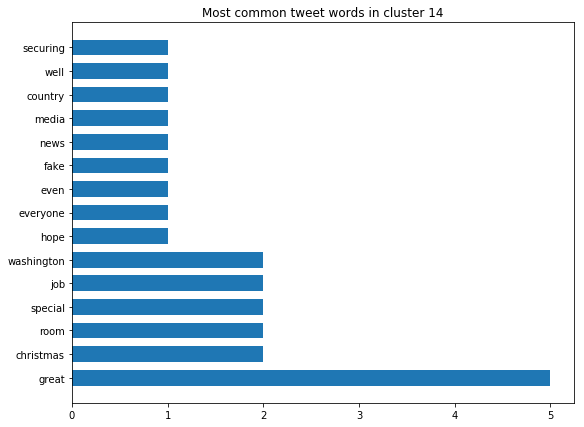

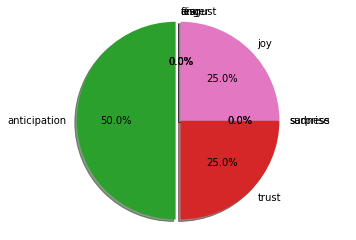

392 - It was my great honor to host a celebration of Diwali, the Hindu Festival of Lights, in the Roosevelt Room at the @WhiteHouse this afternoon. Very, very special people! https://t.co/kQk7IvpSFo https://t.co/tYlBABg4JF
2389 - .@FLOTUS did a spectacular job hosting the President of France @EmmanuelMacron and his wife Brigitte. Every detail was done to perfection. The State Dining Room never looked more beautiful, and Washington is abuzz over what an incredible job Melania did.
2052 - Gold Star father, Ceejay Metcalf, whose great son Michael was just honored at the White House, was fantastic this morning on @foxandfriends. He is a special man!
2873 - Will be heading over shortly to make remarks at The National Prayer Breakfast in Washington. Great religious and political leaders, and many friends, including T.V. producer Mark Burnett of our wonderful 14 season Apprentice triumph, will be there. Looking forward to seeing all!
30 - I hope everyone, even the Fake News Media, is having a

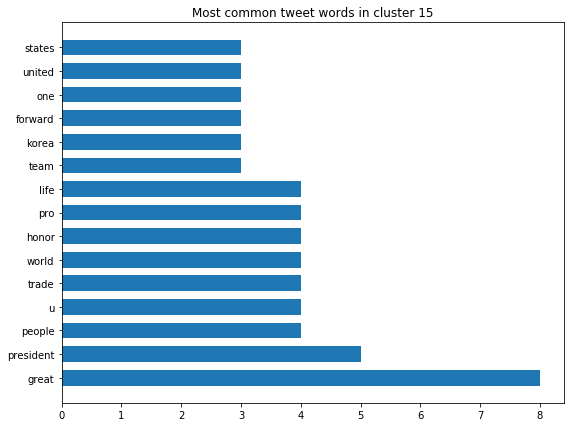

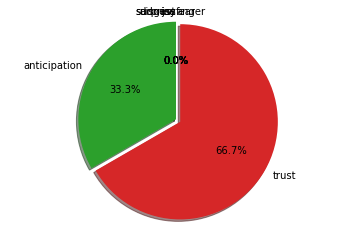

864 - ....deficiencies and mistakes in NAFTA, greatly opens markets to our Farmers and Manufacturers, reduces Trade Barriers to the U.S. and will bring all three Great Nations together in competition with the rest of the world. The USMCA is a historic transaction!
2845 - Today, I was honored to be joined by Republicans and Democrats from both the House and Senate, as well as members of my Cabinet - to discuss the urgent need to rebuild and restore America’s depleted infrastructure. https://t.co/8ByoQJsjTT https://t.co/BVBRDvHfcC
249 - Looking forward to being with the Bush Family to pay my respects to President George H.W. Bush.
1878 - Governor Henry McMaster is a truly fine man who loves the People of South Carolina. He was one of my very early supporters and truly helped me to a Big South Carolina Victory. I will see you all in S.C on Monday and Vice President Pence will be there for Henry on Saturday!
1060 - ...its commitment to denuclearize.” @FoxNews  This is a big and very positi

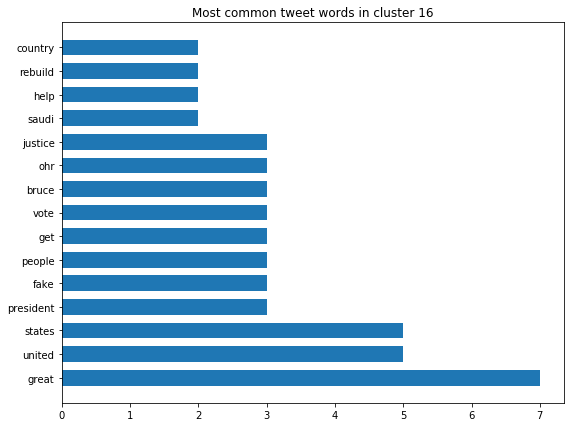

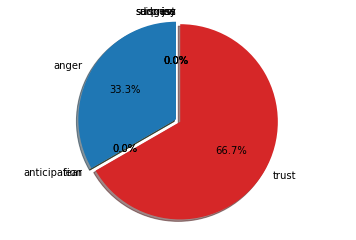

2929 - Earlier today, I spoke with @GovMattBevin of Kentucky regarding yesterday’s shooting at Marshall County High School. My thoughts and prayers are with Bailey Holt, Preston Cope, their families, and all of the wounded victims who are in recovery. We are with you!
2828 - The Fake News Media never fails. Hard to ignore this fact from the Vice President of Facebook Ads, Rob Goldman! https://t.co/XGC7ynZwYJ
364 - ....I can’t imagine any President having a better or closer relationship with their Vice President then the two of us. Just more FAKE NEWS, the Enemy of the People!
1723 - Tonight, it was my honor and privilege to nominate Judge Brett Kavanaugh to the United States Supreme Court. #SCOTUS https://t.co/97clc9zifm
1877 - Congresswoman Martha Roby of Alabama has been a consistent and reliable vote for our Make America Great Again Agenda. She is in a Republican Primary run-off against a recent Nancy Pelosi voting Democrat. I fully endorse Martha for Alabama 2nd Congressional Distr

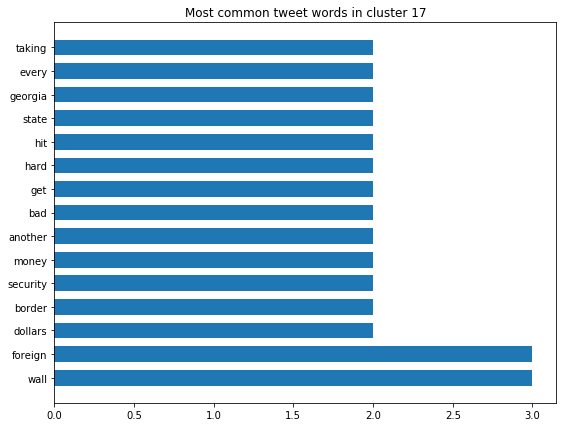

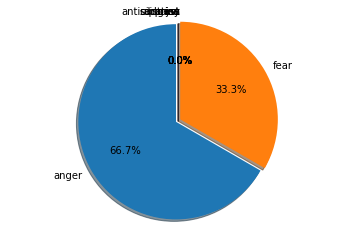

2800 - ....cameras running. Another False Accusation. Why doesn’t @washingtonpost report the story of the women taking money to make up stories about me? One had her home mortgage paid off. Only @FoxNews so reported...doesn’t fit the Mainstream Media narrative.
3017 - With that being said, I have personally directed the fix to the unmasking process since taking office and today’s vote is about foreign surveillance of foreign bad guys on foreign land. We need it! Get smart!
172 - Another very bad terror attack in France. We are going to strengthen our borders even more. Chuck and Nancy must give us the votes to get additional Border Security!
36 - The Wall is different than the 25 Billion Dollars in Border Security. The complete Wall will be built with the Shutdown money plus funds already in hand. The reporting has been inaccurate on the point. The problem is, without the Wall, much of the rest of Dollars are wasted!
770 - People have no idea how hard Hurricane Michael has hit the grea

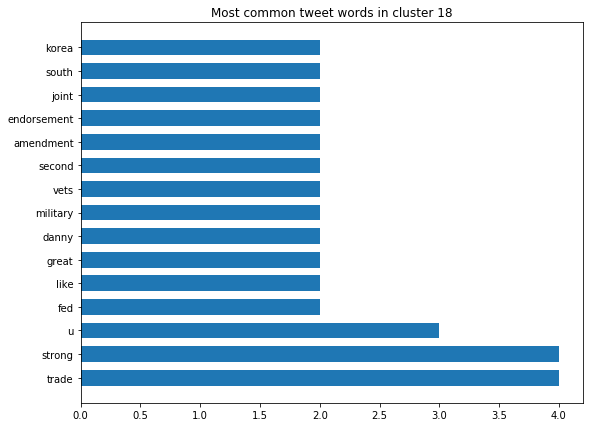

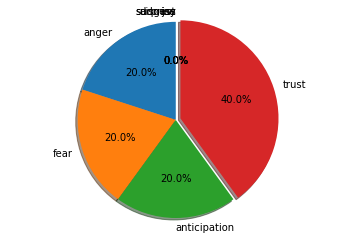

38 - The only problem our economy has is the Fed. They don’t have a feel for the Market, they don’t understand necessary Trade Wars or Strong Dollars or even Democrat Shutdowns over Borders. The Fed is like a powerful golfer who can’t score because he has no touch - he can’t putt!
2652 - Today the House took major steps toward securing our schools by passing the STOP School Violence Act. We must put the safety of America's children FIRST by improving training and by giving schools and law enforcement better tools. A tragedy like Parkland can't happen ever again!
1621 - Congratulations to @JudicialWatch and @TomFitton on being successful in getting the Carter Page FISA documents. As usual they are ridiculously heavily redacted but confirm with little doubt that the Department of “Justice” and FBI misled the courts. Witch Hunt Rigged, a Scam!
1178 - ...of money on joint U.S.-South Korea war games. Besides, the President can instantly start the joint exercises again with South Korea, and 

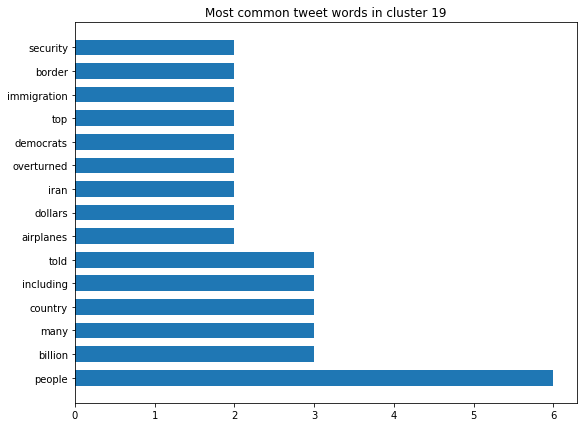

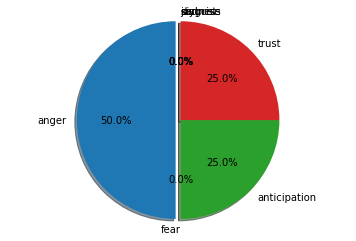

1511 - The Fake News Media is going CRAZY! They are totally unhinged and in many ways, after witnessing first hand the damage they do to so many innocent and decent people, I enjoy watching. In 7 years, when I am no longer in office, their ratings will dry up and they will be gone!
1395 - ...really bad things. Nasty to people &amp; would constantly miss meetings &amp; work. When Gen. Kelly came on board he told me she was a loser &amp; nothing but problems. I told him to try working it out, if possible, because she only said GREAT things about me - until she got fired!
1898 - We shouldn’t be hiring judges by the thousands, as our ridiculous immigration laws demand, we should be changing our laws, building the Wall, hire Border Agents and Ice and not let people come into our country based on the legal phrase they are told to say as their password.
217 - .....overturned, 9-0, in the United States Supreme Court. Doing same thing to people now. Will all of the substantial &amp; many contri

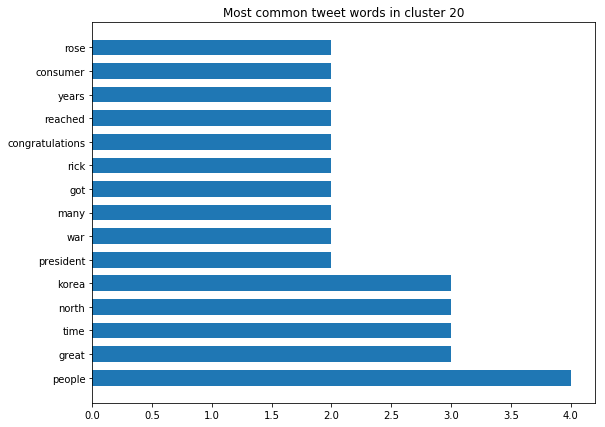

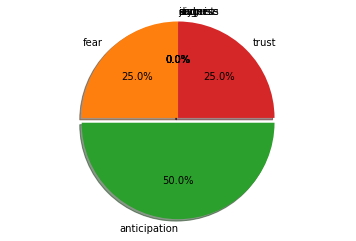

49 - Thanks @RandPaul  “I am very proud of the President. This is exactly what he promised, and I think the people agree with him. We’ve been at war too long and in too many places...spent several trillion dollars on these wars everywhere. He’s different...that’s why he got elected.”
887 - “Consumer confidence rose in September, notching its highest level in about 18 years. The Consumer Board's index rose to 138.4 this month from 134.7 in August...” https://t.co/ZbxjnrRvAX
1925 - If President Obama (who got nowhere with North Korea and would have had to go to war with many millions of people being killed) had gotten along with North Korea and made the initial steps toward a deal that I have, the Fake News would have named him a national hero!
357 - From day one Rick Scott never wavered. He was a great Governor and will be even a greater Senator in representing the People of Florida. Congratulations to Rick on having waged such a courageous and successful campaign!
2497 - Good luck to M

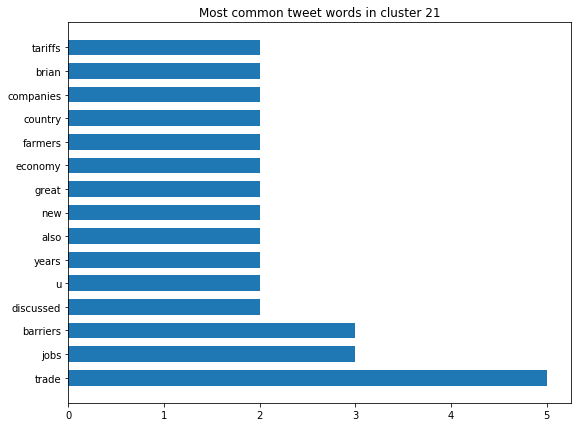

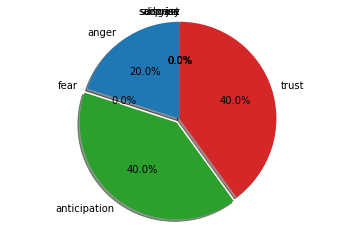

1196 - Our new Trade Deal with Mexico focuses on FARMERS, GROWTH for our country, tearing down TRADE BARRIERS, JOBS and having companies continue to POUR BACK INTO OUR COUNTRY. It will be a big hit!
54 - I just had a long and productive call with President @RT_Erdogan of Turkey. We discussed ISIS, our mutual involvement in Syria, &amp; the slow &amp; highly coordinated pullout of U.S. troops from the area. After many years they are coming home. We also discussed heavily expanded Trade.
2590 - My Administration stands in solidarity with the brave citizens in Orange County defending their rights against California's illegal and unconstitutional Sanctuary policies. California's Sanctuary laws....
946 - Financial and jobs numbers are fantastic. There are plenty of new, high paying jobs available in our great and very vibrant economy. If you are not happy where you are, start looking - but also remember, our economy is only getting better. Vote in Midterms!
1575 - Thank you Georgia! They sa

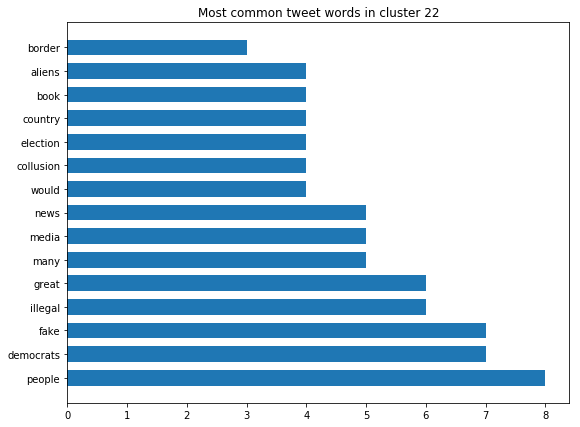

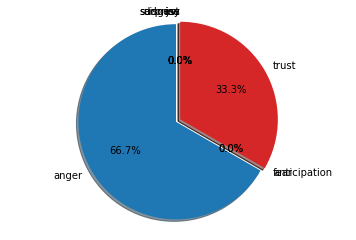

1360 - “People who enter the United States without our permission are illegal aliens and illegal aliens should not be treated the same as people who entered the U.S. legally.” Chuck Schumer in 2009, before he went left and haywire!  @foxandfriends
1958 - U.S.A. Jobs numbers are the BEST in 44 years. If my opponent (the Democrats) had won the election, they would have raised taxes substantially and increased regulations - the economy, and jobs, would have been a disaster!
1366 - “People who enter the United States without our permission are illegal aliens and illegal aliens should not be treated the same as people who enters the U.S. legally.”  Chuck Schumer in 2009, before he went left and haywire!  @foxandfriends
1632 - Farmers have been on a downward trend for 15 years. The price of soybeans has fallen 50% since 5 years before the Election. A big reason is bad (terrible) Trade Deals with other countries. They put on massive Tariffs and Barriers. Canada charges 275% on Dairy. Farmers 

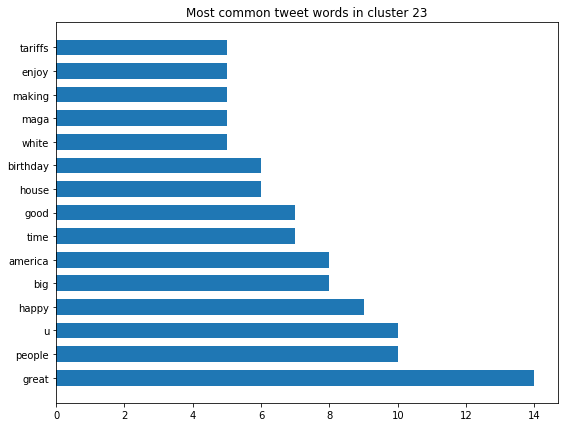

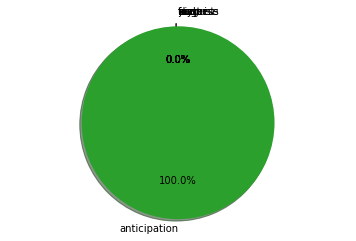

104 - After historic victories against ISIS, it’s time to bring our great young people home! https://t.co/xoNjFzQFTp
1970 - Congratulations to Danny Tarkanian on his big GOP primary win in Nevada. Danny worked hard an got a great result. Looking good in November!
2187 - Will be interviewed on @foxandfriends tomorrow morning at 6:00 A.M. Enjoy!
1887 - Farm Bill just passed in the House. So happy to see work requirements included. Big win for the farmers!
1232 - Happy birthday Vince, you are truly one of the greats! https://t.co/b8zV5MfojY
----------------------------------------
We have 97 words, of which 88 are unique
5
[('anger', 1.0), ('anticipation', 1.0), ('surprise', 1.0), ('fear', 0.0), ('trust', 0.0), ('sadness', 0.0), ('joy', 0.0), ('disgust', 0.0)]


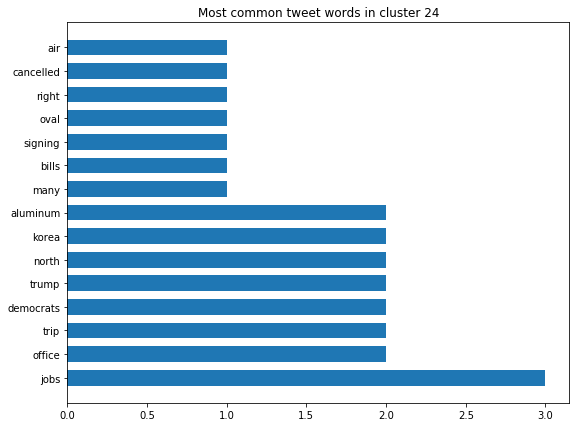

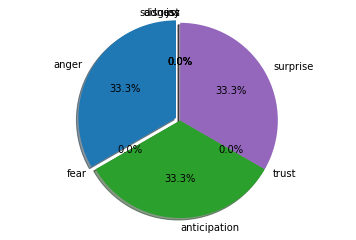

2541 - Despite the Aluminum Tariffs, Aluminum prices are DOWN 4%. People are surprised, I’m not! Lots of money coming into U.S. coffers and Jobs, Jobs, Jobs!
541 - “Donald Trump has made good on his promises, and it drives Democrats Crazy!” Brad Blakeman @FoxNews
69 - Some of the many Bills that I am signing in the Oval Office right now. Cancelled my trip on Air Force One to Florida while we wait to see if the Democrats will help us to protect America’s Southern Border! https://t.co/ws6LYhKcKl
2898 - Rasmussen just announced that my approval rating jumped to 49%, a far better number than I had in winning the Election, and higher than certain “sacred cows.” Other Trump polls are way up also. So why does the media refuse to write this? Oh well, someday!
1977 - Just landed - a long trip, but everybody can now feel much safer than the day I took office. There is no longer a Nuclear Threat from North Korea. Meeting with Kim Jong Un was an interesting and very positive experience. North Kore

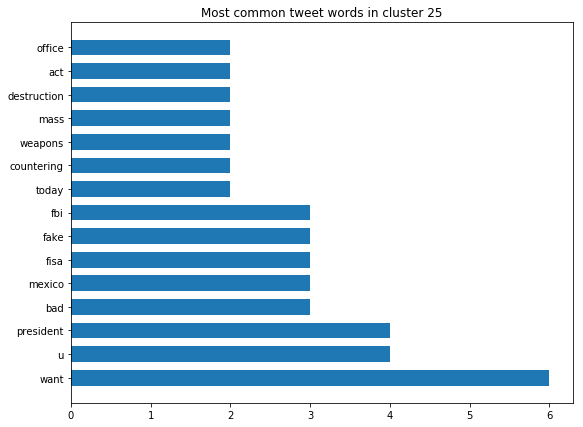

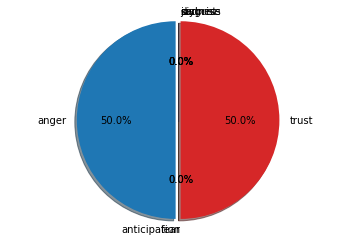

2895 - “The four page memo released Friday reports the disturbing fact about how the FBI and FISA appear to have been used to influence the 2016 election and its aftermath....The FBI failed to inform the FISA court that the Clinton campaign had funded the dossier....the FBI became....
2475 - Just hit 50% in the Rasmussen Poll, much higher than President Obama at same point. With all of the phony stories and Fake News, it’s hard to believe! Thank you America, we are doing Great Things.
929 - Judge Brett Kavanaugh is a fine man, with an impeccable reputation, who is under assault by radical left wing politicians who don’t want to know the answers, they just want to destroy and delay. Facts don’t matter. I go through this with them every single day in D.C.
2524 - Many dead, including women and children, in mindless CHEMICAL attack in Syria. Area of atrocity is in lockdown and encircled by Syrian Army, making it completely inaccessible to outside world. President Putin, Russia and Iran are

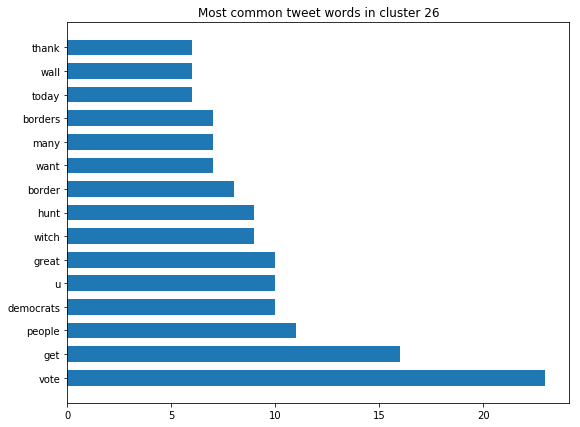

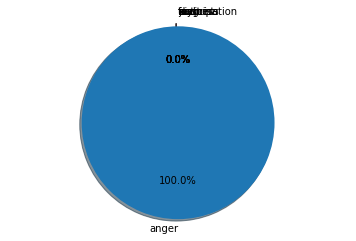

686 - Thank you Missoula, Montana. Get out and VOTE for @MattForMontana and @GregForMontana!! #MAGA????
https://t.co/6XgaceUu1e https://t.co/nEndInSOhw
1996 - Just won big Supreme Court decision on Voting! Great News!
2203 - If the person placed very early into my campaign wasn’t a SPY put there by the previous Administration for political purposes, how come such a seemingly massive amount of money was paid for services rendered - many times higher than normal...
1456 - A great night in Ohio’s 12th Congressional District with Troy Balderson! Troy loves Ohio, and he loves the people of Ohio. He will be fighting for you all the way...
2868 - Wow! -Senator Mark Warner got caught having extensive contact with a lobbyist for a Russian oligarch. Warner did not want a “paper trail” on a “private” meeting (in London) he requested with Steele of fraudulent Dossier fame. All tied into Crooked Hillary.
----------------------------------------
We have 488 words, of which 332 are unique
35
[('trust

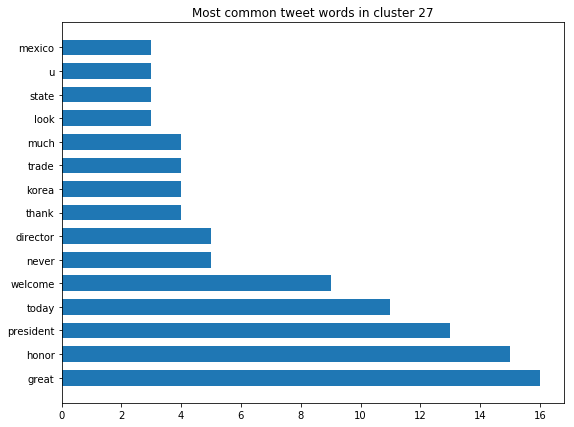

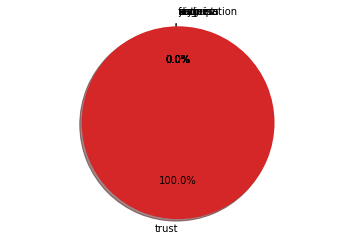

76 - There has never been a president who has been tougher (but fair) on China or Russia - Never, just look at the facts. The Fake News tries so hard to paint the opposite picture.
2889 - Little Adam Schiff, who is desperate to run for higher office, is one of the biggest liars and leakers in Washington, right up there with Comey, Warner, Brennan and Clapper! Adam leaves closed committee hearings to illegally leak confidential information. Must be stopped!
2046 - We must always protect those who protect us. Today, it was my great honor to sign the #VAMissionAct and to make Veterans Choice the permanent law of the land! https://t.co/VV3GdDISbD https://t.co/4OsUDWIzwo
994 - Thank you Brock – it is my honor!

“We (@FEMA) have never had the support that we have had from this President.” 
Administrator @FEMA_Brock
2542 - Thank you @WVGovernor Jim Justice. It was my great honor to be with the amazing people of West Virginia today! #MAGA https://t.co/IwPuQNadMM
-------------------------------

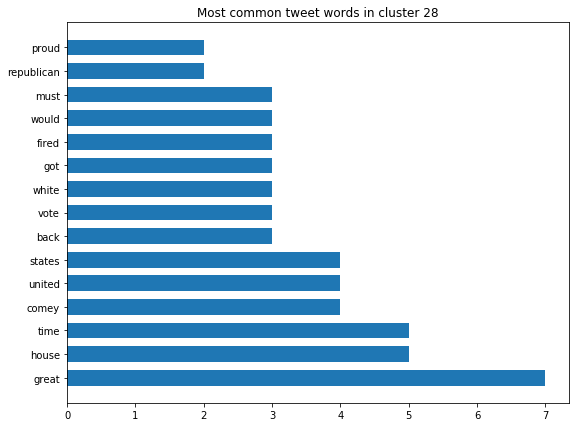

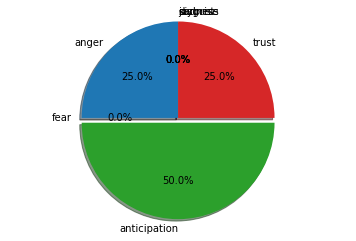

83 - No matter what happens today in the Senate, Republican House Members should be very proud of themselves. They flew back to Washington from all parts of the World in order to vote for Border Security and the Wall. Not one Democrat voted yes, and we won big. I am very proud of you!
175 - James Comey just totally exposed his partisan stance by urging his fellow Democrats to take back the White House in 2020. In other words, he is and has been a Democrat. Comey had no right heading the FBI at any time, but especially after his mind exploded!
1721 - NATO countries must pay MORE, the United States must pay LESS. Very Unfair!
963 - Happy 71st Birthday to our GREAT United States Air Force! https://t.co/r9Sa7DJQ76
1396 - Wacky Omarosa, who got fired 3 times on the Apprentice, now got fired for the last time. She never made it, never will. She begged me for a job, tears in her eyes, I said Ok. People in the White House hated her. She was vicious, but not smart. I would rarely see her but he

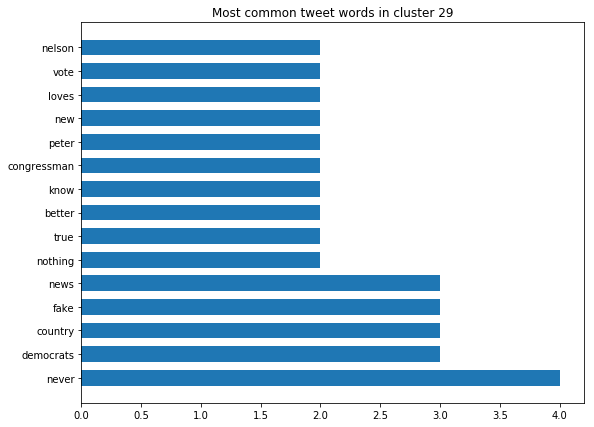

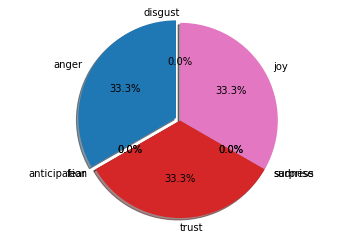

1404 - The big story that the Fake News Media refuses to report is lowlife Christopher Steele’s many meetings with Deputy A.G. Bruce Ohr and his beautiful wife, Nelly. It was Fusion GPS that hired Steele to write the phony &amp; discredited Dossier, paid for by Crooked Hillary &amp; the DNC....
1435 - Today, on the 236th anniversary of the Purple Heart, we honor the members of our Armed Forces for serving as the vanguard of American democracy and freedom around the world. #PurpleHeartDay https://t.co/NghmQ4BOKh
1825 - The face of the Democrats is now Maxine Waters who, together with Nancy Pelosi, have established a fine leadership team. They should always stay together and lead the Democrats, who want Open Borders and Unlimited Crime, well into the future....and pick Crooked Hillary for Pres.
1839 - Will be heading to one of my favorite places, South Carolina, to fight for one of my original “fighters,” Governor Henry McMaster. Speaking at 7:00 P.M.
3002 - Never said anything derogator

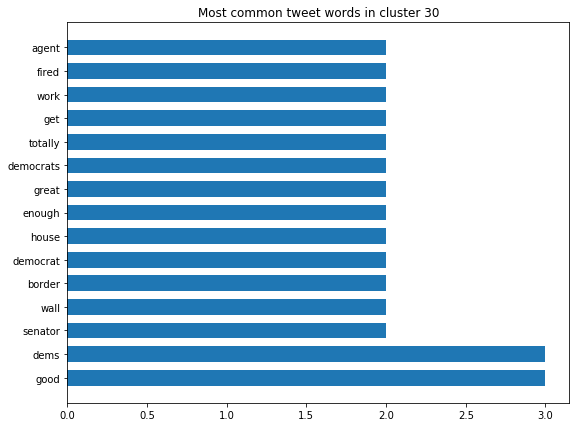

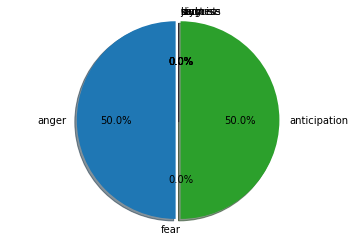

1008 - Senator Debbie Stabenow and the Democrats are totally against approving the Farm Bill. They are fighting tooth and nail to not allow our Great Farmers to get what they so richly deserve. Work requirements are imperative and the Dems are a NO. Not good!
86 - Senator Mitch McConnell should fight for the Wall and Border Security as hard as he fought for anything. He will need Democrat votes, but as shown in the House, good things happen. If enough Dems don’t vote, it will be a Democrat Shutdown! House Republicans were great yesterday!
2605 - Much can be done with the $1.6 Billion given to building and fixing the border wall. It is just a down payment. Work will start immediately. The rest of the money will come - and remember DACA, the Democrats abandoned you (but we will not)!
1391 - Just fired Agent Strzok, formerly of the FBI, was in charge of the Crooked Hillary Clinton sham investigation. It was a total fraud on the American public and should be properly redone!
1679 - ...over

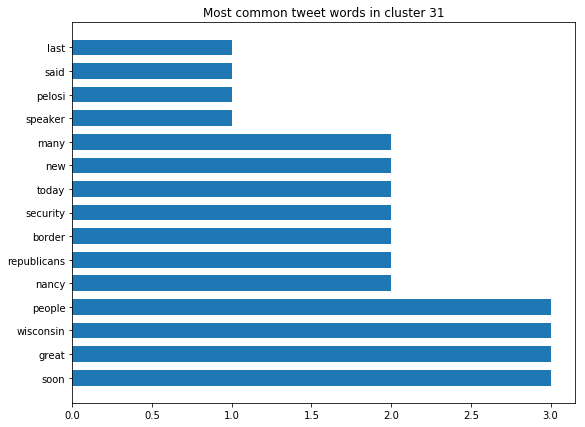

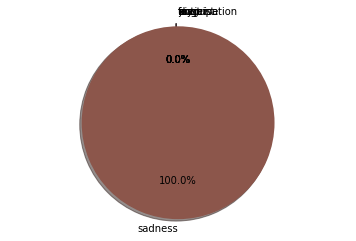

822 - Just out: 3.7% Unemployment is the lowest number since 1969!
624 - Just leaving Wisconsin. @ScottWalker and @LeahVukmir are fantastic people, badly needed for our Country! #MAGA https://t.co/6dLOBO6UQy
2356 - I recently had a terrific meeting with a bipartisan group of freshman lawmakers who feel very strongly in favor of Congressional term limits. I gave them my full support and endorsement for their efforts. #DrainTheSwamp
2440 - My thoughts, prayers and condolences are with the families, friends and colleagues of the two @GCSOFlorida deputies (HEROES) who lost their lives in the line of duty today.
1795 - I am in Milwaukee, Wisconsin, for meetings. Soon to leave for a big groundbreaking for Foxconn, which is building a great new electronics plant in Wisconsin. 15,000 Jobs, so great!
----------------------------------------
We have 169 words, of which 124 are unique
7
[('anger', 2.0), ('anticipation', 2.0), ('trust', 1.0), ('fear', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('j

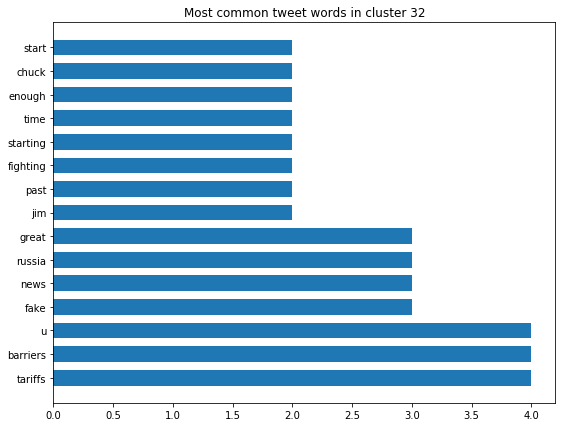

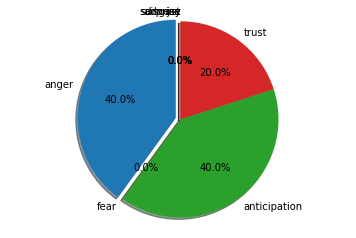

1640 - The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forward to our second meeting so that we can start implementing some of the many things discussed, including stopping terrorism, security for Israel, nuclear........
89 - General Jim Mattis will be retiring, with distinction, at the end of February, after having served my Administration as Secretary of Defense for the past two years. During Jim’s tenure, tremendous progress has been made, especially with respect to the purchase of new fighting....
1872 - Based on the Tariffs and Trade Barriers long placed on the U.S. and it great companies and workers by the European Union, if these Tariffs and Barriers are not soon broken down and removed, we will be placing a 20% Tariff on all of their cars coming into the U.S. Build them here!
867 - Wow! Just starting to hear the Democrats, who are only thinking Obstruct and Delay, are starting to put out the word that the “time” 

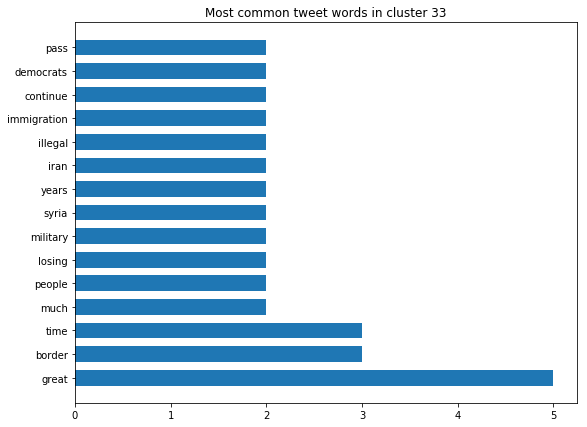

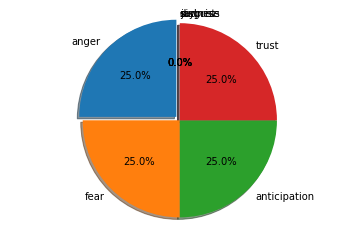

2279 - Iran’s Military Budget is up more than 40% since the Obama negotiated Nuclear Deal was reached...just another indicator that it was all a big lie. But not anymore!
2719 - We are on the losing side of almost all trade deals. Our friends and enemies have taken advantage of the U.S. for many years. Our Steel and Aluminum industries are dead. Sorry, it’s time for a change! MAKE AMERICA GREAT AGAIN!
1403 - ....Do you believe Nelly worked for Fusion and her husband STILL WORKS FOR THE DEPARTMENT OF “JUSTICE.” I have never seen anything so Rigged in my life. Our A.G. is scared stiff and Missing in Action. It is all starting to be revealed - not pretty. IG Report soon?  Witch Hunt!
100 - Getting out of Syria was no surprise. I’ve been campaigning on it for years, and six months ago, when I very publicly wanted to do it, I agreed to stay longer. Russia, Iran, Syria &amp; others are the local enemy of ISIS. We were doing there work. Time to come home &amp; rebuild. #MAGA
642 - At stake in

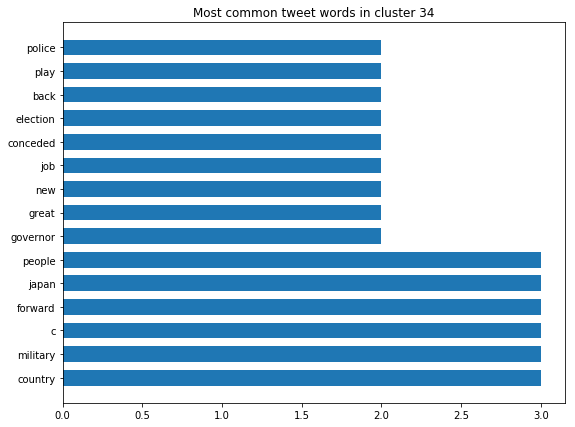

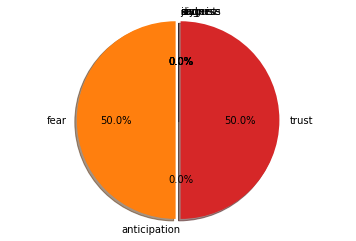

1896 - I will be going the Columbia, South Carolina, on Monday night to do a campaign speech for one of my very early supporters, a man who truly loves the people of South Carolina, Governor Henry McMaster. Henry worked so hard &amp; was so loyal to me that I look forward to reciprocating!
431 - Mayor Gillum conceded on Election Day and now Broward County has put him “back into play.” Bill Nelson conceded Election - now he’s back in play!? This is an embarrassment to our Country and to Democracy!
2683 - North Korea has not conducted a Missile Test since November 28, 2017 and has promised not to do so through our meetings. I believe they will honor that commitment!
810 - Departing Washington, D.C. for the International Association of Chiefs of Police Annual Convention in Orlando, Florida. Look forward to seeing everyone soon! #IACP2018 https://t.co/EwSd7IU9t1
2914 - Taliban targeted innocent Afghans, brave police in Kabul today. Our thoughts and prayers go to the victims, and first resp

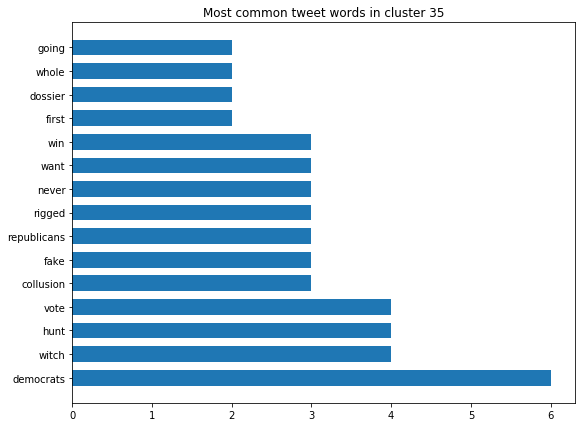

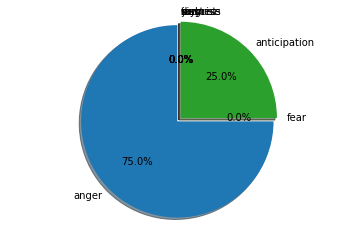

1706 - If the Democrats want to win Supreme Court and other Court picks, don’t Obstruct and Resist, but rather do it the good ol’ fashioned way, WIN ELECTIONS!
1660 - The Democrats want to abolish ICE, which will mean more crime in our country. I want to give ICE a big cheer! Vote Republican in November.
2246 - Despite the disgusting, illegal and unwarranted Witch Hunt, we have had the most successful first 17 month Administration in U.S. history - by far! Sorry to the Fake News Media and “Haters,” but that’s the way it is!
118 - Michael Isikoff was the first to report Dossier allegations and now seriously doubts the Dossier claims. The whole Russian Collusion thing was a HOAX, but who is going to restore the good name of so many people whose reputations have been destroyed?
1783 - I never pushed the Republicans in the House to vote for the Immigration Bill, either GOODLATTE 1 or 2, because it could never have gotten enough Democrats as long as there is the 60 vote threshold. I release

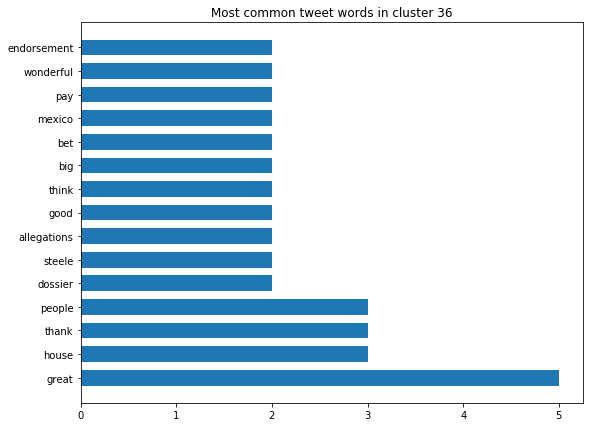

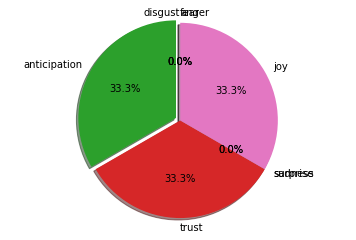

2357 - Numerous countries are being considered for the MEETING, but would Peace House/Freedom House, on the Border of North &amp; South Korea, be a more Representative, Important and Lasting site than a third party country? Just asking!
3013 - Small Business Poll has highest approval numbers in the polls history. All business is just at the beginning of something really special!
2744 - Starting at a small Bible School in Florida, Billy Graham soon led a nationwide revival. From a large tent in Los Angeles, to one hundred thousand people in a single day at Yankee Stadium, to more than two million people at Madison Square Garden over sixteen weeks in 1957... https://t.co/z1vvAemlBP
857 - Great reviews on the new USMCA. Thank you! Mexico and Canada will be wonderful partners in Trade (and more) long into the future.
120 - Russia Dossier reporter now doubts dopey Christopher Steele’s claims! “When you get into the details of the Steele Dossier, the specific allegations, we have not seen th

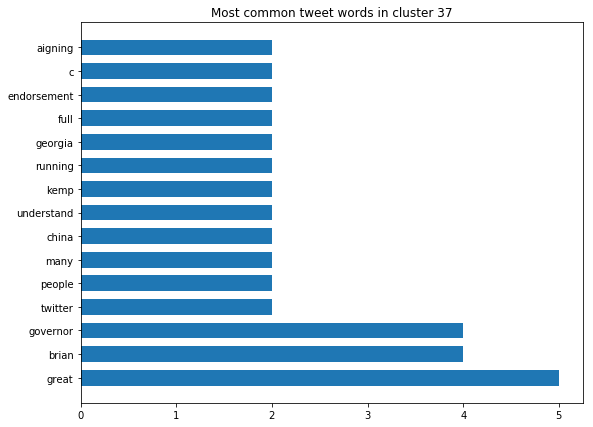

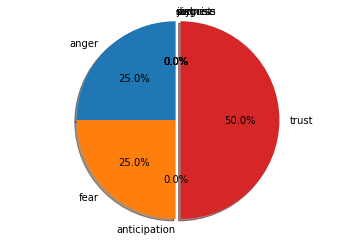

1624 - Brian Kemp, who is running for Governor of Georgia and has my full endorsement, is campaigning tonight with VP @mike_pence. Brian is very strong on Crime and Borders, LOVES our Military, Vets and the 2nd Amendment. He will be a GREAT Governor!
1625 - Brian Kemp, who is running for Governor of Georgia and has my full endorsement, is campaigning tonight with @MikePenceVP. Brian is very strong on Crime and Borders, LOVES our Military, Vets and the 2nd Amendment. He will be a GREAT Governor!
965 - China has openly stated that they are actively trying to impact and change our election by attacking our farmers, ranchers and industrial workers because of their loyalty to me. What China does not understand is that these people are great patriots and fully understand that.....
2325 - NBC NEWS is wrong again! They cite “sources” which are constantly wrong. Problem is, like so many others, the sources probably don’t exist, they are fabricated, fiction! NBC, my former home with the Apprenti

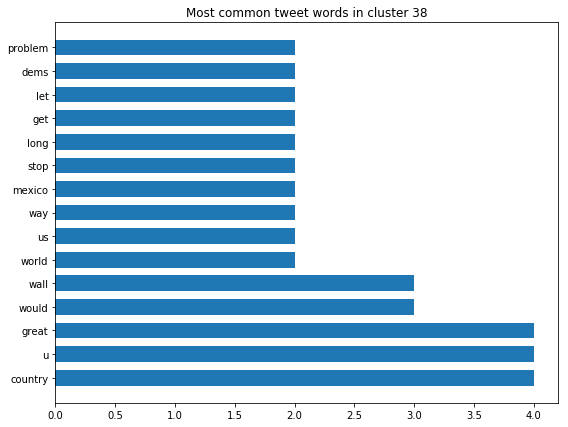

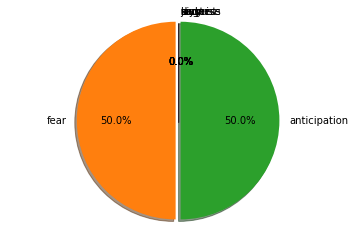

1259 - The only thing that I have done wrong is to win an election that was expected to be won by Crooked Hillary Clinton and the Democrats. The problem is, they forgot to campaign in numerous states!
1184 - Consumer Confidence Index, just out, is the HIGHEST IN 18 YEARS! Also, GDP revised upward to 4.2 from 4.1. Our country is doing great!
321 - Would be very SMART if Mexico would stop the Caravans long before they get to our Southern Border, or if originating countries would not let them form (it is a way they get certain people out of their country and dump in U.S. No longer). Dems created this problem. No crossings!
1368 - “Hope and Change in an Alabama Coal Mine” https://t.co/IwLEO9ff9X
1472 - “The media are good news fire extinguishers!” @greggutfeld @TheFive
----------------------------------------
We have 285 words, of which 227 are unique
17
[('fear', 1.0), ('anticipation', 1.0), ('trust', 1.0), ('anger', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('joy', 0.0), ('disgust', 0.0

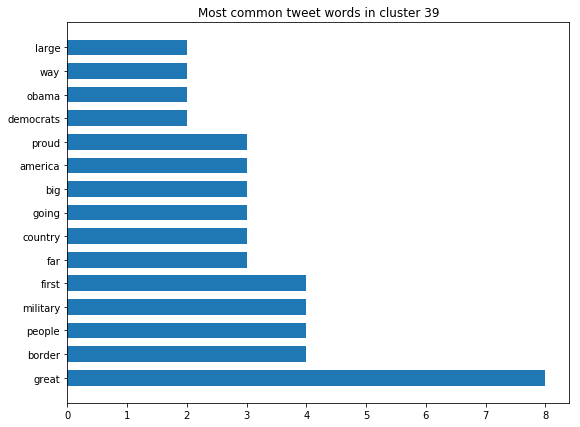

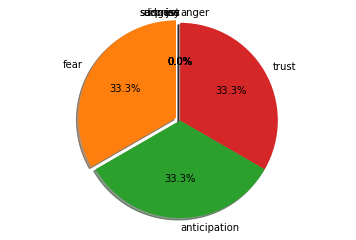

933 - Landing in Las Vegas now for a Make America Great Again Rally supporting @DeanHeller and @DannyTarkanian. Also doing interview there with @seanhannity live on @FoxNews. Big crowd, long lines. Will be great! #MAGA
2499 - California Governor Jerry Brown is doing the right thing and sending the National Guard to the Border. Thank you Jerry, good move for the safety of our Country!
2229 - Happy #ArmedForcesDay to our GREAT military men and women for their selfless service to our Nation! https://t.co/jbJvrkV1hH
2220 - ....and why hasn’t the Podesta brother been charged and arrested, like others, after being forced to close down his very large and successful firm? Is it because he is a VERY well connected Democrat working in the Swamp of Washington, D.C.?
2483 - So proud of our great Military which will soon be, after the spending of billions of fully approved dollars, the finest that our Country has ever had. There won’t be anything, or anyone, even close!
----------------------------

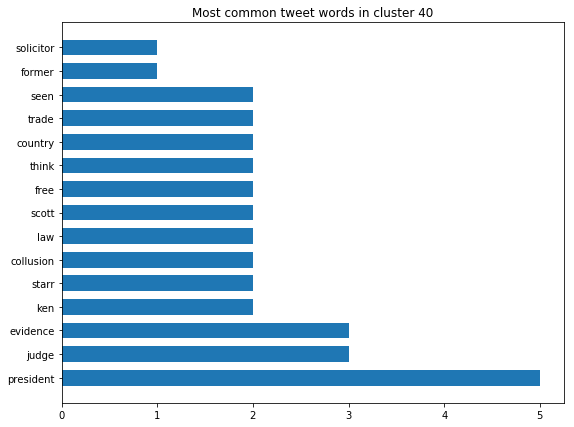

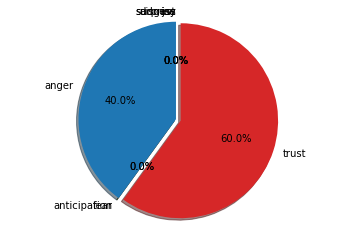

2757 - “We’ve seen NO EVIDENCE OF COLLUSION....I have seen nothing, the firing of James Comey and all of the aftermath, that suggests that the President has obstructed justice because he’s exercising his power as the President of the U.S. I just don’t see it.”  Judge Ken Starr
252 - ....his wife and father-in-law (who has the money?) off Scott Free. He lied for this outcome and should, in my opinion, serve a full and complete sentence.
2132 - Rep.Trey Gowdy, “I don’t think so, I think what the President is doing is expressing frustration that Attorney General Sessions should have shared these reasons for recusal before he took the job, not afterward. If I were the President and I picked someone to be the country’s....
137 - Judge Ken Starr, former Solicitor Generel &amp; Independent Counsel, just stated that, after two years, “there is no evidence or proof of collusion” &amp; further that “there is no evidence that there was a campaign financing violation involving the President.” Than

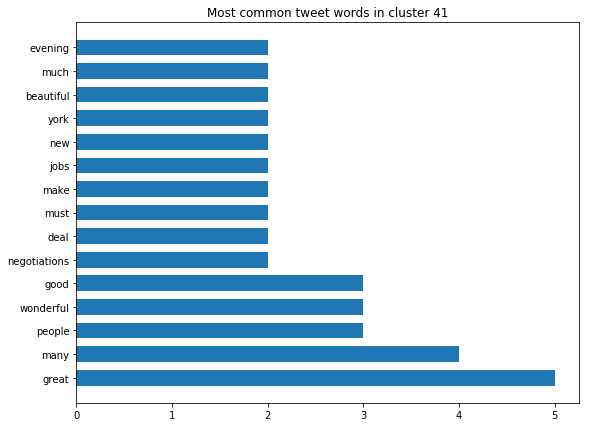

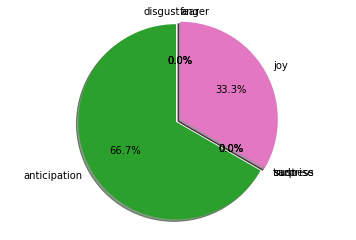

751 - Princess Eugenie of York was a truly beautiful bride yesterday. She has been through so much, and has come out a total winner!
153 - Many people have asked how we are doing in our negotiations with North Korea - I always reply by saying we are in no hurry, there is wonderful potential for great economic success for that country....
1033 - The safety of American people is my absolute highest priority. Heed the directions of your State and Local Officials. Please be prepared, be careful and be SAFE! https://t.co/YP7ssITwW9 https://t.co/LZIUCgdPTH
939 - Congratulations to my good friend Prime Minister @AbeShinzo on his HUGE election victory in Japan. I’m looking forward to many more years of working together. See you in New York next week!????????
1815 - Big and conclusive win by Mitt Romney. Congratulations! I look forward to working together - there is so much good to do. A great and loving family will be coming to D.C.
----------------------------------------
We have 434 words, o

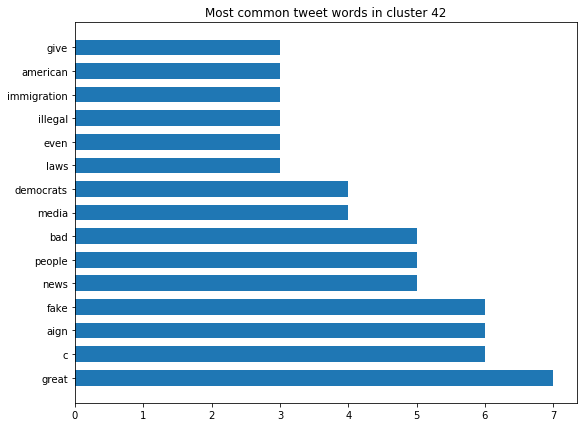

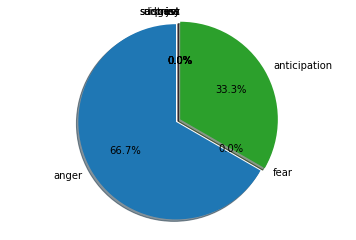

668 - Leaving Arizona after a fantastic Rally last night, in Mesa, honoring, and for, Martha @RepMcSally McSally. She is an inspiration &amp; will be a GREAT SENATOR for the people of Arizona. Her opponent is a Nancy Pelosi puppet, really bad for State. Early Voting NOW! Will be back soon.
1981 - My political representatives didn’t want me to get involved in the Mark Sanford primary thinking that Sanford would easily win - but with a few hours left I felt that Katie was such a good candidate, and Sanford was so bad, I had to give it a shot. Congrats to Katie Arrington!
1931 - Why don’t the Democrats give us the votes to fix the world’s worst immigration laws? Where is the outcry for the killings and crime being caused by gangs and thugs, including MS-13, coming into our country illegally?
279 - With all of the new books coming out you can't forget two of the great originals written by @GreggJarrett and @JudgeJeanine Pirro. Their books both went to #1. Go get them now, the phony Witch H

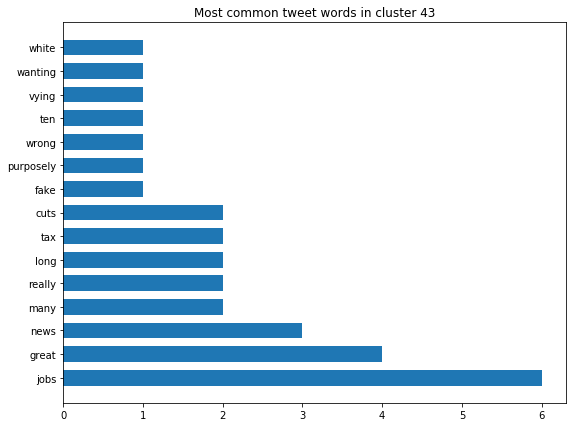

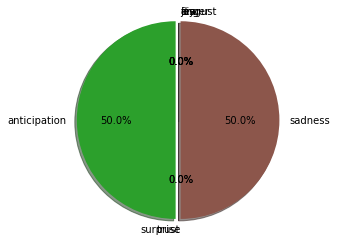

3016 - Great news, as a result of our TAX CUTS &amp; JOBS ACT! https://t.co/SLvhLxP3Jl
2930 - Tremendous investment by companies from all over the world being made in America. There has never been anything like it. Now Disney, J.P. Morgan Chase and many others. Massive Regulation Reduction and Tax Cuts are making us a powerhouse again. Long way to go! Jobs, Jobs, Jobs!
2327 - Because Jobs in the U.S. are doing so well, Americans receiving unemployment aid is the lowest since 1973. Great!
176 - Fake News has it purposely wrong. Many, over ten, are vying for and wanting the White House Chief of Staff position. Why wouldn’t someone want one of the truly great and meaningful jobs in Washington. Please report news correctly. Thank you!
281 - ....They have really done a great job in capturing my long-held views and ideas. This book is on sale now - a terrific read of a really interesting subject!
----------------------------------------
We have 892 words, of which 559 are unique
56
[('antici

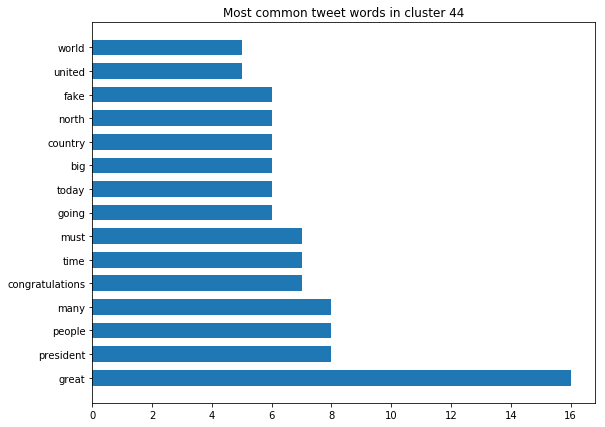

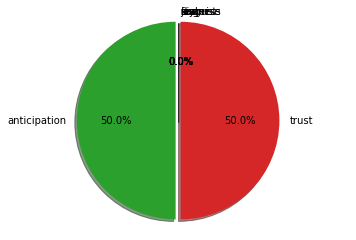

2468 - Getting ready to meet Prime Minister Abe of Japan, a truly fine gentleman!
1574 - Great to be back on track with the European Union. This was a big day for free and fair trade!
1830 - ....We are getting other countries to reduce and eliminate tariffs and trade barriers that have been unfairly used for years against our farmers, workers and companies. We are opening up closed markets and expanding our footprint. They must play fair or they will pay tariffs!
954 - ....returned home to the United States. Also, North and South Korea will file a joint bid to host the 2032 Olympics. Very exciting!
927 - I will Chair the United Nations Security Council meeting on Iran next week!
----------------------------------------
We have 209 words, of which 176 are unique
15
[('trust', 1.0), ('joy', 1.0), ('anger', 0.0), ('fear', 0.0), ('anticipation', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('disgust', 0.0)]


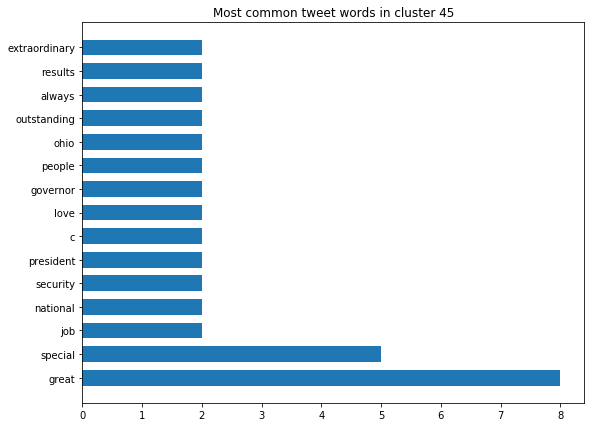

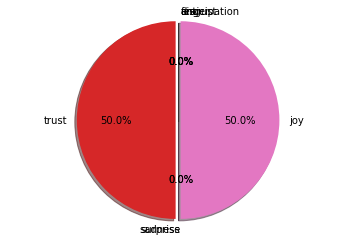

2081 - The appointment of the Special Counsel is totally UNCONSTITUTIONAL! Despite that, we play the game because I, unlike the Democrats, have done nothing wrong!
1433 - .....Congratulations to Troy Balderson on a great win in Ohio. A very special and important race!
904 - Brett Kavanaugh and his wife, Ashley, will be interviewed tonight at 7pmE on @marthamaccallum @FoxNews. This is an outstanding family who must be treated fairly!
551 - .@MikeDeWine will be a great Governor for the People of Ohio. He is an outstanding man who loves his State – and always produces big....
2926 - Great bilateral meeting with Prime Minister Theresa May of the United Kingdom, affirming the special relationship and our commitment to work together on key national security challenges and economic opportunities. #WEF18 https://t.co/FPP8aRDAyt
----------------------------------------
We have 143 words, of which 122 are unique
6
[('trust', 2.0), ('fear', 1.0), ('anticipation', 1.0), ('anger', 0.0), ('surprise'

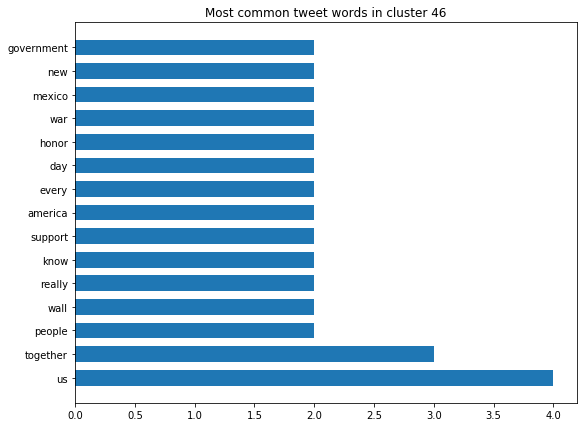

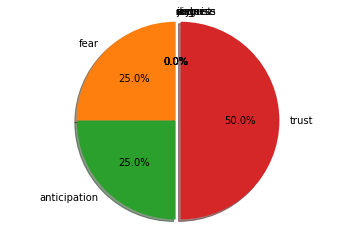

1225 - Our relationship with Mexico is getting closer by the hour. Some really good people within both the new and old government, and all working closely together....A big Trade Agreement with Mexico could be happening soon!
179 - ....People do not yet realize how much of the Wall, including really effective renovation, has already been built. If the Democrats do not give us the votes to secure our Country, the Military will build the remaining sections of the Wall. They know how important it is!
1333 - How can “Senator” Richard Blumenthal, who went around for twenty years as a Connecticut politician bragging that he was a great Marine war hero in Vietnam (then got caught and sobbingly admitted he was neither a Marine nor ever in Vietnam), pass judgement on anyone? Loser!
377 - It is our sacred duty to support America’s Service Members every single day they wear the uniform – and every day after when they return home as Veterans. Together we will HONOR those who defend us, we will CHE

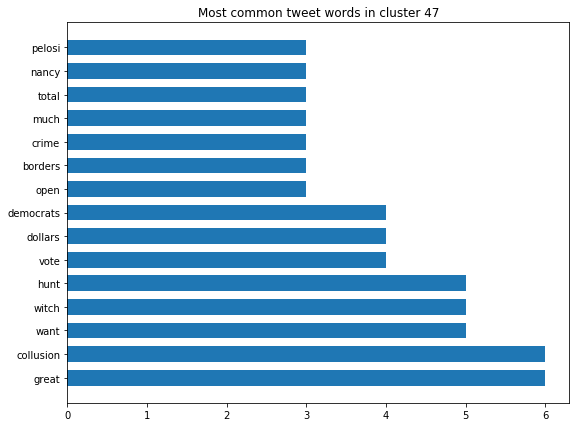

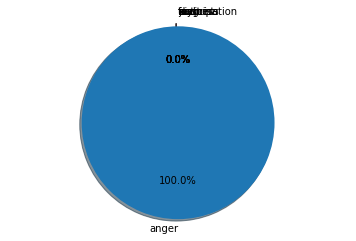

907 - Today, we commit to fighting the drug epidemic together! #UNGA https://t.co/XgaYTOBrSK
2580 - While we are on the subject, it is reported that the U.S. Post Office will lose $1.50 on average for each package it delivers for Amazon. That amounts to Billions of Dollars. The Failing N.Y. Times reports that “the size of the company’s lobbying staff has ballooned,” and that...
1778 - The Liberal Left, also known as the Democrats, want to get rid of ICE, who do a fantastic job, and want Open Borders. Crime would be rampant and uncontrollable! Make America Great Again
1617 - I had a GREAT meeting with Putin and the Fake News used every bit of their energy to try and disparage it. So bad for our country!
271 - ....Lightly looked at doing a building somewhere in Russia. Put up zero money, zero guarantees and didn’t do the project. Witch Hunt!
----------------------------------------
We have 97 words, of which 89 are unique
6
[('trust', 2.0), ('fear', 1.0), ('anger', 0.0), ('anticipation',

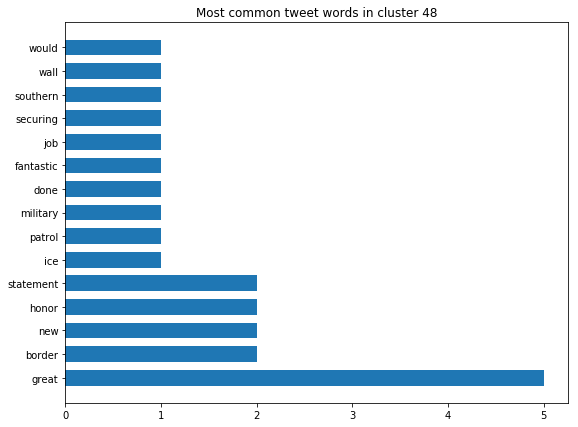

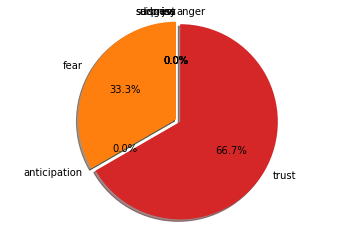

2589 - ....release known dangerous criminals into communities across the State. All citizens have the right to be protected by Federal law and strong borders.
182 - .....Ice, Border Patrol and our Military have done a FANTASTIC job of securing our Southern Border. A Great Wall would be, however, a far easier &amp; less expensive solution. We have already built large new sections &amp; fully renovated others, making them like new. The Democrats,.....
809 - It was my great honor to address the International Association of Chiefs of Police Annual Convention in Orlando, Florida. Thank you! #IACP2018 #LESM https://t.co/Z0nY5bSNr6
470 - Just landed in Fort Wayne, Indiana for a #MAGARally at the Allen County War Memorial Coliseum. See everyone soon! https://t.co/0pWiwCHGbh
2108 - Today, it was my great honor to be with the brave men and women of the United States Coast Guard! https://t.co/RAyPbOGXuZ
----------------------------------------
We have 131 words, of which 109 are unique
6
[('trust

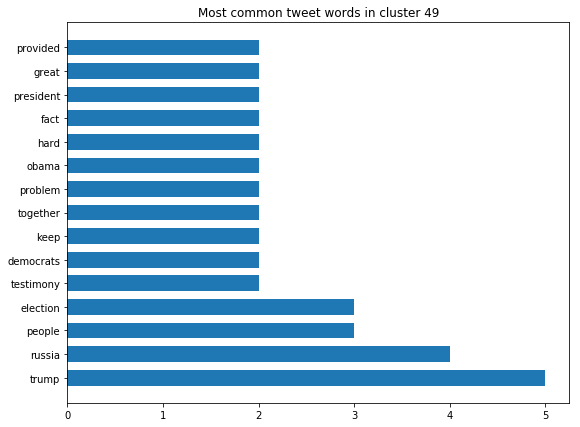

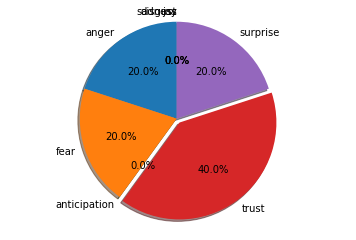

1653 - Some people HATE the fact that I got along well with President Putin of Russia. They would rather go to war than see this. It’s called Trump Derangement Syndrome!
1595 - I’m very concerned that Russia will be fighting very hard to have an impact on the upcoming Election. Based on the fact that no President has been tougher on Russia than me, they will be pushing very hard for the Democrats. They definitely don’t want Trump!
184 - “Former FBI Director James Comey under fire for his testimony acknowledging he knew that the Democrats paid for that phony Trump Dossier.” @LouDobbs  Details on Tuesday night.
2314 - To the great people of West Virginia we have, together, a really great chance to keep making a big difference. Problem is, Don Blankenship, currently running for Senate, can’t win the General Election in your State...No way! Remember Alabama. Vote Rep. Jenkins or A.G. Morrisey!
314 - ....children from parents, as did Bush etc., because that is the policy and law. I tried to

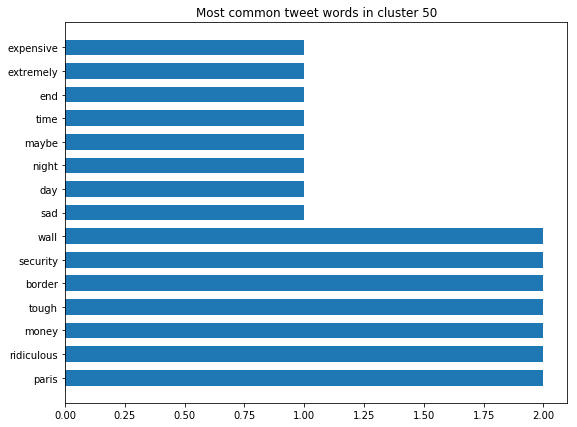

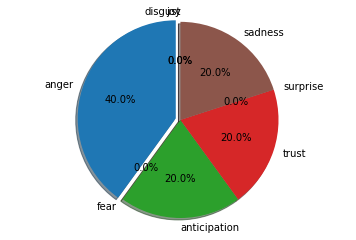

2663 - “According to the Center for Immigration Studies, the $18 billion wall will pay for itself by curbing the importation of crime, drugs and illegal immigrants who tend to go on the federal dole...” https://t.co/NdLC6jZwWE
737 - Now that her claims of being of Indian heritage have turned out to be a scam and a lie, Elizabeth Warren should apologize for perpetrating this fraud against the American Public. Harvard called her “a person of color” (amazing con), and would not have taken her otherwise!
197 - Very sad day &amp; night in Paris. Maybe it’s time to end the ridiculous and extremely expensive Paris Agreement and return money back to the people in the form of lower taxes? The U.S. was way ahead of the curve on that and the only major country where emissions went down last year!
366 - Congratulations to Andrew Gillum on having run a really tough and competitive race for Governor of the Great State of Florida. He will be a strong Democrat warrior long into the future - a force to

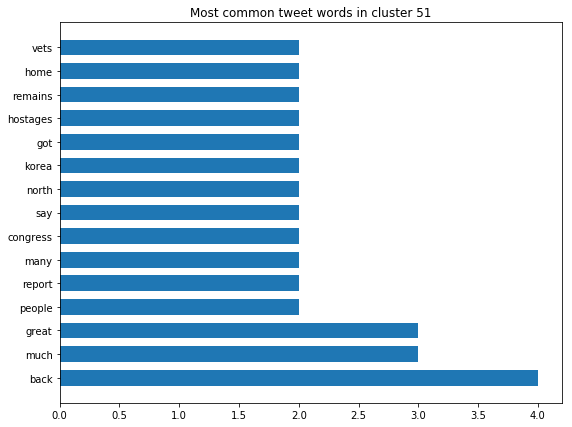

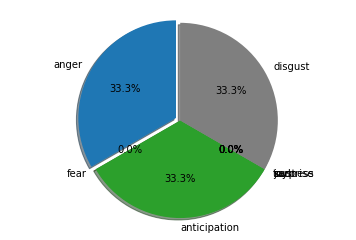

1941 - Funny how the Fake News, in a coordinated effort with each other, likes to say I gave sooo much to North Korea because I “met.” That’s because that’s all they have to disparage! We got so much for peace in the world, &amp; more is being added in finals. Even got our hostages/remains!
1319 - ...I say Andrew’s was a bigger and more incompetent blunder. He should easily win his race against a Super Liberal Actress, but his political career is over!
2330 - This spring marks 4yrs since the Phoenix VA crisis. We won't forget what happened to our GREAT VETS. Choice is vital, but the program needs work &amp; is running out of $. Congress must fix Choice Program by Memorial Day so VETS can get the care they deserve. I will sign immediately!
313 - Mexico should move the flag waving Migrants, many of whom are stone cold criminals, back to their countries. Do it by plane, do it by bus, do it anyway you want, but they are NOT coming into the U.S.A. We will close the Border permanently if nee

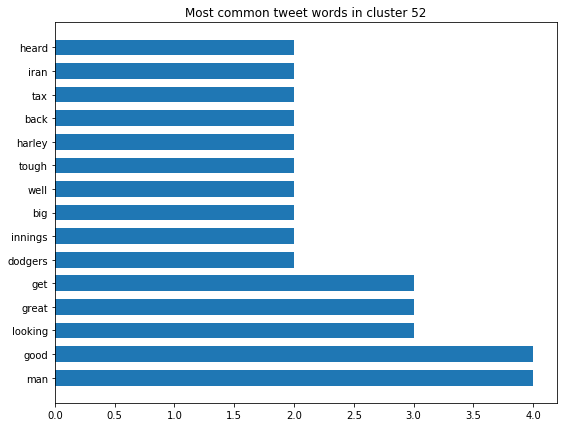

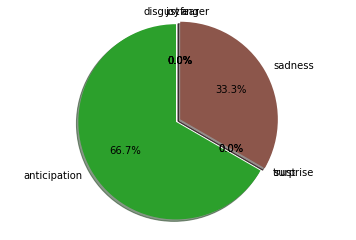

1072 - Our Social Media (and beyond) Stars, @DiamondandSilk, are terrific people who are doing really well. We are all very proud of them, and their great success!
1829 - ....When I had Harley-Davidson officials over to the White House, I chided them about tariffs in other countries, like India, being too high. Companies are now coming back to America. Harley must know that they won’t be able to sell back into U.S. without paying a big tax!
2274 - Remember how badly Iran was behaving with the Iran Deal in place. They were trying to take over the Middle East by whatever means necessary. Now, that will not happen!
1310 - All of the fools that are so focused on looking only at Russia should start also looking in another direction, China. But in the end, if we are smart, tough and well prepared, we will get along with everyone!
582 - Watching the Dodgers/Red Sox final innings. It is amazing how a manager takes out a pitcher who is loose &amp; dominating through almost 7 innings, Rich Hill 

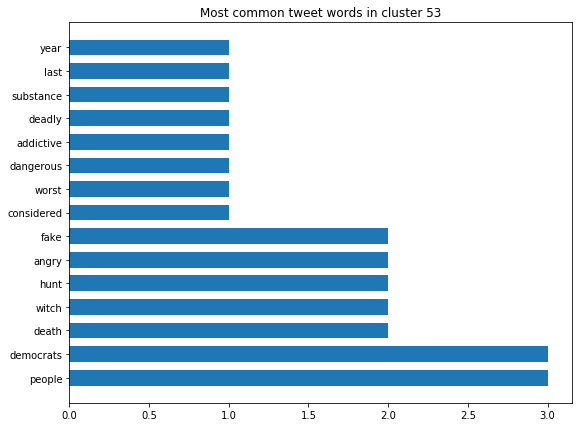

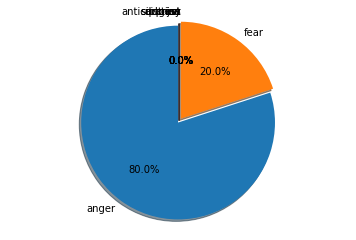

232 - .....considered to be the worst and most dangerous, addictive and deadly substance of them all. Last year over 77,000 people died from Fentanyl. If China cracks down on this “horror drug,” using the Death Penalty for distributors and pushers, the results will be incredible!
1718 - I am on Air Force One flying to NATO and hear reports that the FBI lovers, Peter Strzok and Lisa Page are getting cold feet on testifying about  the Rigged Witch Hunt headed by 13 Angry Democrats and people that worked for Obama for 8 years. Total disgrace!
2040 - When and where will all of the many conflicts of interest be listed by the 13 Angry Democrats (plus) working on the Witch Hunt Hoax. There has never been a group of people on a case so biased or conflicted. It is all a Democrat Excuse for LOSING the Election. Where is the server?
2051 - The Fake News Media has been so unfair, and vicious, to my wife and our great First Lady, Melania. During her recovery from surgery they reported everything fr

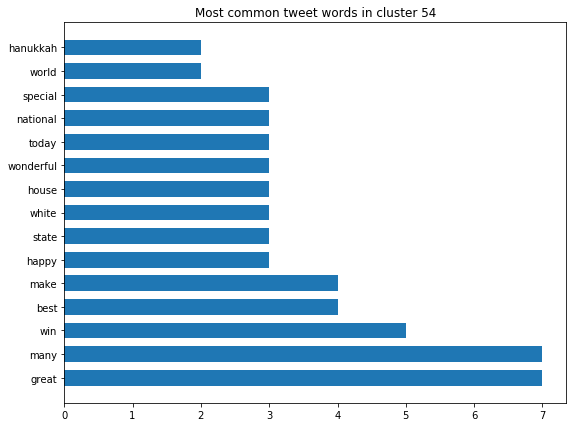

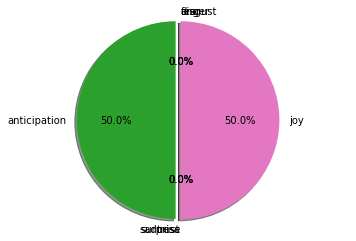

2379 - So great to have Staff Sgt. Dan Nevins and the incredible WOUNDED WARRIORS with me in the White House yesterday. These are truly brave and special people! @foxandfriends
853 - “USMCA Wins Praise as a Victory for American Industries and Workers”??https://t.co/UWhPhNXiiL https://t.co/eBVv0nXXRT
260 - This week, Jews around the world will celebrate the miracles of Hanukkah. @FLOTUS Melania and I send our very best wishes for a blessed and Happy Hanukkah! https://t.co/LrnGcc86w4 https://t.co/Kdjeyvkzmb
2602 - Happy National #MedalOfHonorDay to our HEROES. We love you! https://t.co/6euI31R4Gz
373 - PRESIDENTIAL MEDAL OF FREEDOM https://t.co/Mgeg4wijTk
----------------------------------------
We have 130 words, of which 112 are unique
7
[('anticipation', 2.0), ('trust', 1.0), ('sadness', 1.0), ('anger', 0.0), ('fear', 0.0), ('surprise', 0.0), ('joy', 0.0), ('disgust', 0.0)]


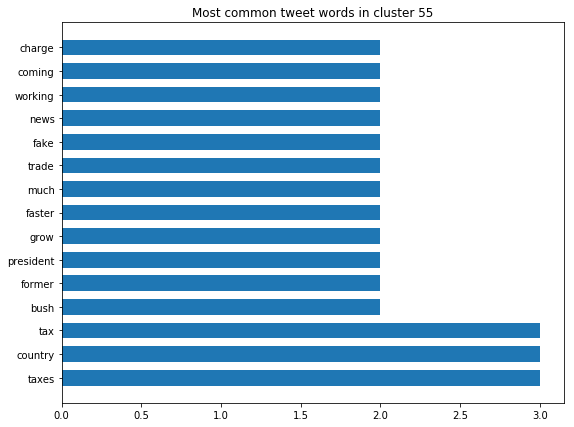

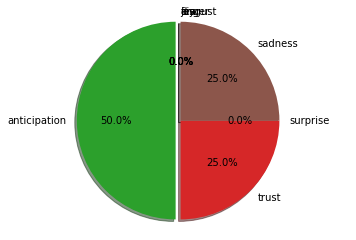

1452 - ..Because of Tariffs we will be able to start paying down large amounts of the $21 Trillion in debt that has been accumulated, much by the Obama Administration, while at the same time reducing taxes for our people. At minimum, we will make much better Trade Deals for our country!
2297 - The Fake News is working overtime. Just reported that, despite the tremendous success we are having with the economy &amp; all things else, 91% of the Network News about me is negative (Fake). Why do we work so hard in working with the media when it is corrupt? Take away credentials?
1790 - Six months after our TAX CUTS, more than 6 MILLION workers have received bonuses, pay raises, and retirement account contributions.
#TaxCutsandJobsAct https://t.co/MevjwIINGU
261 - ....However, out of respect for the Bush Family and former President George H.W. Bush we will wait until after the funeral to have a press conference.
952 - ....it was impossible - and then already it’s over 4%, and I expect it’s go

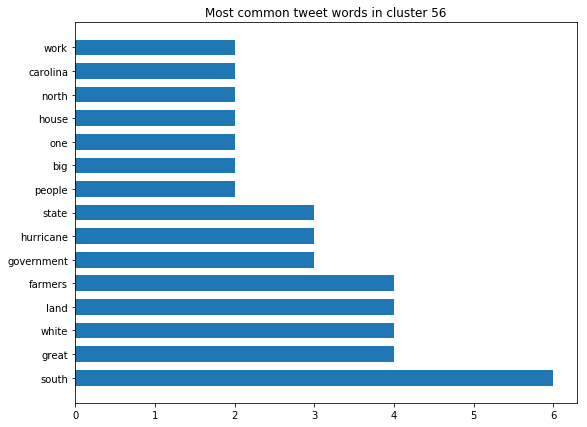

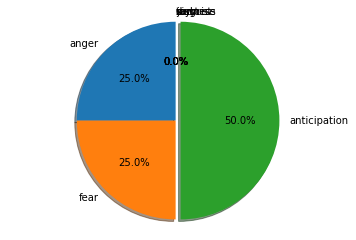

268 - To the Great people of Alaska. You have been hit hard by a “big one.” Please follow the directions of the highly trained professionals who are there to help you. Your Federal Government will spare no expense. God Bless you ALL!
1257 - I have asked Secretary of State @SecPompeo to closely study the South Africa land and farm seizures and expropriations and the large scale killing of farmers. “South African Government is now seizing land from white farmers.” @TuckerCarlson @FoxNews
2358 - The White House Correspondents’ Dinner is DEAD as we know it. This was a total disaster and an embarrassment to our great Country and all that it stands for. FAKE NEWS is alive and well and beautifully represented on Saturday night!
1027 - We got A Pluses for our recent hurricane work in Texas and Florida (and did an unappreciated great job in Puerto Rico, even though an inaccessible island with very poor electricity and a totally incompetent Mayor of San Juan). We are ready for the big one that i

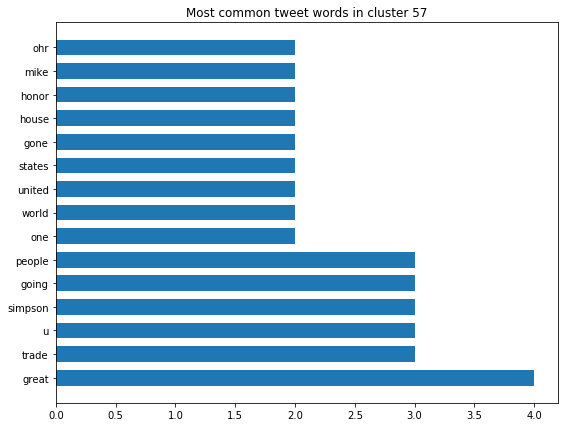

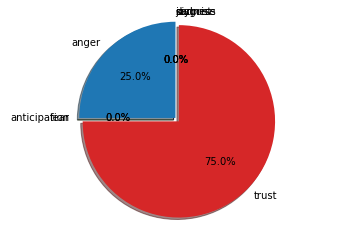

509 - Indiana Rally, and Coach Bobby Knight, were incredible last night. Packed House in Honor of Mike Braun for Senate. Mike will be a GREAT Senator. Don’t forget to VOTE!
2899 - Today, it was my honor to join the great men and women of @DHSgov, @CustomsBorder, @ICEgov and @USCIS at the U.S. Customs and Border Protection National Targeting Center in Sterling, Virginia. Fact sheet: https://t.co/Q027Wgdzdo https://t.co/NecuA0y1Sk
1923 - I can’t think of something more concerning than a law enforcement officer suggesting that their going to use their powers to affect an election!” Inspector General Horowitz on what was going on with numerous people regarding my election. A Rigged Witch Hunt!p
269 - Just signed one of the most important, and largest, Trade Deals in U.S. and World History. The United States, Mexico and Canada worked so well together in crafting this great document. The terrible NAFTA will soon be gone. The USMCA will be fantastic for all!
729 - “Conflict between Glen Simps

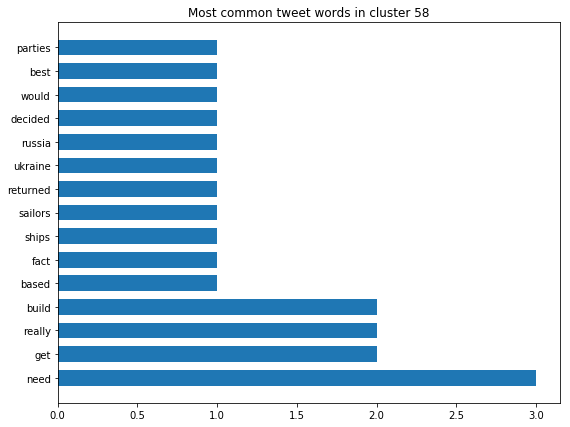

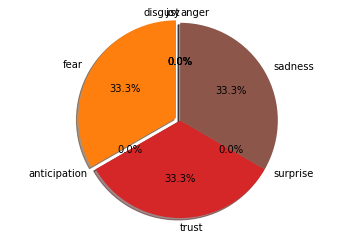

565 - Congressman @DenverRiggleman of the 5th District in Virginia is a popular guy who really knows how to get the job done! Really big help with Tax Cuts, the Military and our great Vets. He has my Total Endorsement!
495 - Heading to Pensacola, Florida - will be there soon. Amazing lines of people wanting to get in - what a crowd! Is this a sign of Republican Strength on Tuesday? https://t.co/te7RHdAeKA
285 - Based on the fact that the ships and sailors have not been returned to Ukraine from Russia, I have decided it would be best for all parties concerned to cancel my previously scheduled meeting....
2655 - Five of our incredible @Cabinet Secretaries are testifying on the Hill this morning on the need to rebuild our Nation’s crumbling infrastructure. We need to build FAST &amp; we need to build for our FUTURE. Thank you @SenateCommerce for hosting this hearing! #InfrastructureInAmerica
2709 - Lowest rated Oscars in HISTORY. Problem is, we don’t have Stars anymore - except your Presi

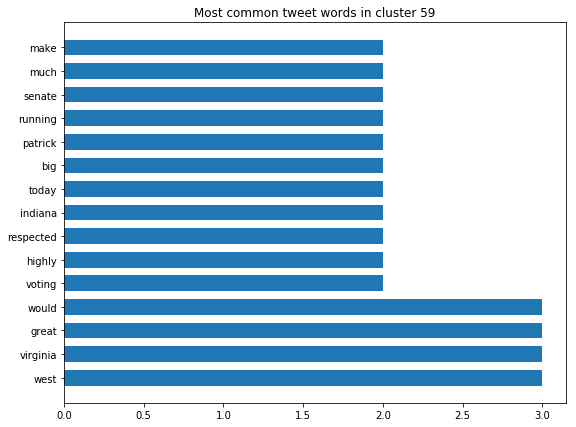

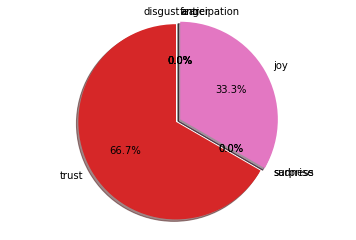

521 - Will be going to West Virginia and Indiana today, TWO RALLIES! Don’t tell anyone (big secret), but I will be bringing Coach Bobby Knight to Indiana. He’s been a supporter right from the beginning of the Greatest Political Movement in American History!
1278 - Big Rally tonight in West Virginia. Patrick Morrisey is running a GREAT race for U.S. Senate. I have done so much for West Virginia, against all odds, and having Patrick, a real fighter, by my side, would make things so much easier. See you later. CLEAN COAL!!!!
2587 - I am pleased to announce that I intend to nominate highly respected Admiral Ronny L. Jackson, MD, as the new Secretary of Veterans Affairs....
905 - US-Korea Free Trade Agreement Signing Ceremony! https://t.co/yLFkAZgagG
2811 - .@MittRomney has announced he is running for the Senate from the wonderful State of Utah. He will make a great Senator and worthy successor to @OrrinHatch, and has my full support and endorsement!
----------------------------------------

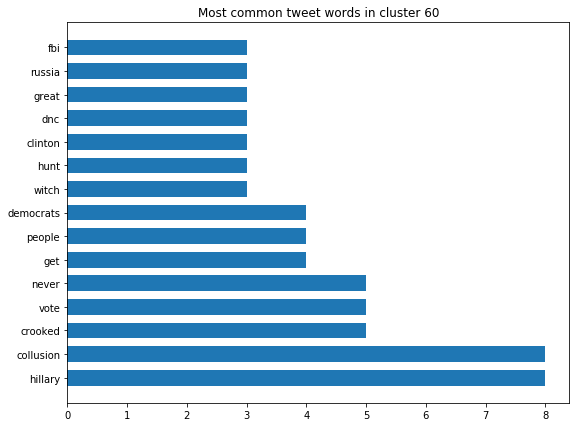

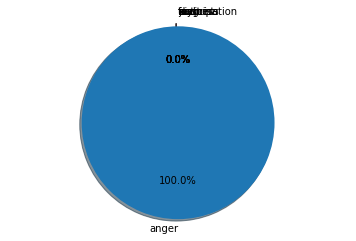

1952 - I’ve had to beat 17 very talented people including the Bush Dynasty, then I had to beat the Clinton Dynasty, and now I have to beat a phony Witch Hunt and all of the dishonest people covered in the IG Report...and never forget the Fake News Media. It never ends!
528 - ....His opponent, Jared Polis, is weak on crime and weak on borders – could never do the job. Get out and VOTE – Walker has my Complete and Total Endorsement!
1514 - Collusion is not a crime, but that doesn’t matter because there was No Collusion (except by Crooked Hillary and the Democrats)!
2118 - Iger, where is my call of apology? You and ABC have offended millions of people, and they demand a response. How is Brian Ross doing? He tanked the market with an ABC lie, yet no apology. Double Standard!
346 - Great new book out, “Mad Politics: Keeping Your Sanity in a World Gone Crazy” by @RealDrGina Loudon. Go out and get your copy today — a great read!
----------------------------------------
We have 254 words, of w

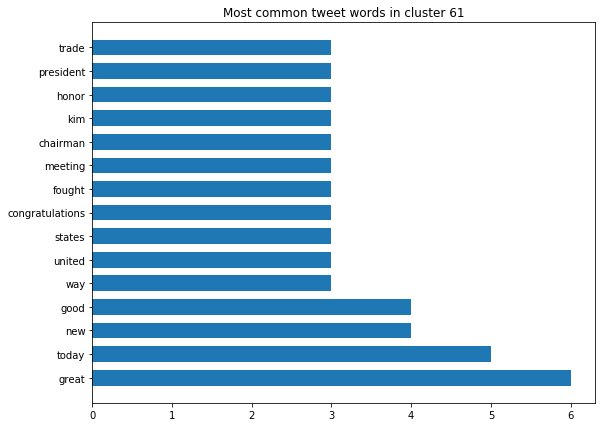

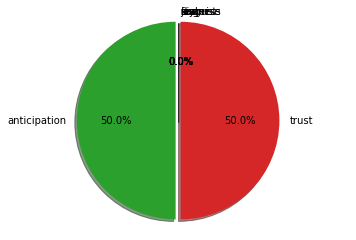

2536 - Congratulations to @bernieandsid on their new @77wabcradio morning radio show in New York City. It was an honor to join you two – good luck! https://t.co/sulTcRp3IC
2172 - Today, it was my great honor to deliver the 2018 Commencement Address at the United States @NavalAcademy in Annapolis, Maryland. Congratulations!

Good luck. Godspeed. And ANCHORS AWEIGH! https://t.co/aoLBK7y16a
2138 - We have put a great team together for our talks with North Korea. Meetings are currently taking place concerning Summit, and more. Kim Young Chol, the Vice Chairman of North Korea, heading now to New York. Solid response to my letter, thank you!
2316 - Our high level delegation is on the way back from China where they had long meetings with Chinese leaders and business representatives. We will be meeting tomorrow to determine the results, but it is hard for China in that they have become very spoiled with U.S. trade wins!
1163 - I am very excited about the person who will be taking the place of 

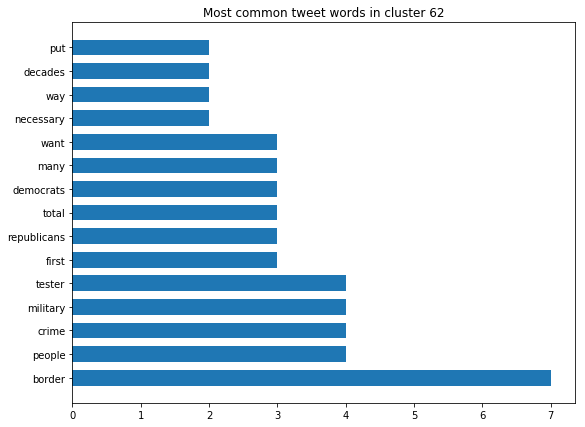

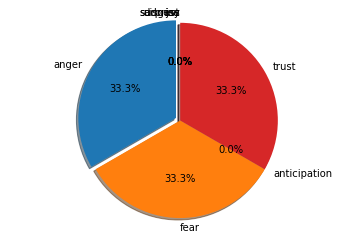

2826 - Just like they don’t want to solve the DACA problem, why didn’t the Democrats pass gun control legislation when they had both the House &amp; Senate during the Obama Administration. Because they didn’t want to, and now they just talk!
1622 - Watching Los Angeles possible hostage situation very closely. Active barricaded suspect. L.A.P.D. working with Federal Law Enforcement.
1251 - I have authorized an emergency disaster declaration to provide Hawaii the necessary support ahead of #HurricaneLane. Our teams are closely coordinating with the state and local authorities. You are in our thoughts! https://t.co/lrhwbdUavj
1508 - I don’t care what the political ramifications are, our immigration laws and border security have been a complete and total disaster for decades, and there is no way that the Democrats will allow it to be fixed without a Government Shutdown...
1658 - So many people at the higher ends of intelligence loved my press conference performance in Helsinki. Putin and I

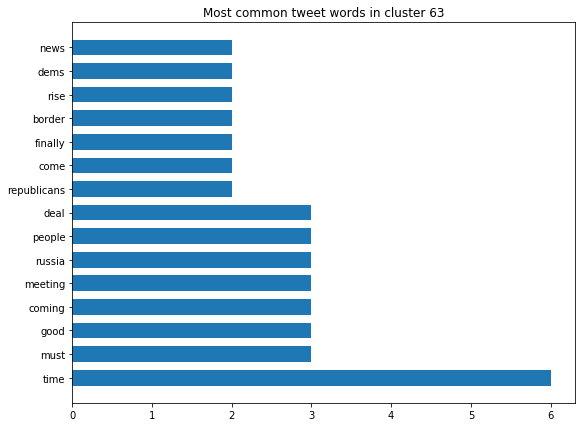

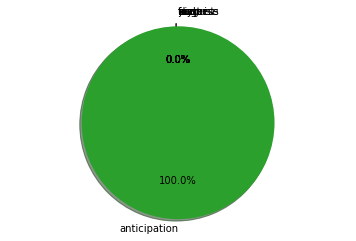

1700 - ....On top of it all, Germany just started paying Russia, the country they want protection from, Billions of Dollars for their Energy needs coming out of a new pipeline from Russia. Not acceptable! All NATO Nations must meet their 2% commitment, and that must ultimately go to 4%!
330 - Republicans and Democrats MUST come together, finally, with a major Border Security package, which will include funding for the Wall. After 40 years of talk, it is finally time for action. Fix the Border, for once and for all, NOW!
2766 - Dems are no longer talking DACA! “Out of sight, out of mind,” they say. DACA beneficiaries should not be happy. Nancy Pelosi truly doesn’t care about them. Republicans stand ready to make a deal!
1657 - While the NATO meeting in Brussels was an acknowledged triumph, with billions of dollars more being put up by member countries at a faster pace, the meeting with Russia may prove to be, in the long run, an even greater success. Many positive things will come out o

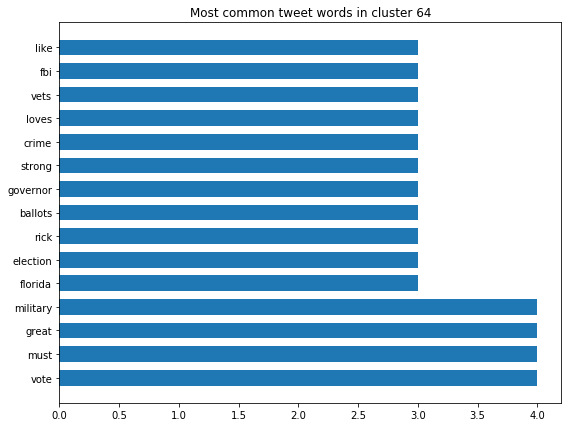

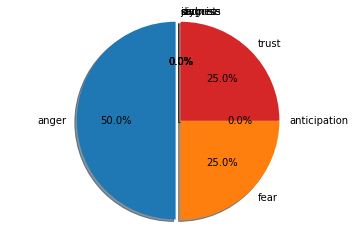

1095 - Does the so-called “Senior Administration Official” really exist, or is it just the Failing New York Times with another phony source? If the GUTLESS anonymous person does indeed exist, the Times must, for National Security purposes, turn him/her over to government at once!
2768 - Democrat judges have totally redrawn election lines in the great State of Pennsylvania. @FoxNews. This is very unfair to Republicans and to our country as a whole. Must be appealed to the United States Supreme Court ASAP!
1017 - More text messages between former FBI employees Peter Strzok and Lisa Page are a disaster and embarrassment to the FBI &amp; DOJ. This should never have happened but we are learning more and more by the hour. “Others were leaking like mad” in order to get the President! ........
2627 - Department of Justice should have urged the Supreme Court to at least hear the Drivers License case on illegal immigrants in Arizona. I agree with @LouDobbs. Should have sought review.
744 - Will 

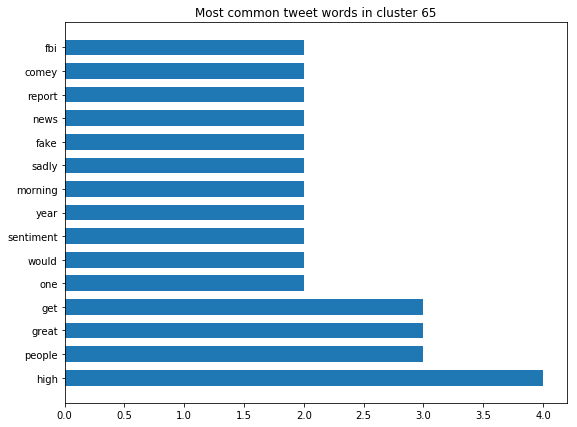

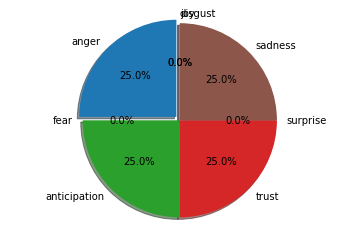

2049 - Many more Republican voters showed up yesterday than the Fake News thought possible. The political pundits just don’t get what is going on out there - or they do get it but refuse to report the facts! Remember, Dems are High Tax, High Crime, easy to beat!
1487 - Wow, @foxandfriends is blowing away the competition in the morning ratings. Morning Joe is a dead show with very few people watching and sadly, Fake News CNN is also doing poorly. Too much hate and inaccurately reported stories - too predictable!
1960 - The IG Report is a total disaster for Comey, his minions and sadly, the FBI. Comey will now officially go down as the worst leader, by far, in the history of the FBI. I did a great service to the people in firing him. Good Instincts. Christopher Wray will bring it proudly back!
2974 - I promised that my policies would allow companies like Apple to bring massive amounts of money back to the United States. Great to see Apple follow through as a result of TAX CUTS. Huge win 

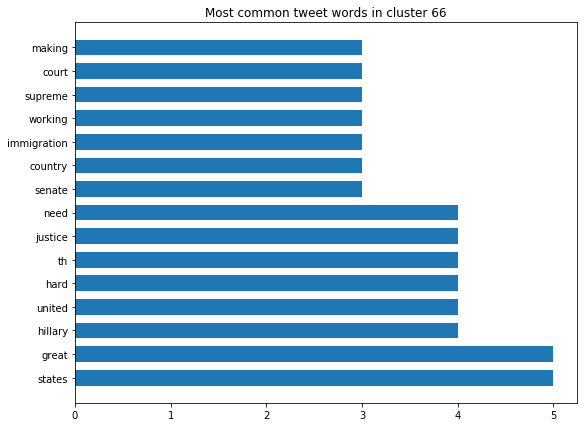

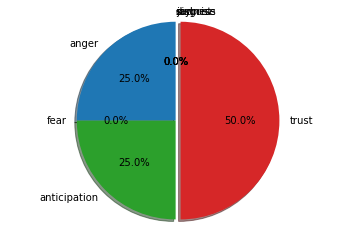

1771 - The economy is doing perhaps better than ever before, and that’s prior to fixing some of the worst and most unfair Trade Deals ever made by any country. In any event, they are coming along very well. Most countries agree that they must be changed, but nobody ever asked!
382 - Universities will someday study what highly conflicted (and NOT Senate approved) Bob Mueller and his gang of Democrat thugs have done to destroy people. Why is he protecting Crooked Hillary, Comey, McCabe, Lisa Page &amp; her lover, Peter S, and all of his friends on the other side?
670 - Ron @RonDeSantisFL DeSantis is working hard. A great Congressman and top student at Harvard &amp; Yale, Ron will be a record setting governor for Florida. Rick Scott gave him tremendous foundations to further build on. His opponent runs one of the worst &amp; most corrupt cities in USA!
982 - Watch @MariaBartiromo at 6:00 P.M. on @FoxBusiness. Russian Hoax the big topic! Mainstream Media, often referred to as the Fake News

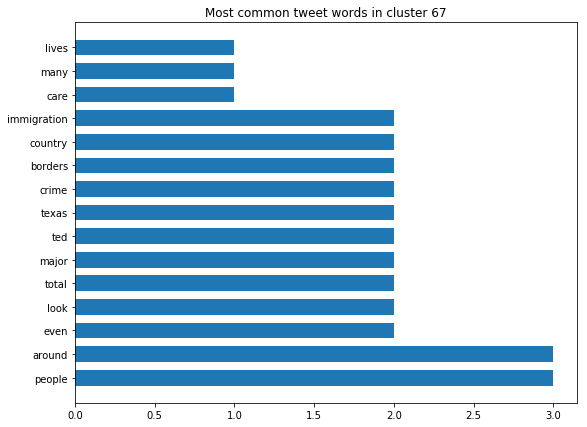

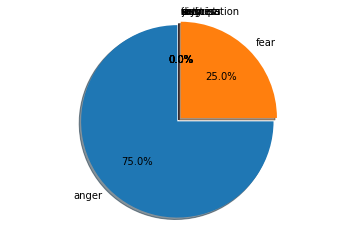

1157 - I will be doing a major rally for Senator Ted Cruz in October. I’m picking the biggest stadium in Texas we can find. As you know, Ted has my complete and total Endorsement. His opponent is a disaster for Texas - weak on Second Amendment, Crime, Borders, Military, and Vets!
1911 - The Fake News is not mentioning the safety and security of our Country when talking about illegal immigration. Our immigration laws are the weakest and worst anywhere in the world, and the Dems will do anything not to change them &amp; to obstruct-want open borders which means crime!
383 - ....care how many lives the ruin. These are Angry People, including the highly conflicted Bob Mueller, who worked for Obama for 8 years. They won’t even look at all of the bad acts and crimes on the other side. A TOTAL WITCH HUNT LIKE NO OTHER IN AMERICAN HISTORY!
1773 - Crazy Maxine Waters, said by some to be one of the most corrupt people in politics, is rapidly becoming, together with Nancy Pelosi, the FACE of the 

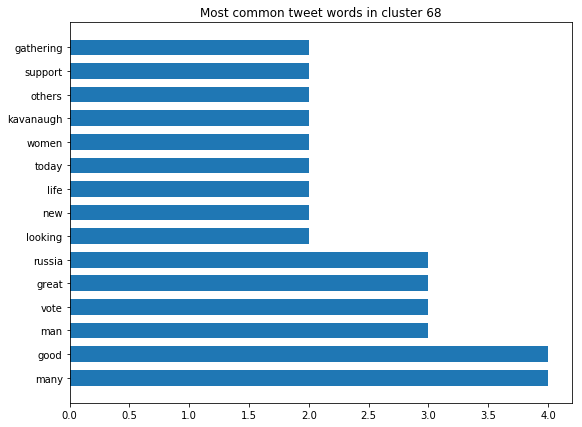

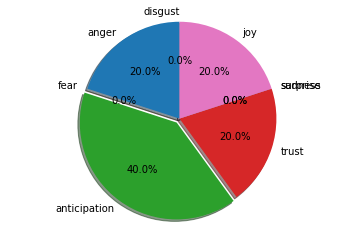

819 - Women for Kavanaugh, and many others who support this very good man, are gathering all over Capitol Hill in preparation for a 3-5 P.M. VOTE. It is a beautiful thing to see - and they are not paid professional protesters who are handed expensive signs. Big day for America!
386 - Our pledge to hire American includes those leaving prison and looking for a very fresh start — new job, and new life. The legislation I am supporting today contains many significant reforms. Read more here: https://t.co/BwQ3qd9Fyk https://t.co/6DUY9KNTpR
2126 - With the #RightToTry Law I signed today, patients with life threatening illnesses will finally have access to experimental treatments that could improve or even cure their conditions. These are experimental treatments and products that have shown great promise... https://t.co/FIUwhpUpoL
1857 - Happy Birthday to Supreme Court Justice Clarence Thomas, a friend and great man! https://t.co/hlXYYkTjcv
2896 - Great jobs numbers and finally, after many yea

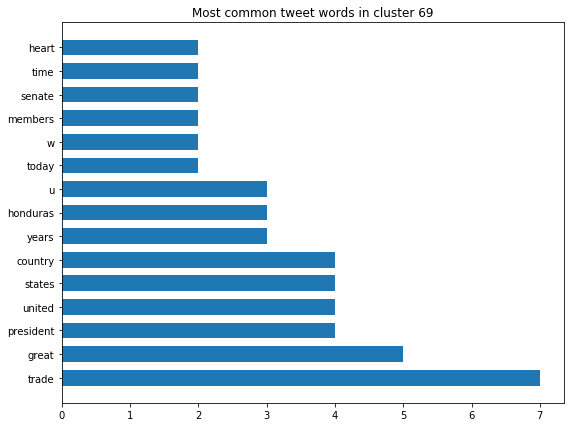

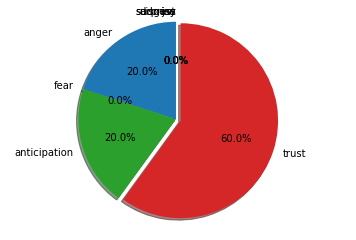

1995 - Our Great Larry Kudlow, who has been working so hard on trade and the economy, has just suffered a heart attack. He is now in Walter Reed Medical Center.
1600 - Tariffs are the greatest! Either a country which has treated the United States unfairly on Trade negotiates a fair deal, or it gets hit with Tariffs. It’s as simple as that - and everybody’s talking! Remember, we are the “piggy bank” that’s being robbed. All will be Great!
2731 - When a country (USA) is losing many billions of dollars on trade with virtually every country it does business with, trade wars are good, and easy to win. Example, when we are down $100 billion with a certain country and they get cute, don’t trade anymore-we win big. It’s easy!
476 - REMEMBER FLORIDA: I have been President of the United States for almost two years. During that time Senator Bill Nelson didn’t call me once. Rick Scott called constantly requesting dollars plus for Florida. Did a GREAT job on hurricanes. VOTE SCOTT!
1739 - Twitter i

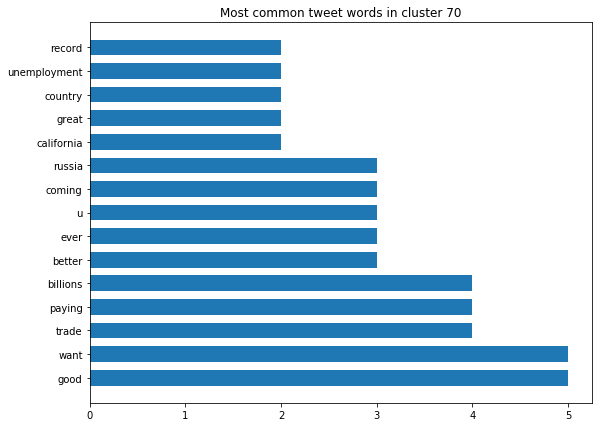

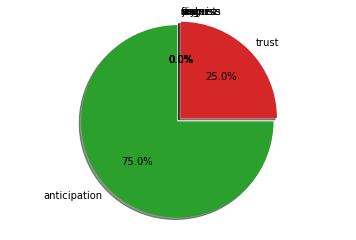

1652 - 3.4 million jobs created since our great Election Victory - far greater than ever anticipated, and only getting better as new and greatly improved Trade Deals start coming to fruition!
1130 - Happy Labor Day! Our country is doing better than ever before with unemployment setting record lows. The U.S. has tremendous upside potential as we go about fixing some of the worst Trade Deals ever made by any country in the world. Big progress being made!
937 - ...North Korea to be identified as a result of my Summit with Chairman Kim. These HEROES are home, they may Rest In Peace, and hopefully their families can have closure.
1707 - What good is NATO if Germany is paying Russia billions of dollars for gas and energy? Why are there only 5 out of 29 countries that have met their commitment? The U.S. is paying for Europe’s protection, then loses billions on Trade. Must pay 2% of GDP IMMEDIATELY, not by 2025.
1708 - What good is NATO if Germany is paying Russia billions of dollars for gas a

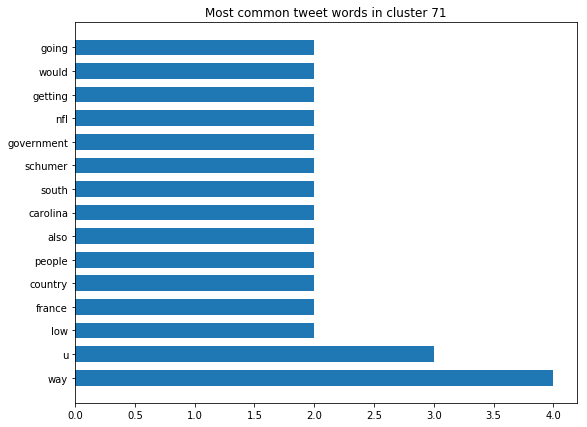

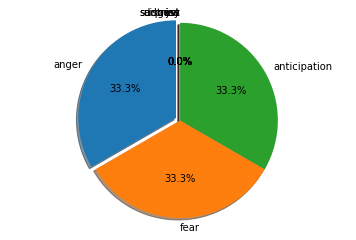

1047 - Chuck Schumer is holding up 320 appointments (Ambassadors, Executives, etc.) of great people who have left jobs and given up so much in order to come into Government. Schumer and the Democrats continue to OBSTRUCT!
1716 - Many countries in NATO, which we are expected to defend, are not only short of their current commitment of 2% (which is low), but are also delinquent for many years in payments that have not been made. Will they reimburse the U.S.?
1102 - Just like the NFL, whose ratings have gone WAY DOWN, Nike is getting absolutely killed with anger and boycotts. I wonder if they had any idea that it would be this way? As far as the NFL is concerned, I just find it hard to watch, and always will, until they stand for the FLAG!
2191 - Today on Long Island, we were all moved to be joined by families who have suffered unthinkable heartbreak at the hands of MS-13. I was truly honored to be joined again by the courageous families who were my guests at the State of the Union... htt

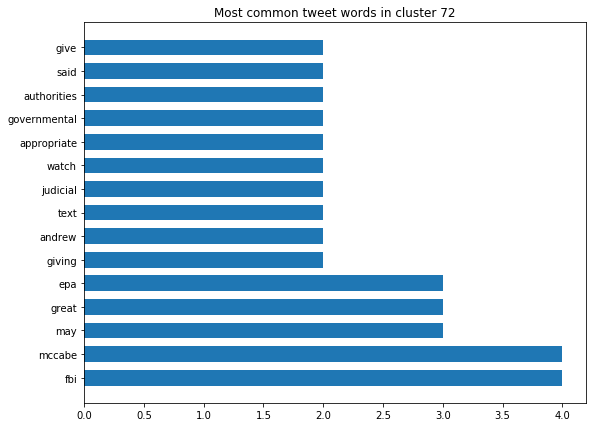

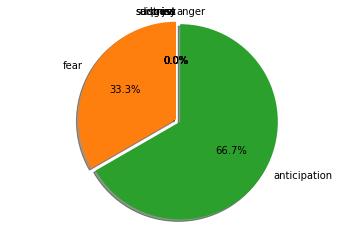

1746 - ...on Monday assume duties as the acting Administrator of the EPA. I have no doubt that Andy will continue on with our great and lasting EPA agenda. We have made tremendous progress and the future of the EPA is very bright!
1024 - Hurricane Florence may now be dipping a bit south and hitting a portion of the Great State of Georgia. Be ready, be prepared!
1408 - Why isn’t the FBI giving Andrew McCabe text messages  to Judicial Watch or appropriate governmental authorities. FBI said they won’t give up even one (I may have to get involved, DO NOT DESTROY). What are they hiding? McCabe wife took big campaign dollars from Hillary people.....
1410 - Why isn’t the FBI giving Andrew McCabe text massages to Judicial Watch or appropriate governmental authorities. FBI said they won’t give up even one (I may have to get involved, DO NOT DESTROY). What are they hiding? McCabe wife took big campaign dollars from Hillary people......
2848 - Our infrastructure plan has been put forward and has 

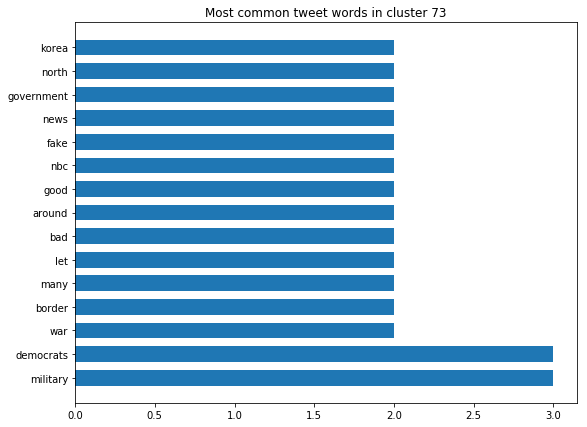

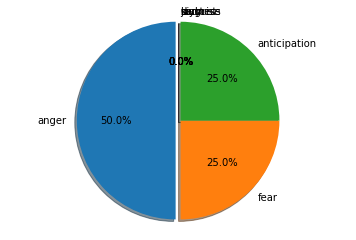

961 - ...that FEMA, our Military, and our First Responders, who are all unbelievable, are a disaster and not doing a good job. This will be a total lie, but that’s what they do, and everybody knows it!
1768 - Many good conversations with North Korea-it is going well! In the meantime, no Rocket Launches or Nuclear Testing in 8 months. All of Asia is thrilled. Only the Opposition Party, which includes the Fake News, is complaining. If not for me, we would now be at War with North Korea!
413 - Exactly 100 years ago today, on November 11th, 1918, World War I came to an end. We are gathered together, at this hallowed resting place, to pay tribute to the brave Americans who gave their last breath in that mighty struggle.... https://t.co/JPUkOr4rW1
548 - Our military is being mobilized at the Southern Border. Many more troops coming. We will NOT let these Caravans, which are also made up of some very bad thugs and gang members, into the U.S. Our Border is sacred, must come in legally. TURN AR

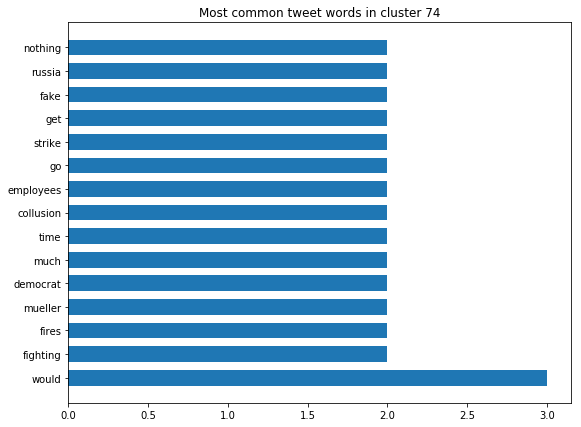

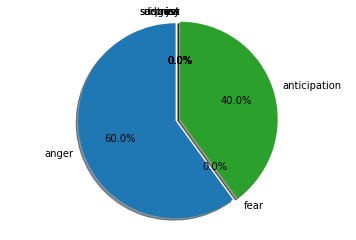

2506 - Much of the bad blood with Russia is caused by the Fake &amp; Corrupt Russia Investigation, headed up by the all Democrat loyalists, or people that worked for Obama. Mueller is most conflicted of all (except Rosenstein who signed FISA &amp; Comey letter). No Collusion, so they go crazy!
2906 - March 5th is rapidly approaching and the Democrats are doing nothing about DACA. They Resist, Blame, Complain and Obstruct - and do nothing. Start pushing Nancy Pelosi and the Dems to work out a DACA fix, NOW!
1937 - Washington Post employees want to go on strike because Bezos isn’t paying them enough. I think a really long strike would be a great idea. Employees would get more money and we would get rid of Fake News for an extended period of time! Is @WaPo a registered lobbyist?
1295 - Disgraced and discredited Bob Mueller and his whole group of Angry Democrat Thugs spent over 30 hours with the White House Councel, only with my approval, for purposes of transparency. Anybody needing that 

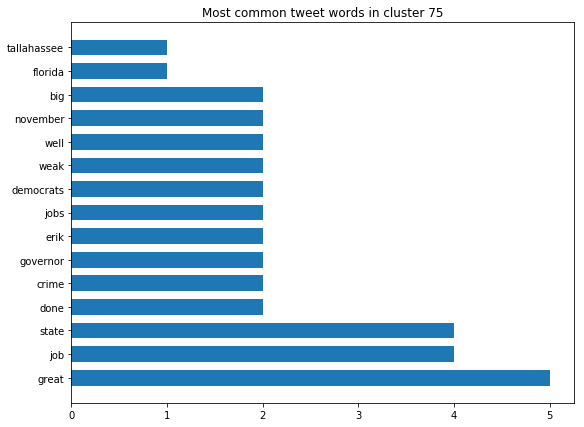

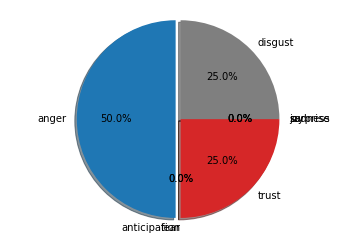

2295 - Congratulations to Mike Dewine on his big win in the Great State of Ohio. He will be a great Governor with a heavy focus on HealthCare and Jobs.  His Socialist opponent in November should not do well, a big failure in last job!
1769 - How can the Democrats, who are weak on the Border and weak on Crime, do well in November. The people of our Country want and demand Safety and Security, while the Democrats are more interested in  ripping apart and demeaning (and not properly funding) our great Law Enforcement!
639 - Congressman Erik Paulsen of the Great State of Minnesota has done a fantastic job in cutting Taxes and Job Killing Regulations. Hard working and very smart. Keep Erik in Congress. He has my Strong Endorsement!
1092 - The Deep State and the Left, and their vehicle, the Fake News Media, are going Crazy - &amp; they don’t know what to do. The Economy is booming like never before, Jobs are at Historic Highs, soon TWO Supreme Court Justices &amp; maybe Declassification to f

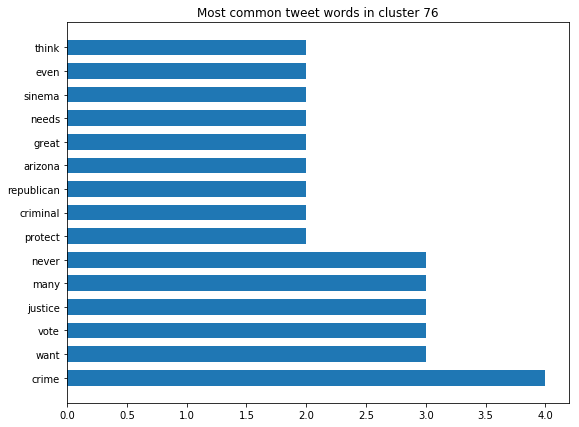

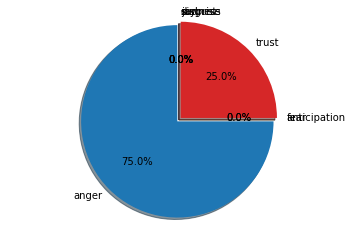

1183 - How the hell is Bruce Ohr still employed at the Justice Department? Disgraceful!  Witch Hunt!
2129 - The Failing and Corrupt @nytimes estimated the crowd last night at “1000 people,” when in fact it was many times that number - and the arena was rockin’. This is the way they demean and disparage. They are very dishonest people who don’t “get” me, and never did!
1532 - ....Also, why is Mueller only appointing Angry Dems, some of whom have worked for Crooked Hillary, others, including himself, have worked for Obama....And why isn’t Mueller looking at all of the criminal activity &amp; real Russian Collusion on the Democrats side-Podesta, Dossier?
1268 - Michael Cohen plead guilty to two counts of campaign finance violations that are not a crime. President Obama had a big campaign finance violation and it was easily settled!
2025 - Prime Minister Trudeau is being so indignant, bringing up the relationship that the U.S. and Canada had over the many years and all sorts of other thing

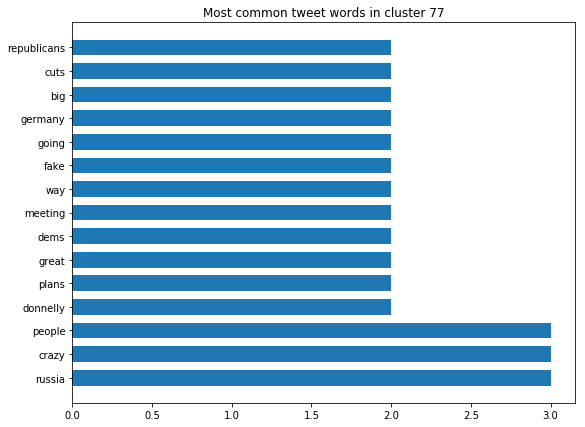

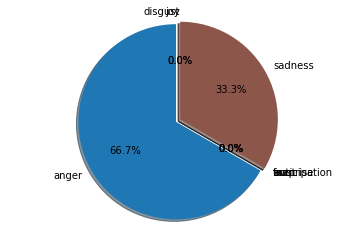

2511 - The Failing New York Times wrote another phony story. It was political pundit Doug Schoen, not a Ukrainian businessman, who asked me to do a short speech by phone (Skype), hosted by Doug, in Ukraine. I was very positive about Ukraine-another negative to the Fake Russia  C story!
740 - Open enrollment starts today on lower-priced Medicare Advantage plans so loved by our great seniors. Crazy Bernie and his band of Congressional Dems will outlaw these plans. Disaster!
1664 - While I had a great meeting with NATO, raising vast amounts of money, I had an even better meeting with Vladimir Putin of Russia. Sadly, it is not being reported that way - the Fake News is going Crazy!
2434 - Nancy Pelosi is going absolutely crazy about the big Tax Cuts given to the American People by the Republicans...got not one Democrat Vote! Here’s a choice. They want to end them and raise your taxes substantially. Republicans are working on making them permanent and more cuts!
2885 - So disgraceful that a

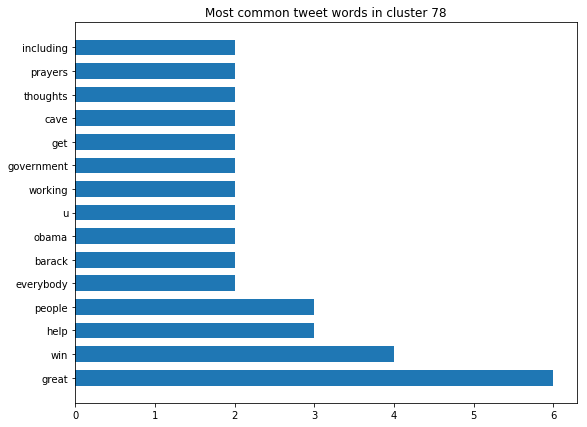

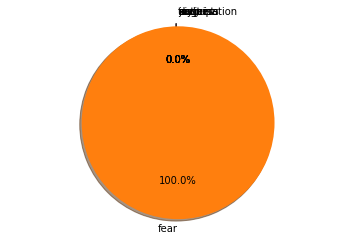

1956 - “Why in the world didn’t Barack Obama fire this guy (Comey)?” asks Mark Levin!
1838 - Congresswoman Maxine Waters, an extraordinarily low IQ person, has become, together with Nancy Pelosi, the Face of the Democrat Party. She has just called for harm to supporters, of which there are many, of the Make America Great Again movement. Be careful what you wish for Max!
1860 - My thoughts and prayers are with Representative Katie Arrington of South Carolina, including all of those involved in last nights car accident, and their families. https://t.co/rWYt2VBjxc
2938 - Big win for Republicans as Democrats cave on Shutdown. Now I want a big win for everyone, including Republicans, Democrats and DACA, but especially for our Great Military and Border Security. Should be able to get there. See you at the negotiating table!
960 - Thank you to our great Coast Guard for doing such a tremendous job - thousands of lives being saved! https://t.co/Ud8AT1orf8 https://t.co/YEFnGMmwoV
---------------

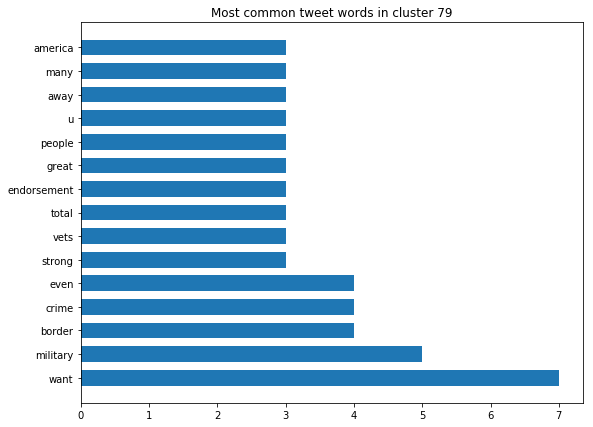

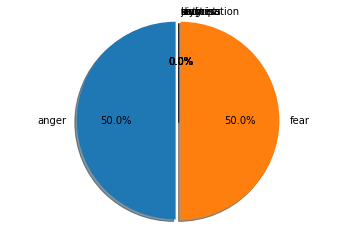

552 - ....Richard Cordray will let you down, just like he did when he destroyed the government agency that he ran. Clone of Pocahontas, that’s not for Ohio. Mike has my Total Endorsement!
662 - The Caravans are a disgrace to the Democrat Party. Change the immigration laws NOW!
1883 - You cannot pass legislation on immigration whether it be for safety and security or any other reason including “heart,” without getting Dem votes. Problem is, they don’t care about security and R’s do. Zero Dems voted to support the Goodlatte Bill. They won’t vote for anything!
2477 - Attorney Client privilege is now a thing of the past. I have many (too many!) lawyers and they are probably wondering when their offices, and even homes, are going to be raided with everything, including their phones and computers, taken. All lawyers are deflated and concerned!
511 - Scott Perry of Pennsylvania is fantastic. He is strong on the Border, Crime, the Military, our Vets and the Second Amendment. Scott has my Total

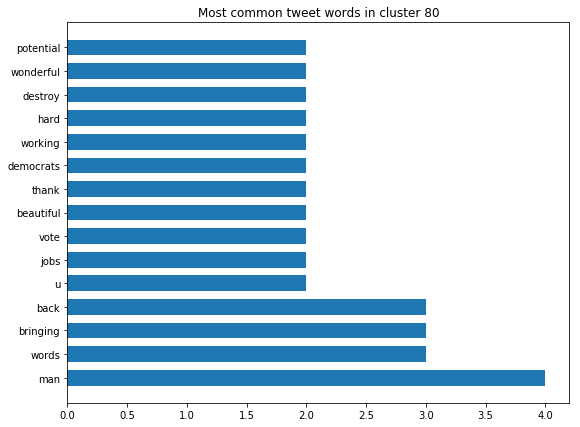

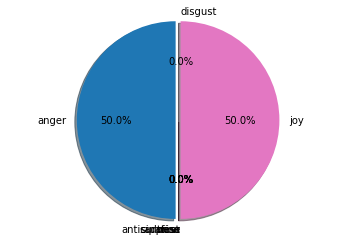

1924 - Comey gave Strozk his marching orders. Mueller is Comey’s best friend. Witch Hunt!
1339 - Thank you for the kind words Omarosa! https://t.co/PMmNG6iIsi
2487 - We are bringing back our factories, we are bringing back our jobs, and we are bringing back those four beautiful words: MADE IN THE USA! https://t.co/grABSrYUBX
522 - Wow! The U.S. added 250,000 Jobs in October - and this was despite the hurricanes. Unemployment at 3.7%. Wages UP! These are incredible numbers. Keep it going, Vote Republican!
2575 - Mexico is doing very little, if not NOTHING, at stopping people from flowing into Mexico through their Southern Border, and then into the U.S. They laugh at our dumb immigration laws. They must stop the big drug and people flows, or I will stop their cash cow, NAFTA. NEED WALL!
----------------------------------------
We have 138 words, of which 108 are unique
8
[('anger', 1.0), ('trust', 1.0), ('surprise', 1.0), ('fear', 0.0), ('anticipation', 0.0), ('sadness', 0.0), ('joy', 0.

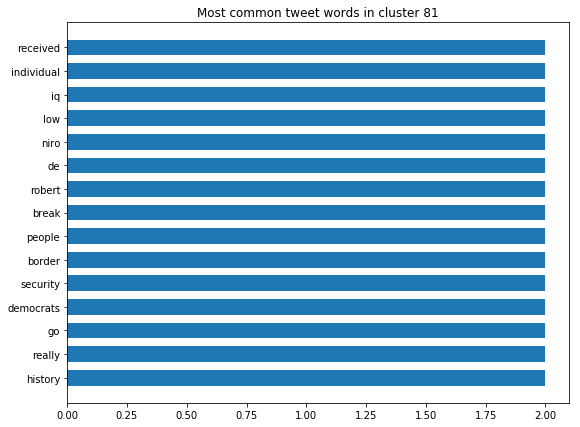

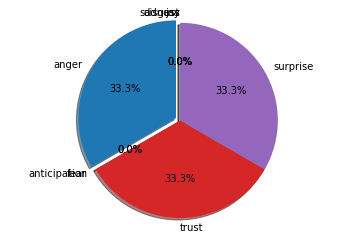

1853 - Democrats, fix the laws. Don’t RESIST. We are doing a far better job than Bush and Obama, but we need strength and security at the Border! Cannot accept all of the people trying to break into our Country. Strong Borders, No Crime!
2146 - “Sally Yates is part of concerns people have raised about bias in the Justice Dept. I find her actions to be really quite unbelievable.” Jonathan Turley
966 - ....campaign, which is unprecedented in our history.” Congressman Peter King  Really bad things were happening, but they are now being exposed. Big stuff!
1836 - “Director David Lynch: Trump Could Go Down as One of the Greatest Presidents” https://t.co/AcgnIZNh6e
532 - That’s because they treat me fairly!
“@FoxNews tops @CNN and @MSNBC combined in October cable news ratings” https://t.co/QX56Pwlmj4
----------------------------------------
We have 71 words, of which 65 are unique
5
[('anger', 1.0), ('surprise', 1.0), ('fear', 0.0), ('anticipation', 0.0), ('trust', 0.0), ('sadness', 0.0), ('

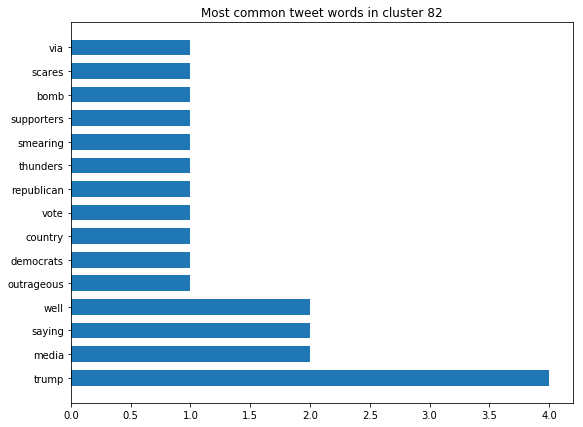

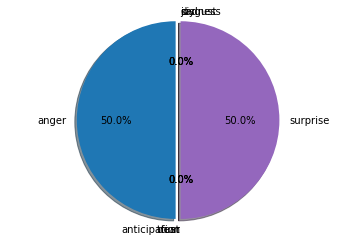

1643 - “Trump recognized Russian Meddling MANY TIMES.” Thank you to @foxandfriends and @FoxNews for actually showing the clips. The Fake News wants no part of that narrative! Too bad they don’t want to focus on all of the ECONOMIC and JOBS records being set.
2618 - Remember when they were saying, during the campaign, that Donald Trump is giving great speeches and drawing big crowds, but he is spending much less money and not using social media as well as Crooked Hillary’s large and highly sophisticated staff. Well, not saying that anymore!
594 - Trump Thunders at Media for Smearing His Supporters after Bomb Scares https://t.co/Ggdhs9reY3 via @BreitbartNews
535 - It is outrageous what the Democrats are doing to our Country. Vote Republican now! https://t.co/0pWiwCHGbh https://t.co/2crea9HF7G
1823 - SUPREME COURT UPHOLDS TRUMP TRAVEL BAN. Wow!
----------------------------------------
We have 112 words, of which 59 are unique
5
[('anger', 1.0), ('fear', 1.0), ('joy', 1.0), ('disgust', 1.0

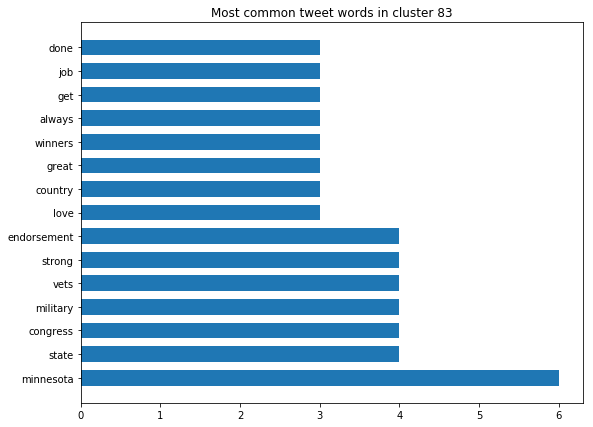

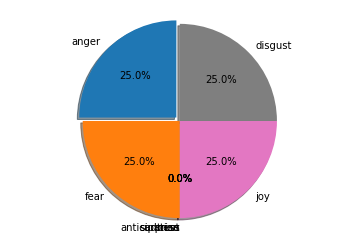

560 - .@Erik_Paulsen, @Jason2CD, 
@JimHagedornMN and @PeteStauber love our Country and the Great State of Minnesota. They are winners and always get the job done We need them all in Congress for #MAGA. Border, Military, Vets, 2nd A. Go Vote Minnesota. They have my Strong Endorsement!
564 - .@ErikPaulson, @JasonLewis, @JimHagedornMN and @PeteStauber love our Country and the Great State of Minnesota. They are winners and always get the job done We need them all in Congress for #MAGA. Border, Military, Vets, 2nd A. Go Vote Minnesota. They have my Strong Endorsement!
558 - .@Erik_Paulsen, @Jason2CD, 
@JimHagedornMN and @PeteStauber love our Country and the Great State of Minnesota. They are winners and always get the job done. We need them all in Congress for #MAGA. Border, Military, Vets, 2nd A. Go Vote Minnesota. They have my Strong Endorsement!
1046 - Was just briefed via phone by @DHSgov @SecNielsen and @FEMA @FEMA_Brock, along with @VP Mike Pence and Chief of Staff, John Kelly on inco

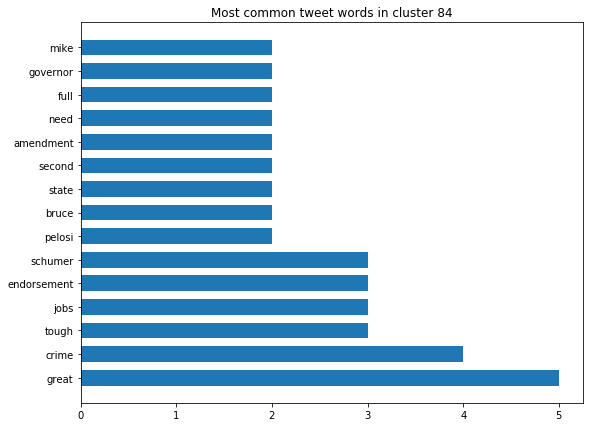

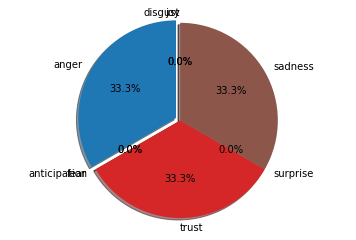

2023 - Obama, Schumer and Pelosi did NOTHING about North Korea, and now weak on Crime, High Tax Schumer is telling me what to do at the Summit the Dems could never set up. Schumer failed with North Korea and Iran, we don’t need his advice!
1346 - “I’d strip the whole bunch of them. They’re all corrupt. They’ve all abused their power. They’ve all betrayed the American people with a political agenda. They tried to steal and influence an election in the United States.” @seanhannity
610 - .@BrucePoliquin from Maine is a great Congressman. He is in a tough fight against a very liberal Nancy Pelosi Democrat. Bruce has helped bring JOBS back to his State and totally protects your Great Second Amendment. We need to keep Bruce in Washington. He has my Full Endorsement!
1895 - Henry McMaster has done a great job as Governor of South Carolina. The State is BOOMING, with jobs and new industry setting records. He is tough on Crime and strong on Borders, Health Care, the Mititary and our great Vets.

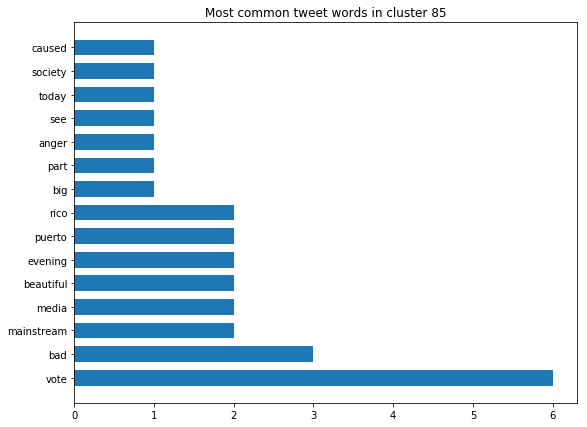

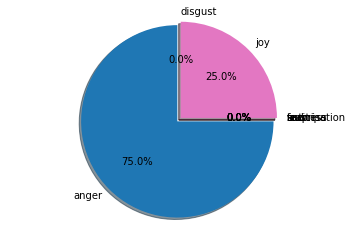

1678 - ...know how to do is resist and obstruct! This is why there is such hatred and dissension in our country – but at some point, it will heal!
824 - Beautiful evening in Rochester, Minnesota. VOTE, VOTE, VOTE! https://t.co/SyxrxvTpZE
621 - A very big part of the Anger we see today in our society is caused by the purposely false and inaccurate reporting of the Mainstream Media that I refer to as Fake News. It has gotten so bad and hateful that it is beyond description. Mainstream Media must clean up its act, FAST!
1013 - .....This was done by the Democrats in order to make me look as bad as possible when I was successfully raising Billions of Dollars to help rebuild Puerto Rico. If a person died for any reason, like old age, just add them onto the list. Bad politics. I love Puerto Rico!
814 - Beautiful evening in Topeka, Kansas. VOTE, VOTE, VOTE! #MAGA https://t.co/bomRqsaYfm
----------------------------------------
We have 110 words, of which 84 are unique
5
[('trust', 3.0), ('anti

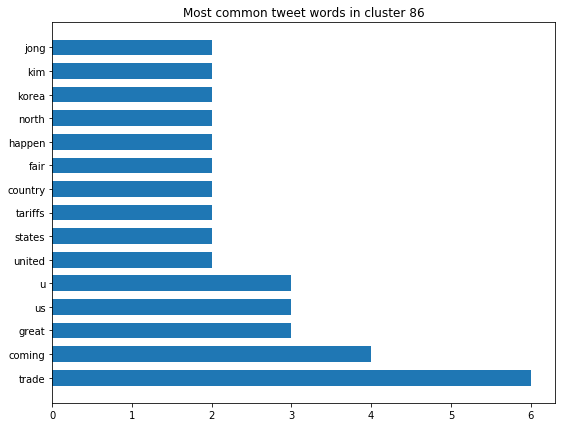

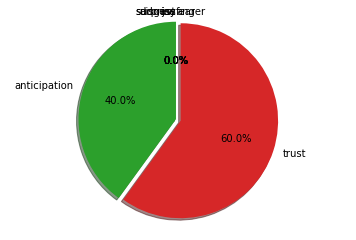

633 - Billions of dollars are, and will be, coming into United States coffers because of Tariffs. Great also for negotiations - if a country won’t give us a fair Trade Deal, we will institute Tariffs on them. Used or not, jobs and businesses will be created. U.S. respected again!
2991 - I, as President, want people coming into our Country who are going to help us become strong and great again, people coming in through a system based on MERIT. No more Lotteries! #AMERICA FIRST
2151 - Our United States team has arrived in North Korea to make arrangements for the Summit between Kim Jong Un and myself. I truly believe North Korea has brilliant potential and will be a great economic and financial Nation one day. Kim Jong Un agrees with me on this. It will happen!
2012 - ...U.S.A. Trade. They fully understand where I am coming from. After many decades, fair and reciprocal Trade will happen!
2109 - Canada has treated our Agricultural business and Farmers very poorly for a very long period of 

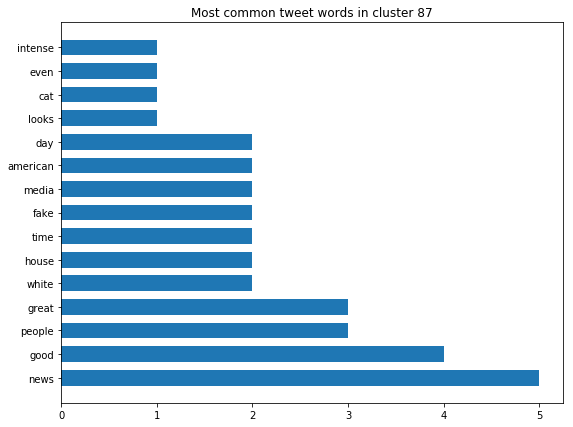

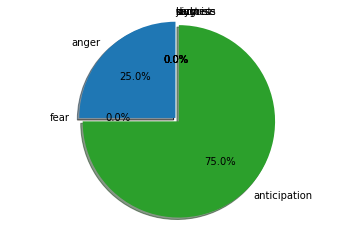

2164 - Good news about the release of the American hostage from Venezuela. Should be landing in D.C. this evening and be in the White House, with his family, at about 7:00 P.M. The great people of Utah will be very happy!
2996 - I don’t believe the Democrats really want to see a deal on DACA. They are all talk and no action. This is the time but, day by day, they are blowing the one great opportunity they have. Too bad!
797 - ...Looks to be a Cat. 3 which is even more intense than Florence. Good news is, the folks in the Pan Handle can take care of anything. @FEMA and First Responders are ready - be prepared! #HurricaneMichael
1541 - Had a very good and interesting meeting at the White House with A.G. Sulzberger, Publisher of the New York Times. Spent much time talking about the vast amounts of Fake News being put out by the media &amp; how that Fake News has morphed into phrase, “Enemy of the People.” Sad!
2970 - Despite some very corrupt and dishonest media coverage, there are many g

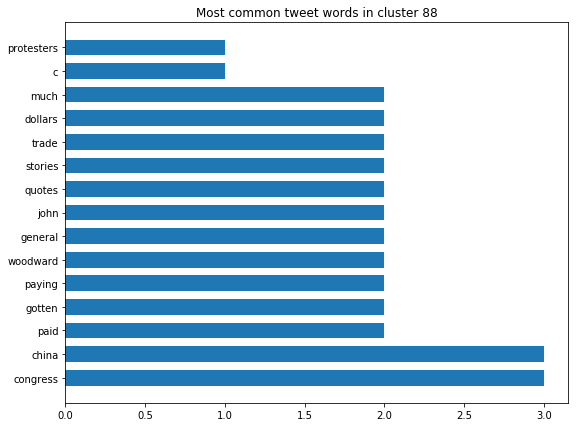

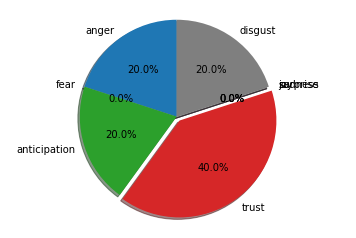

2257 - The Washington Post and CNN have typically written false stories about our trade negotiations with China. Nothing has happened with ZTE except as it pertains to the larger trade deal. Our country has been losing hundreds of billions of dollars a year with China...
2338 - “This isn’t some game. You are screwing with the work of the president of the United States.”  John Dowd, March 2018.  With North Korea, China, the Middle East and so much more, there is not much time to be thinking about this, especially since there was no Russian “Collusion.”
802 - The paid D.C. protesters are now ready to REALLY protest because they haven’t gotten their checks - in other words, they weren’t paid! Screamers in Congress, and outside, were far too obvious - less professional than anticipated by those paying (or not paying) the bills!
2823 - Never gotten over the fact that Obama was able to send $1.7 Billion Dollars in CASH to Iran and nobody in Congress, the FBI or Justice called for an investig

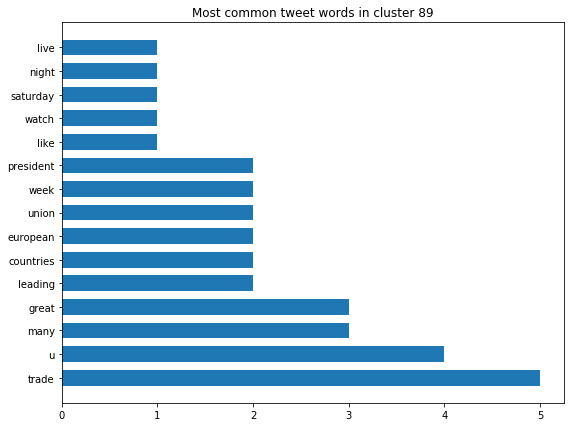

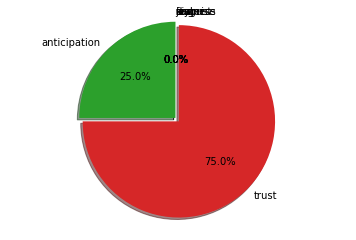

869 - Like many, I don’t watch Saturday Night Live (even though I past hosted it) - no longer funny, no talent or charm. It is just a political ad for the Dems. Word is that Kanye West, who put on a MAGA hat after the show (despite being told “no”), was great. He’s leading the charge!
1859 - Heading to Nevada to talk trade and immigration with supporters. Country’s economy is stronger than ever before with numbers that are getting better by the week. Tremendous potential, and trade deals are coming along well.
1495 - It was my great honor to be joined by leading pastors and faith leaders from across our Nation today at the @WhiteHouse! https://t.co/6sS1zGA1p7
1949 - Great discussions with European Union Commission President Jean-Claude Juncker and EU Council President Donald Tusk at the #G7Summit in Canada last week. https://t.co/kGxXe50459
1729 - ...Europe far more than it does the U.S. By some accounts, the U.S. is paying for 90% of NATO, with many countries nowhere close to their 2%

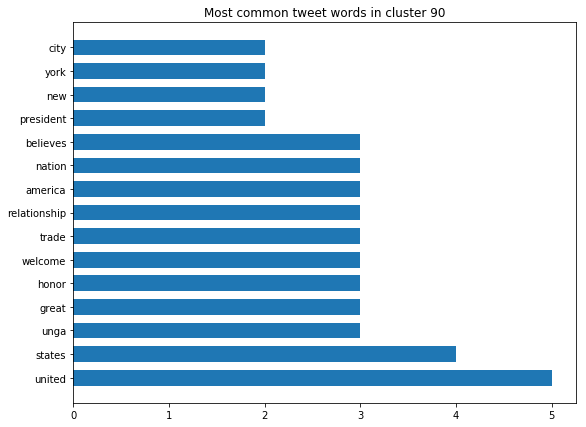

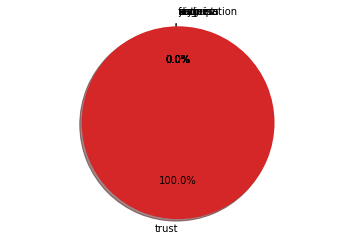

2233 - America is a Nation that believes in the power of redemption. America is a Nation that believes in second chances - and America is a Nation that believes that the best is always yet to come! #PrisonReform https://t.co/Yk5UJUYgHN
902 - It was my great honor to welcome President @AlsisiOfficial of Egypt to the United States this afternoon, in New York City. Great meetings! #UNGA https://t.co/dsMZWodpWr
901 - It was my great honor to welcome President @EmmanuelMacron of France to the United States, here in New York City, this evening! #UNGA https://t.co/Gd7pCBFUCg
2206 - It was my honor to welcome @NASCAR Cup Series Champion @MartinTruex_Jr and his team to the @WhiteHouse yesterday! https://t.co/5cr2oybrnQ
1212 - United States-Mexico Trade Agreement: https://t.co/E1AzveYPli https://t.co/ZYbHt1pD8a
----------------------------------------
We have 181 words, of which 144 are unique
8
[('anger', 3.0), ('anticipation', 1.0), ('trust', 1.0), ('fear', 0.0), ('surprise', 0.0), ('sadness',

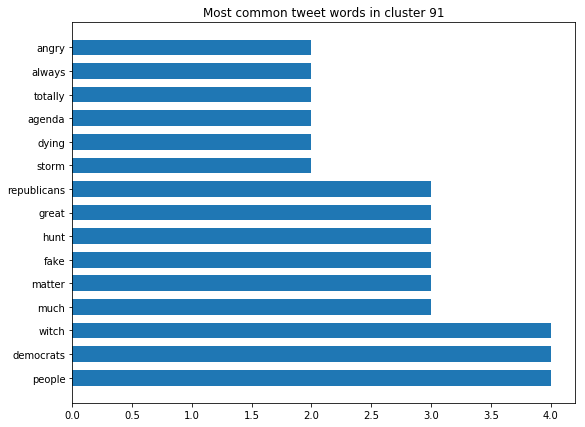

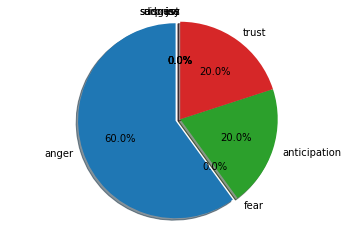

1450 - ...Why aren’t Mueller and the 17 Angry Democrats looking at the meetings concerning the Fake Dossier and all of the lying that went on in the FBI and DOJ? This is the most one sided Witch Hunt in the history of our country. Fortunately, the facts are all coming out, and fast!
1537 - ...dying newspaper industry. No matter how much they try to distract and cover it up, our country is making great progress under my leadership and I will never stop fighting for the American people! As an example, the failing New York Times...
2352 - The White House is running very smoothly despite phony Witch Hunts etc. There is great Energy and unending Stamina, both necessary to get things done. We are accomplishing the unthinkable and setting positive records while doing so! Fake News is going “bonkers!”
1626 - No Collusion, No Obstruction - but that doesn’t matter because the 13 Angry Democrats, who are only after Republicans and totally protecting Democrats, want this Witch Hunt to drag out to 

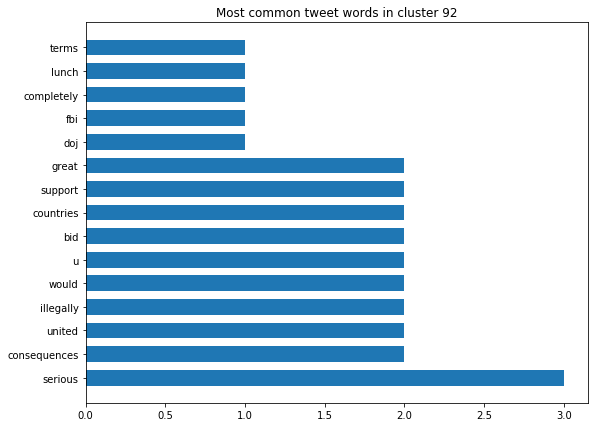

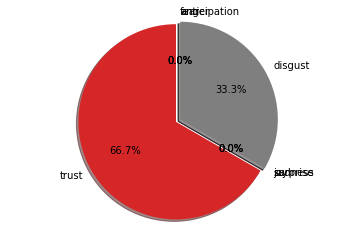

1279 - I am sorry to have to reiterate that there are serious and unpleasant consequences to crossing the Border into the United States ILLEGALLY! If there were no serious consequences, our country would be overrun with people trying to get in, and our system could not handle it!
2390 - Busy day planned.  Looking forward to watching President Macron of France address a Joint Session of Congress today. This is a great honor and seldom allowed to be done...he will be GREAT!
1146 - ....of the DOJ &amp; FBI are completely out to lunch in terms of exposing and holding those accountable who are responsible for that corruption.” @TomFitton @JudicialWatch
2383 - The U.S. has put together a STRONG bid w/ Canada &amp; Mexico for the 2026 World Cup. It would be a shame if countries that we always support were to lobby against the U.S. bid. Why should we be supporting these countries when they don’t support us (including at the United Nations)?
2382 - Is everybody believing what is going on. James

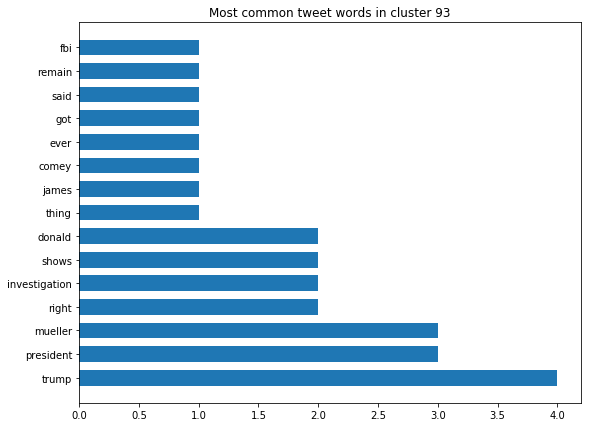

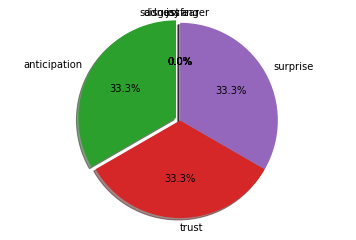

1502 - .....remain in the FBI while he himself was being investigated. This is a real issue. It won’t go into a Mueller Report because Mueller is going to protect these guys. Mueller has an interest in creating the illusion of objectivity around his investigation.” ALAN DERSHOWITZ....
2644 - “President Donald J. Trump Delivers Remarks at the Shamrock??Bowl Presentation by Prime Minister Varadkar in the East Room of the White House” ???????? https://t.co/ZbogpAE09g
2546 - “Still Rising: Rasmussen Poll Shows Donald Trump Approval Ratings Now at 51 Percent” https://t.co/q80PaE0gQo
2396 - “President Trump Calls the U.S.-France Relationship ‘Unbreakable.’ History Shows He’s Right.” https://t.co/L0gT4rvaJO
1167 - The only thing James Comey ever got right was when he said that President Trump was not under investigation!
----------------------------------------
We have 162 words, of which 126 are unique
8
[('anticipation', 1.0), ('trust', 1.0), ('sadness', 1.0), ('anger', 0.0), ('fear', 0.0),

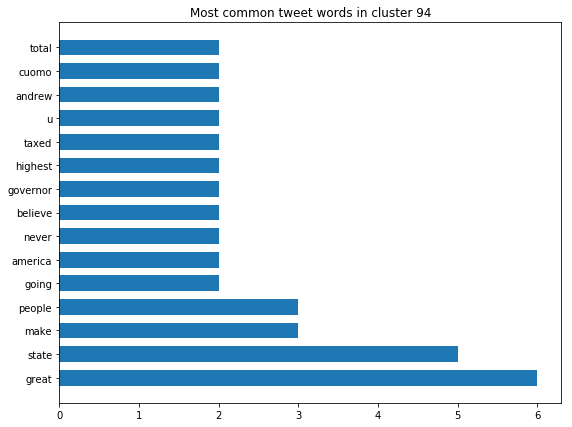

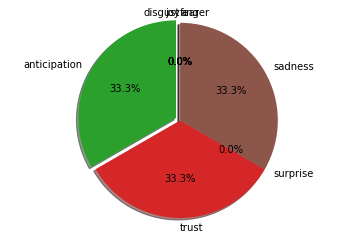

1820 - Tremendous win for Congressman Dan Donovan. You showed great courage in a tough race! New York, and my many friends on Staten Island, have elected someone they have always been very proud of. Congratulations!
2223 - ...in the Hillary Clinton Campaign where she deleted 33,000 Emails, got $145,000,000 while Secretary of State, paid McCabes wife $700,000 (and got off the FBI hook along with Terry M) and so much more. Republicans and real Americans should start getting tough on this Scam.
2924 - Today, Americans everywhere remember the brave men and women of @NASA who lost their lives in our Nation’s eternal quest to expand the boundaries of human potential. https://t.co/clBsJTGz8B https://t.co/jTJkusdBQA
1348 - “WE’RE NOT GOING TO MAKE AMERICA GREAT AGAIN, IT WAS NEVER THAT GREAT.” Can you believe this is the Governor of the Highest Taxed State in the U.S., Andrew Cuomo, having a total meltdown!
1349 - “WE’RE NOT GONG TO MAKE AMERICA GREAT AGAIN, IT WAS NEVER THAT GREAT.”  Can you 

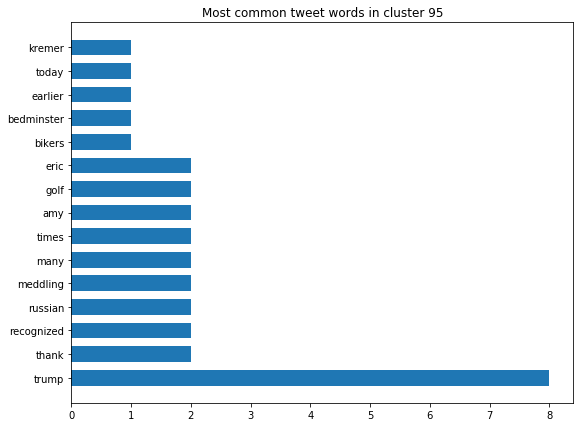

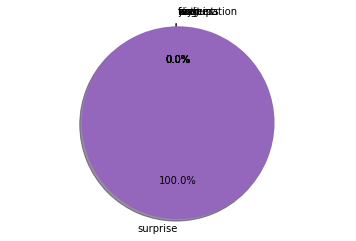

2452 - Prime Minister @AbeShinzo of Japan and myself this morning building an even deeper and better relationship while playing a quick round of golf at Trump International Golf Club. https://t.co/YqU7pHiFoU
2976 - Eric Trump on @foxandfriends  now!
1637 - “Trump recognized Russian Meddling MANY TIMES” https://t.co/T8MERS93wI
1800 - Amy Kremer, Women for Trump, was so great on @foxandfriends. Brave and very smart, thank you Amy! @AmyKremer
1401 - Bikers for Trump at Bedminster earlier today. Thank you! https://t.co/GWN56gYGT3
----------------------------------------
We have 115 words, of which 105 are unique
5
[('anticipation', 2.0), ('trust', 2.0), ('fear', 1.0), ('anger', 0.0), ('surprise', 0.0), ('sadness', 0.0), ('joy', 0.0), ('disgust', 0.0)]


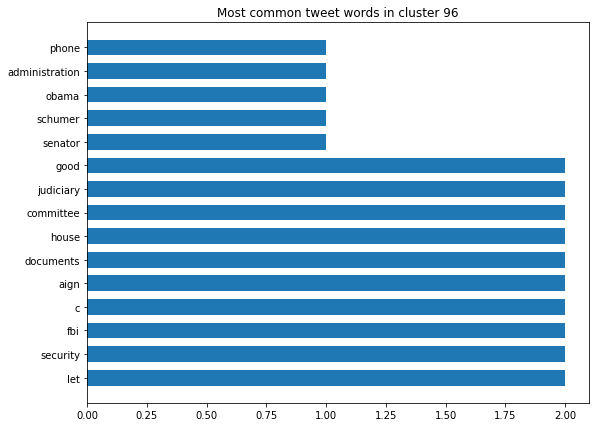

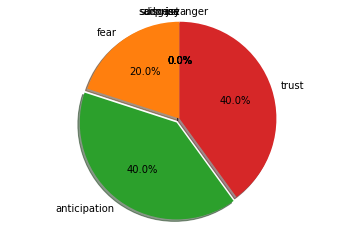

2531 - What does the Department of Justice and FBI have to hide? Why aren’t they giving the strongly requested documents (unredacted) to the HOUSE JUDICIARY COMMITTEE? Stalling, but for what reason? Not looking good!
2449 - Great meeting with Prime Minister Abe of Japan, who has just left Florida. Talked in depth about North Korea, Military and Trade. Good things will happen!
2167 - Senator Schumer and Obama Administration let phone company ZTE flourish with no security checks. I closed it down then let it reopen with high level security guarantees, change of management and board, must purchase U.S. parts and pay a $1.3 Billion fine. Dems do nothing....
2226 - If the FBI or DOJ was infiltrating a campaign for the benefit of another campaign, that is a really big deal. Only the release or review of documents that the House Intelligence Committee (also, Senate Judiciary) is asking for can give the conclusive answers. Drain the Swamp!
2833 - Our entire Nation, w/one heavy heart, continues

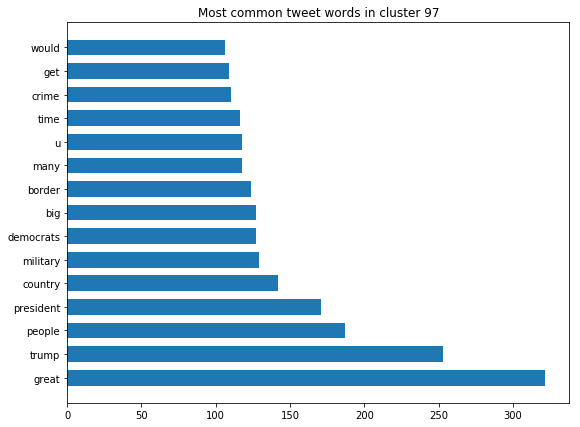

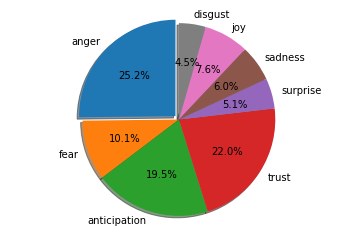

1610 - ....and the DOJ, FBI and Obama Gang need to be held to account. Source #1 was the major source. Avoided talking about it being the Clinton campaign behind it. Misled the Court to provide a pretext to SPY on the Trump Team. Not about Carter Page..was all about getting Trump.....
876 - Judge Kavanaugh showed America exactly why I nominated him. His testimony was powerful, honest, and riveting. Democrats’ search and destroy strategy is disgraceful and this process has been a total sham and effort to delay, obstruct, and resist. The Senate must vote!
186 - ....which it was not (but even if it was, it is only a CIVIL CASE, like Obama’s - but it was done correctly by a lawyer and there would not even be a fine. Lawyer’s liability if he made a mistake, not me). Cohen just trying to get his sentence reduced. WITCH HUNT!
1022 - It is imperative that everyone follow local evacuation orders. This storm is extremely dangerous. Be SAFE! #HurricaneFlorence https://t.co/94Ue4e26PD https://t.co

In [88]:
# apply the DBSCAN algorithm to the data
dbscan = DBSCAN(eps=0.9).fit(mat)
dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
for idx, lbl in enumerate(dbscan.labels_):
    dbscan_clusters[lbl].append(idx)

print(list(map(len, dbscan_clusters)))

def callback(k):
    # find the "center" of this cluster
    acc = np.zeros([1, E])
    for idx in dbscan_clusters[k]:
        acc += np.array(mat[idx], float)
    center = acc/len(dbscan_clusters[k])
    # order the emotions by most present to least present
    orders = [(emotions[i], center[0, i]) for i in range(len(emotions))]
    orders.sort(key=lambda t: t[1], reverse=True)
    print(len(dbscan_clusters[k]))
    print(orders)
    emotion_pie_chart(list(center[0]))

random.seed(1653)
explore_clusters(dbscan_clusters, callback)

#### Except for the last one, each cluster only contains ONE type of vector that appears nowhere else

In [89]:
for k in range(len(dbscan_clusters)-1):
    ctr = mat[dbscan_clusters[k][0]]
    # show that everyone looks like the same
    for idx in dbscan_clusters[k]:
        if mat[idx] != ctr:
            print("oops, should be the same here...")
    for j in range(len(dbscan_clusters)):
        if j==k:
            continue
        for idx in dbscan_clusters[j]:
            if mat[idx] == ctr:
                print("collision found!")

### Agglomerative Clustering

D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_dista

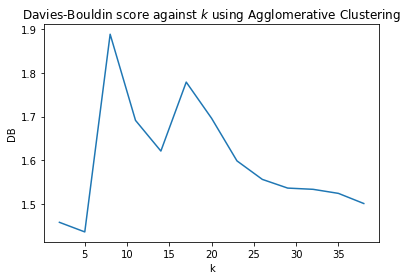

In [42]:
# apply the agglomerative clustering algorithm to the reduced data for different values of K
K = range(2,40,3)
DB = np.zeros_like(K).astype(float)
for i, k in enumerate(K):
    agg = AgglomerativeClustering(n_clusters=k).fit(mat)
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, agg.labels_)
k_opt = K[np.argmin(DB)]
plt.plot(K,DB)
plt.xlabel('k')
plt.ylabel('DB')
plt.title(f'Davies-Bouldin score against $k$ using Agglomerative Clustering')
plt.show()

[574, 1420, 465, 453, 123]
We have 12576 words, of which 3282 are unique
[('trust', 2.317073170731707), ('anticipation', 0.9634146341463414), ('anger', 0.8780487804878049), ('fear', 0.3554006968641115), ('joy', 0.2700348432055749), ('surprise', 0.18815331010452963), ('disgust', 0.11672473867595819), ('sadness', 0.10627177700348432)]


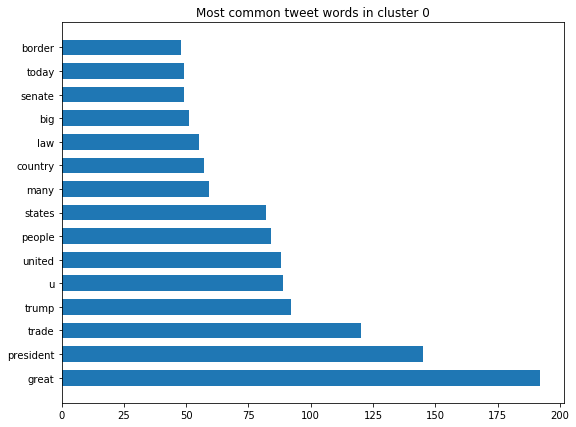

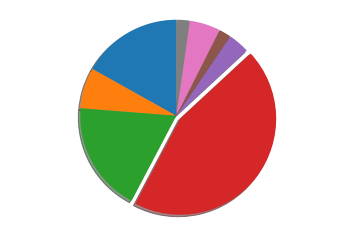

1461 - ....Tariffs will make our country much richer than it is today. Only fools would disagree. We are using them to negotiate fair trade deals and, if countries are still unwilling to negotiate, they will pay us vast sums of money in the form of Tariffs. We win either way......
600 - I want to applaud the FBI, Secret Service, Department of Justice, the U.S. Attorneys’ Office for the Southern District of New York, the NYPD, and all Law Enforcement partners across the Country for their incredible work, skill and determination!
2108 - Today, it was my great honor to be with the brave men and women of the United States Coast Guard! https://t.co/RAyPbOGXuZ
964 - .....China has been taking advantage of the United States on Trade for many years. They also know that I am the one that knows how to stop it. There will be great and fast economic retaliation against China if our farmers, ranchers and/or industrial workers are targeted!
2686 - Chinese President XI JINPING and I spoke at length a

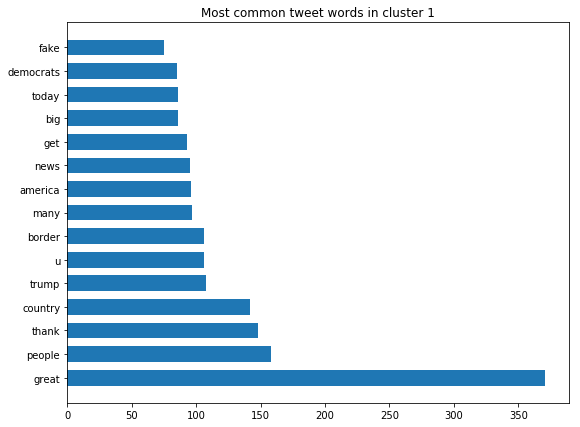

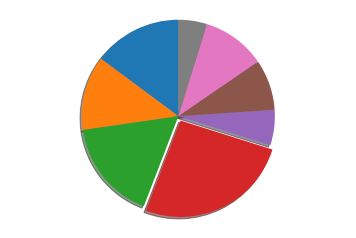

1087 - Landing in Montana now to support Matt Rosendale for U.S. Senate! #MAGA https://t.co/0MIEyWxMbW
1710 - ...things up, better than ever before, but it can’t go too quickly. I am fighting for a level playing field for our farmers, and will win!
1661 - The meeting between President Putin and myself was a great success, except in the Fake News Media!
862 - News conference on the USMCA this morning at 11:00 - Rose Garden of White House.
1885 - “I REALLY DON’T CARE, DO U?” written on the back of Melania’s jacket, refers to the Fake News Media. Melania has learned how dishonest they are, and she truly no longer cares!
----------------------------------------
We have 10364 words, of which 2806 are unique
[('anger', 2.3311827956989246), ('anticipation', 0.6559139784946236), ('trust', 0.5612903225806452), ('fear', 0.45161290322580644), ('sadness', 0.2817204301075269), ('joy', 0.20430107526881722), ('disgust', 0.14408602150537633), ('surprise', 0.11612903225806452)]


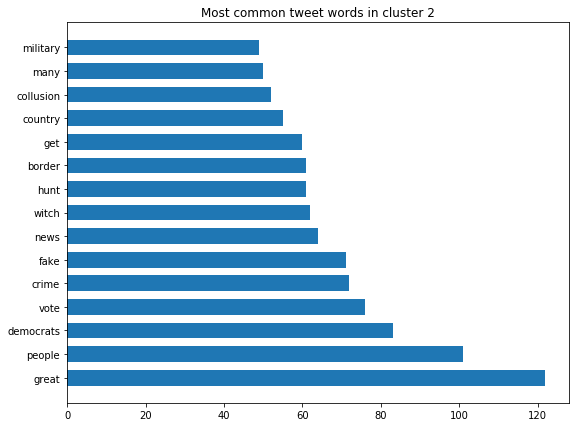

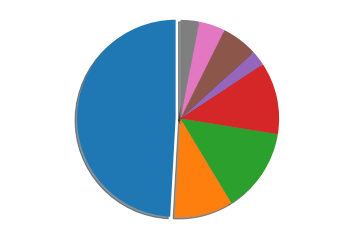

2349 - It would seem very hard to obstruct justice for a crime that never happened! Witch Hunt!
383 - ....care how many lives the ruin. These are Angry People, including the highly conflicted Bob Mueller, who worked for Obama for 8 years. They won’t even look at all of the bad acts and crimes on the other side. A TOTAL WITCH HUNT LIKE NO OTHER IN AMERICAN HISTORY!
1256 - NO COLLUSION - RIGGED WITCH HUNT!
259 - China has agreed to reduce and remove tariffs on cars coming into China from the U.S. Currently the tariff is 40%.
571 - CNN and others in the Fake News Business keep purposely and inaccurately reporting that I said the “Media is the Enemy of the People.” Wrong! I said that the “Fake News (Media) is the Enemy of the People,” a very big difference. When you give out false information - not good!
----------------------------------------
We have 8869 words, of which 2653 are unique
[('anticipation', 2.2362030905077264), ('trust', 0.46357615894039733), ('anger', 0.3200883002207506), 

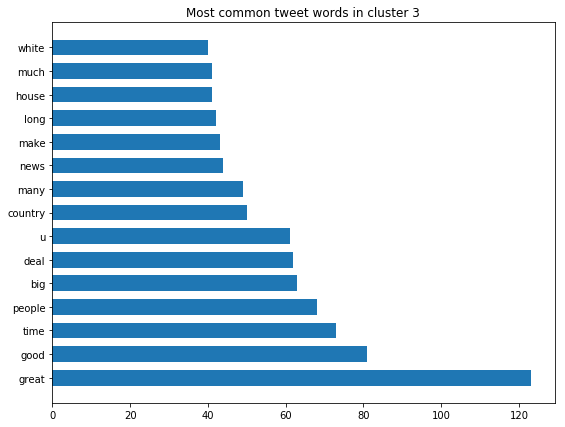

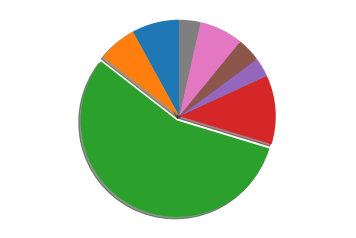

1310 - All of the fools that are so focused on looking only at Russia should start also looking in another direction, China. But in the end, if we are smart, tough and well prepared, we will get along with everyone!
374 - People are not being told that the Republican Party is on track to pick up two seats in the U.S. Senate, and epic victory: 53 to 47. The Fake News Media only wants to speak of the House, where the Midterm results were better than other sitting Presidents.
1434 - When I decided to go to Ohio for Troy Balderson, he was down in early voting 64 to 36. That was not good. After my speech on Saturday night, there was a big turn for the better. Now Troy wins a great victory during a very tough time of the year for voting. He will win BIG in Nov.
2999 - The Democrats are all talk and no action. They are doing nothing to fix DACA. Great opportunity missed. Too bad!
2854 - 4.2 million hard working Americans have already received a large Bonus and/or Pay Increase because of our r

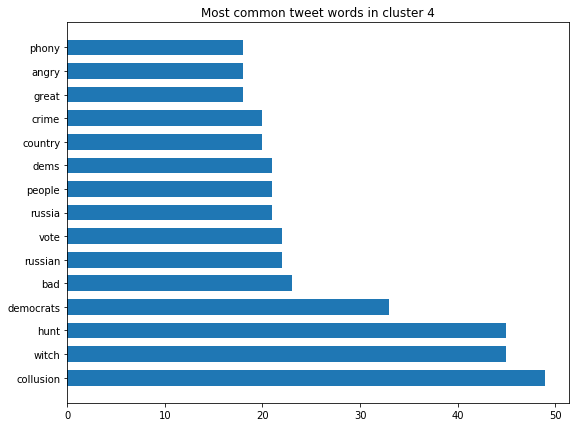

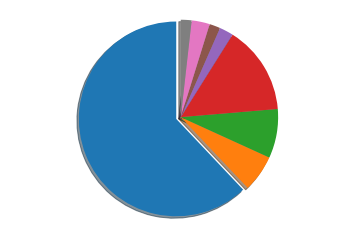

2532 - Lawmakers of the House Judiciary Committee are angrily accusing the Department of Justice of missing the Thursday Deadline for turning over UNREDACTED Documents relating to FISA abuse, FBI, Comey, Lynch, McCabe, Clinton Emails and much more. Slow walking - what is going on? BAD!
922 - Senator Feinstein and the Democrats held the letter for months, only to release it with a bang after the hearings were OVER - done very purposefully to Obstruct &amp; Resist &amp; Delay. Let her testify, or not, and TAKE THE VOTE!
1534 - There is No Collusion! The Robert Mueller Rigged Witch Hunt, headed now by 17 (increased from 13, including an Obama White House lawyer) Angry Democrats, was started by a fraudulent Dossier, paid for by Crooked Hillary and the DNC. Therefore, the Witch Hunt is an illegal Scam!
384 - The inner workings of the Mueller investigation are a total mess. They have found no collusion and have gone absolutely nuts. They are screaming and shouting at people, horribly threate

In [93]:
# apply agglomerative clustering
agg = AgglomerativeClustering(n_clusters=5).fit(mat)
agg_clusters = [[] for i in range(max(agg.labels_+1))]
for idx, lbl in enumerate(agg.labels_):
    agg_clusters[lbl].append(idx)

print(list(map(len, agg_clusters)))

def callback(k):
    # find the "center" of this cluster
    acc = np.zeros([1, E])
    for idx in agg_clusters[k]:
        acc += np.array(mat[idx], float)
    center = acc/len(agg_clusters[k])
    # order the emotions by most present to least present
    orders = [(emotions[i], center[0, i]) for i in range(len(emotions))]
    orders.sort(key=lambda t: t[1], reverse=True)
    print(orders)
    emotion_pie_chart(center[0], False)

random.seed(123283)
# explore every cluster
explore_clusters(agg_clusters, callback)